In [1]:
import datasets as ds
import utils as ut
import models as md

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
import skfuzzy as fuzz


# fairlearn
from fairlearn.postprocessing import ThresholdOptimizer
from xgboost import XGBClassifier
import fasttext

# libs 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.model_selection import ShuffleSplit

%load_ext autoreload
%autoreload 2

## Section 1: Auditing with repsect to stereotypes 

In [5]:
dataset = ds.Dataset('nels')
dataset.split_train_test() 
print(dataset.x_train.shape, dataset.x_test.shape)

total students 12144
Limiting entries to two racial groups 3 n=1041 and 4 n=7908
remaining students 8949
(6264, 812) (1343, 812)


In [54]:
# base predictor 
clf = LogisticRegression()
clf.fit(dataset.x_train, dataset.y_train)

p = clf.predict_proba(dataset.x_test)[:, 1]
p_acc = accuracy_score(dataset.y_test, p > 0.5)

mask = dataset.g_test == 1
white_acc = accuracy_score(dataset.y_test[mask], p[mask] > 0.5)
black_acc = accuracy_score(dataset.y_test[~mask], p[~mask] > 0.5)

print(f"base clf acc: {p_acc:.3f} male acc: {white_acc:.3f} female acc: {black_acc:.3f}")

base clf acc: 0.829 male acc: 0.828 female acc: 0.840


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [77]:
g_clf = LogisticRegression()
g_clf.fit(dataset.x_train, dataset.g_train)
g_all_pred = occ_clf.predict_proba(dataset.x_test)[:, 1]
print(f"clf g acc: {accuracy_score(dataset.g_test, 
                                  g_clf.predict(dataset.x_test)):.3f}")

clf g acc: 0.908


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [78]:
g_clf.predict(dataset.x_test).mean()

0.9002233804914371

In [66]:
abs_coeff = np.abs(g_clf.coef_.round(1)).flatten()
coeff = g_clf.coef_.round(1).flatten()
coeff_sorted = coeff[np.argsort(abs_coeff)[::-1]]
abs_coeff_sorted = abs_coeff[np.argsort(abs_coeff)[::-1]]
print(coeff_sorted[:10])
dataset.x_labels[np.argsort(abs_coeff)[::-1][:10]]

[ 1.4  1.1  1.1 -1.1  1.  -1.  -0.9  0.9  0.8 -0.7]


Index(['G8MINOR_0', 'F22XSSTD', 'F12XSSTD', 'G8MINOR_7', 'F2ROSO_C',
       'G8REGON_3', 'G8MINOR_6', 'G8REGON_4', 'F22XMSTD', 'G8MINOR_4'],
      dtype='object')

Top 10 Contributers to race: 
- 'G8MINOR_0' # PERCENT MINORITY IN SCHOOL
- 'F22XSSTD' # SCIENCE STANDARDIZED SCORE
- 'F12XSSTD' #SCIENCE STANDARDIZED SCORE
- 'G8MINOR_7'  # PERCENT MINORITY IN SCHOOL
- 'F2ROSO_C' #UNITS IN OTHER SOC. STUDIES (NAEP)
- 'G8REGON_3' #COMPOSITE GEOGRAPHIC REGION OF SCHOOL
- 'G8MINOR_6' # PERCENT MINORITY IN SCHOOL
- 'G8REGON_4' # COMPOSITE GEOGRAPHIC REGION OF SCHOOL
- 'F22XMSTD' #MATHEMATICS STANDARDIZED SCORE 
- 'G8MINOR_4' #  PERCENT MINORITY IN SCHOOL

In [81]:
for n_dim in [2,4,8, 16, 32, 64, 128, 300]:
    pca = PCA(n_components=n_dim)
    x = pca.fit_transform(dataset.x_train)
    x_test = pca.transform(dataset.x_test)
    g_clf_pca = LogisticRegression()
    g_clf_pca.fit(x, dataset.g_train)
    print(f"g dim {n_dim} acc: {accuracy_score(dataset.g_test, 
                                                  g_clf_pca.predict(x_test)):.3f}")
    print(g_clf_pca.predict(x_test).mean())

g dim 2 acc: 0.879
1.0
g dim 4 acc: 0.879
1.0
g dim 8 acc: 0.879
1.0
g dim 16 acc: 0.882
0.9798957557706627
g dim 32 acc: 0.903
0.9367088607594937
g dim 64 acc: 0.917
0.9240506329113924
g dim 128 acc: 0.919
0.9195830230826508
g dim 300 acc: 0.919
0.9091586001489204


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [99]:
standarized_test_features = [
'F12XRSTD',
'F12XMSTD',
'F12XSSTD',
'F12XHSTD',
'F22XRSTD',
'F22XMSTD',	
'F22XSSTD',	
'F22XHSTD',
'BY2XRSTD',
'BY2XMSTD',	
'BY2XSSTD',	
'BY2XHSTD',	
]

F12XRSTD found
F12XMSTD found
F12XSSTD found
F12XHSTD found
F22XRSTD found
F22XMSTD found
F22XSSTD found
F22XHSTD found
BY2XRSTD found
BY2XMSTD found
BY2XSSTD found
BY2XHSTD found


In [138]:
# use 64 dim
n_dim = 32
pca = PCA(n_components=n_dim)
dataset.x_pca_train = pca.fit_transform(dataset.x_train)
dataset.x_pca_test = pca.transform(dataset.x_test)

def find_means(features: np.array, group_labels: np.array): 
    ## assume group labels are 1 and 0 
    group1 = features[group_labels]
    group2 = features[~group_labels]
    #print(group1.mean(axis=0).shape)
    means = np.stack([group1.mean(axis=0), group2.mean(axis=0)])
    return means

In [139]:
# stereotype predictors:
# 1) overall pg
all_pg_clf = LogisticRegression()
all_pg_clf.fit(dataset.x_train, dataset.g_train)
all_pg = all_pg_clf.predict_proba(dataset.x_test)[:, 1]

# 2) harmful features
feature_indices = np.array([list(dataset.x_labels).index(key) for key in standarized_test_features if key in dataset.x_labels])
dataset.x_harmful_train = dataset.x_train[:, feature_indices]
dataset.x_harmful_test = dataset.x_test[:, feature_indices]

test_pg_clf_base = LogisticRegression() 
test_pg_clf_base = test_pg_clf_base.fit(dataset.x_harmful_train, dataset.g_train)
test_pg_clf = md.HarmfulFeaturesClassifier(base_clf=test_pg_clf_base, feature_ind=feature_indices)
test_pg = test_pg_clf.predict_proba(dataset.x_test)[:, 1]

# 3) clustering 
cntr = find_means(dataset.x_pca_train, dataset.g_train)
cluster_pg_clf = md.FuzzyClusterPredictor(cntr, reduce_fn=pca)
cluster_pg = cluster_pg_clf.predict_proba(dataset.x_test)[:, 1]

/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [140]:
# evaluate stereotype predictors
# clf

results = {} 
p = clf.predict_proba(dataset.x_test)[:, 1]
for pg, name in zip([all_pg, test_pg, cluster_pg], 
                    ['all_pg', 'harm_pg', 'cluster_pg']): 
    print(name)
    # group prediction accuracy
    print(f"acc {accuracy_score(dataset.g_test, pg>0.5):.3f}")
    print('cov(y, pg)', ut.emp_cov(dataset.y_test, pg))
    print('corr(y, pg)', stats.pearsonr(dataset.y_test, pg))
    print('cov(p, pg)', ut.emp_cov(p, pg))
    print('corr(p, pg)', stats.pearsonr(p, pg))
    results[name] = {} 
    results[name]['DP'] = ut.emp_cov(p, pg)
    results[name]['DP_corr'] = stats.pearsonr(p, pg)


    mask = dataset.y_test == 1 
    print('cov(p, pg | y=1)', ut.emp_cov(p[mask], pg[mask]))
    print('corr(p, pg | y=1)', stats.pearsonr(p[mask], pg[mask]))
    results[name]['EO'] = ut.emp_cov(p[mask], pg[mask])
    results[name]['EO_corr'] = stats.pearsonr(p[mask], pg[mask])

    results[name]['MA'] = np.abs(ut.emp_cov(p, pg) - ut.emp_cov(dataset.y_test, pg))

all_pg
acc 0.908
cov(y, pg) 0.018279172046173374
corr(y, pg) PearsonRResult(statistic=0.14410099921792272, pvalue=1.1350987285352354e-07)
cov(p, pg) 0.016179209265513538
corr(p, pg) PearsonRResult(statistic=0.16901044514162117, pvalue=4.580497991513209e-10)
cov(p, pg | y=1) 0.008201236411393009
corr(p, pg | y=1) PearsonRResult(statistic=0.15331995985099664, pvalue=0.0006041811359890542)
harm_pg
acc 0.879
cov(y, pg) 0.009343959098514534
corr(y, pg) PearsonRResult(statistic=0.27569561382752805, pvalue=7.488275434922261e-25)
cov(p, pg) 0.009246094102546521
corr(p, pg) PearsonRResult(statistic=0.36149560261981634, pvalue=9.958578600586774e-43)
cov(p, pg | y=1) 0.004543971340198373
corr(p, pg | y=1) PearsonRResult(statistic=0.27315792085890983, pvalue=5.923090034870297e-10)
cluster_pg
acc 0.845
cov(y, pg) 0.005539978263820642
corr(y, pg) PearsonRResult(statistic=0.14648952414203498, pvalue=6.947934099083869e-08)
cov(p, pg) 0.0051768365088048695
corr(p, pg) PearsonRResult(statistic=0.1813880

## Demographic Parity

In [177]:
DP_plot = [] 

In [178]:
# DP Post Processing
dataset = dataset

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)

i = 0 

for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = dataset.x_train[train_idx]
    y_train_sub = dataset.y_train[train_idx]
    g_train_sub = dataset.g_train[train_idx]

    # 2. Fit models
    clf = LogisticRegression()
    clf.fit(x_train_sub, y_train_sub)


    # 1) stereotype associations
    all_pg_clf = LogisticRegression()
    all_pg_clf.fit(x_train_sub, g_train_sub)

    # 2) harmful stereotypes
    test_pg_clf_base = LogisticRegression() 
    test_pg_clf_base = test_pg_clf_base.fit(x_train_sub[:, feature_indices], g_train_sub)
    test_pg_clf = md.HarmfulFeaturesClassifier(base_clf=test_pg_clf_base, feature_ind=feature_indices)
    
    # 2c) clustering 
    cntr = find_means(pca.transform(x_train_sub), g_train_sub)
    cluster_pg_clf = md.FuzzyClusterPredictor(cntr, reduce_fn=pca)


    pg_dict = {'all_pg': all_pg_clf,
               'harm_pg': test_pg_clf,
               'cluster_pg': cluster_pg_clf}
    
    
    prev_results = ut.results_summary(p=clf.predict_proba(dataset.x_test)[:, 1], 
                            pg_dict=pg_dict, 
                            x=dataset.x_test, 
                            y=dataset.y_test, 
                            g=dataset.g_test)

    clfs = [
        ([all_pg_clf], r'$\hat{p}_g^{(all)}$'), 
        ([test_pg_clf], r'$\hat{p}_g^{(harm)}$'), 
        ([cluster_pg_clf], r'$\hat{p}_g^{(FCM)}$'), 
        ([all_pg_clf, test_pg_clf, cluster_pg_clf], r'$(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$'),
    ]
    

    for clf_list, clf_list_name in clfs: 
        # 2. Refit models
        clf = LogisticRegression()
        clf.fit(x_train_sub, y_train_sub)
    
        
        if clf_list_name == r'$\hat{p}_g^{(all)}$': 
            for key in pg_dict.keys(): 
                DP_plot.append({
                    'eval_pg': key, 
                    'intervention_pg': 'None', 
                    'value': prev_results[f'cov(p, {key})'], 
                    'run': i, 
                    'acc': prev_results['accuracy'], 
                })
        
    
        
        c_post_processed = md.DPMulti(base_clf=clf, pg_clf_list=clf_list)
        md.fit_dp_pg_multi(x=x_train_sub, 
                       multi_clf=c_post_processed, 
                       alpha=1e-4,
                        max_iter=100)
        
        results = ut.results_summary(p=c_post_processed.predict_proba_1d(dataset.x_test), 
                                pg_dict=pg_dict, 
                                x=dataset.x_test, 
                                y=dataset.y_test, 
                                g=dataset.g_test)
        for key in pg_dict.keys(): 
            DP_plot.append({
                'eval_pg': key, 
                'intervention_pg': f'DP wrt. {clf_list_name}', 
                'value': results[f'cov(p, {key})'], 
                'acc': results['accuracy'], 
                'run': i, 
            })

/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.ht

new iteration


 11%|████▊                                       | 11/100 [00:00<00:00, 95.63it/s]

0.017428232286394747
0.016355175802960135
0.015446124375193564
0.014630453887701123
0.013884887086536162
0.013196151332623664
0.012556023826950376
0.011959089796652687
0.011400354201056452
0.010874849476906234
0.010381271186632159
0.009916834724721822
0.009481419805287794
0.00907015773644333
0.008680603328480084


 21%|█████████▏                                  | 21/100 [00:00<00:01, 51.84it/s]

0.008310445127780425
0.00795868726333326
0.007624026725102968
0.007306734432261249
0.007006536988101056
0.006720926055714506
0.006449196935934977
0.006190815946704184
0.005945345580334232
0.005711259059578412
0.005487190905105114
0.005273129961465132


 28%|████████████▎                               | 28/100 [00:00<00:01, 38.70it/s]

0.005068711348482641
0.004873634380297654
0.0046873502168639745
0.004509023275775331
0.00433798731605308


 33%|██████████████▌                             | 33/100 [00:00<00:02, 31.99it/s]

0.0041743798672028735
0.004017741591409189
0.0038673047724962326
0.0037229795213076277


 37%|████████████████▎                           | 37/100 [00:01<00:02, 27.42it/s]

0.003584494739879667


 40%|█████████████████▌                          | 40/100 [00:01<00:02, 24.41it/s]

0.003451798670952994
0.0033242995097759946
0.003201740215127646
0.003084393257410354


 43%|██████████████████▉                         | 43/100 [00:01<00:02, 21.91it/s]

0.0029717331439776417
0.002863374348138686
0.0027591685491260482
0.002659017672317257


 46%|████████████████████▏                       | 46/100 [00:01<00:02, 19.60it/s]

0.0025628222847282945
0.002470288251194346
0.002381328754770357


 49%|█████████████████████▌                      | 49/100 [00:01<00:02, 17.87it/s]

0.0022958057994794247
0.002213385342385697


 51%|██████████████████████▍                     | 51/100 [00:02<00:02, 16.83it/s]

0.0021342007500896295


 53%|███████████████████████▎                    | 53/100 [00:02<00:02, 15.83it/s]

0.002057935490088705
0.001984660497971599
0.0019142433231683304


 55%|████████████████████████▏                   | 55/100 [00:02<00:03, 14.94it/s]

0.0018464630486900316
0.0017811932057274276


 57%|█████████████████████████                   | 57/100 [00:02<00:03, 14.09it/s]

0.0017183234287740706


 59%|█████████████████████████▉                  | 59/100 [00:02<00:03, 13.37it/s]

0.0016577660259914865
0.0015994565703517912
0.0015432730656820932


 61%|██████████████████████████▊                 | 61/100 [00:02<00:03, 12.74it/s]

0.0014891778069586591
0.0014370261591777132


 63%|███████████████████████████▋                | 63/100 [00:03<00:03, 12.26it/s]

0.001386854692302109


 65%|████████████████████████████▌               | 65/100 [00:03<00:02, 11.77it/s]

0.0013385449607343012
0.0012920531989166263
0.001247306248984714


 67%|█████████████████████████████▍              | 67/100 [00:03<00:02, 11.34it/s]

0.0012042074988918925
0.0011626666551223966


 69%|██████████████████████████████▎             | 69/100 [00:03<00:02, 10.95it/s]

0.0011225933062334952
0.001083941109366834


 71%|███████████████████████████████▏            | 71/100 [00:03<00:02, 10.54it/s]

0.0010466391608115082
0.0010106588459150815


 73%|████████████████████████████████            | 73/100 [00:04<00:02,  9.11it/s]

0.0009760290547803777


 74%|████████████████████████████████▌           | 74/100 [00:04<00:02,  9.16it/s]

0.0009426150234481154


 75%|█████████████████████████████████           | 75/100 [00:04<00:02,  9.20it/s]

0.0009103451865365505


 76%|█████████████████████████████████▍          | 76/100 [00:04<00:02,  9.20it/s]

0.0008792290051663712


 77%|█████████████████████████████████▉          | 77/100 [00:04<00:02,  9.17it/s]

0.0008492077507272656


 78%|██████████████████████████████████▎         | 78/100 [00:04<00:02,  9.14it/s]

0.0008202602360552384


 79%|██████████████████████████████████▊         | 79/100 [00:04<00:02,  9.09it/s]

0.0007923214968905773


 80%|███████████████████████████████████▏        | 80/100 [00:04<00:02,  8.99it/s]

0.0007653639116244632


 81%|███████████████████████████████████▋        | 81/100 [00:04<00:02,  8.91it/s]

0.0007393379048887229


 82%|████████████████████████████████████        | 82/100 [00:05<00:02,  8.82it/s]

0.0007142093161589898


 83%|████████████████████████████████████▌       | 83/100 [00:05<00:01,  8.75it/s]

0.000689969333197365


 84%|████████████████████████████████████▉       | 84/100 [00:05<00:01,  8.64it/s]

0.0006665755439854847


 85%|█████████████████████████████████████▍      | 85/100 [00:05<00:01,  8.53it/s]

0.0006439925364140256


 86%|█████████████████████████████████████▊      | 86/100 [00:05<00:01,  8.42it/s]

0.0006222096916382707


 87%|██████████████████████████████████████▎     | 87/100 [00:05<00:01,  8.32it/s]

0.0006012016992959921


 88%|██████████████████████████████████████▋     | 88/100 [00:05<00:01,  8.12it/s]

0.0005809181466859523


 89%|███████████████████████████████████████▏    | 89/100 [00:05<00:01,  7.94it/s]

0.0005613358934338335


 90%|███████████████████████████████████████▌    | 90/100 [00:06<00:01,  7.82it/s]

0.0005424089588279481


 91%|████████████████████████████████████████    | 91/100 [00:06<00:01,  7.72it/s]

0.0005241279624188799


 92%|████████████████████████████████████████▍   | 92/100 [00:06<00:01,  7.64it/s]

0.0005064889976854939


 93%|████████████████████████████████████████▉   | 93/100 [00:06<00:00,  7.62it/s]

0.0004894579951281231


 94%|█████████████████████████████████████████▎  | 94/100 [00:06<00:00,  7.57it/s]

0.00047299967045602543


 95%|█████████████████████████████████████████▊  | 95/100 [00:06<00:00,  7.54it/s]

0.00045709476702478766


 96%|██████████████████████████████████████████▏ | 96/100 [00:06<00:00,  7.47it/s]

0.00044172467570644837


 97%|██████████████████████████████████████████▋ | 97/100 [00:07<00:00,  7.41it/s]

0.0004268798927396816


 98%|███████████████████████████████████████████ | 98/100 [00:07<00:00,  7.35it/s]

0.0004125405118372609


 99%|███████████████████████████████████████████▌| 99/100 [00:07<00:00,  7.28it/s]

0.00039870385207473215


100%|███████████████████████████████████████████| 100/100 [00:07<00:00, 13.44it/s]

0.00038533772580186254



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 27%|███████████▌                               | 27/100 [00:00<00:00, 268.08it/s]

0.009757585083947778
0.009675587723133537
0.00958046394710753
0.00947800277431741
0.009373176510618966
0.009266252590680124
0.009159833271629692
0.009054081553620372
0.008947605293145621
0.008841284982588135
0.008734245291862605
0.00862774023145106
0.008521953774060882
0.008416810872564856
0.008312766400567448
0.00820969660499868
0.008106889687485144
0.00800513651256615
0.007904681939598973
0.0078054657295319315
0.007707483586945228
0.0076106514947930255
0.0075147398661149405
0.007419912913606455
0.007326697411747374
0.00723461391394584
0.007143488303926318
0.007053440001394325
0.006964269524271714
0.006876204891108452
0.0067895194867722605
0.006703931357698062
0.006619556349676055
0.006535814352388768
0.006452946735635849
0.006371380818144571
0.006291253456513948
0.00621249953382168
0.006134916107724928
0.006058220657866739
0.00598270636833034


 54%|███████████████████████▏                   | 54/100 [00:00<00:00, 163.96it/s]

0.0059083468727490485
0.0058349841244877835
0.005762833206568562
0.005692135892210689
0.005622318654020419
0.005553649752818017
0.005485764000084453
0.005418795545065722
0.005352942047796552
0.005288182702987993
0.005224324108411952
0.0051616203670129005
0.005100094066935541
0.005039235284781624
0.004979364374065622
0.0049204652997046185
0.004862343888990591
0.004804957643707457
0.004748404163717717
0.004692748993089546
0.004637915390929828
0.004583961019849788


 73%|███████████████████████████████▍           | 73/100 [00:00<00:00, 125.20it/s]

0.004530739014284227
0.0044782007045334835
0.0044263055163737556
0.0043755090133890135
0.004325538037263167
0.004276281492543359
0.004227668135626174
0.004179614679559885
0.004132303870375191
0.0040856910725177685
0.004039820295046119
0.003994439617543637
0.0039495226920798505
0.0039052082716875703
0.003861495292545916
0.003818482462782827


 88%|█████████████████████████████████████▊     | 88/100 [00:00<00:00, 103.92it/s]

0.003776065561870142
0.0037341958510603537
0.0036929671620752566
0.003652265001981919
0.0036121707908071906
0.0035725575285021254
0.003533348840399912
0.0034946545210110852
0.0034563519418593564
0.003418489290330698
0.003381154370686863
0.00334435433181558
0.0033080571602634888
0.0032722882453302634


100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 109.16it/s]


0.0032370301610654025
0.0032021775114778024
0.0031677126968157198
0.0031336297394547637
0.003100052418790658
0.003067062656533453
0.0030344973808491583


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▎                                           | 3/100 [00:00<00:04, 20.20it/s]

0.01809610972619037
0.01775563306568772
0.0173969267740811
0.01703801460892215
0.016685179166897535


  6%|██▋                                          | 6/100 [00:00<00:09, 10.25it/s]

0.016338837815418304
0.015998790012942722


  8%|███▌                                         | 8/100 [00:00<00:12,  7.12it/s]

0.01566661491626163


  9%|████                                         | 9/100 [00:01<00:15,  5.98it/s]

0.01534162369541547


 10%|████▍                                       | 10/100 [00:01<00:16,  5.48it/s]

0.015023405952831505


 11%|████▊                                       | 11/100 [00:01<00:19,  4.60it/s]

0.014712985024973587


 12%|█████▎                                      | 12/100 [00:02<00:23,  3.81it/s]

0.01441086744869037


 13%|█████▋                                      | 13/100 [00:02<00:26,  3.33it/s]

0.014116666287360906


 14%|██████▏                                     | 14/100 [00:02<00:27,  3.15it/s]

0.01382926271239522


 15%|██████▌                                     | 15/100 [00:03<00:30,  2.79it/s]

0.013549196890592674


 16%|███████                                     | 16/100 [00:03<00:30,  2.77it/s]

0.013276245650630604


 17%|███████▍                                    | 17/100 [00:04<00:35,  2.36it/s]

0.013010342758850501


 18%|███████▉                                    | 18/100 [00:04<00:34,  2.38it/s]

0.012749694496376803


 19%|████████▎                                   | 19/100 [00:05<00:34,  2.36it/s]

0.01249470251161268


 20%|████████▊                                   | 20/100 [00:05<00:35,  2.27it/s]

0.01224496006406193


 21%|█████████▏                                  | 21/100 [00:06<00:35,  2.24it/s]

0.012000620491800269


 22%|█████████▋                                  | 22/100 [00:06<00:36,  2.14it/s]

0.011762337300166917


 23%|██████████                                  | 23/100 [00:07<00:37,  2.04it/s]

0.011529670667814098


 24%|██████████▌                                 | 24/100 [00:07<00:39,  1.95it/s]

0.011302223442265866


 25%|███████████                                 | 25/100 [00:08<00:40,  1.83it/s]

0.01107970011838693


 26%|███████████▍                                | 26/100 [00:09<00:42,  1.75it/s]

0.010861729688687725


 27%|███████████▉                                | 27/100 [00:09<00:42,  1.70it/s]

0.010647808320307768


 28%|████████████▎                               | 28/100 [00:10<00:43,  1.66it/s]

0.010439448401519068


 29%|████████████▊                               | 29/100 [00:11<00:47,  1.51it/s]

0.010236096140863786


 30%|█████████████▏                              | 30/100 [00:11<00:49,  1.42it/s]

0.010037164815822919


 31%|█████████████▋                              | 31/100 [00:12<00:49,  1.39it/s]

0.009842692352572843


 32%|██████████████                              | 32/100 [00:13<00:51,  1.31it/s]

0.00965269616956652


 33%|██████████████▌                             | 33/100 [00:14<00:53,  1.25it/s]

0.009467080833200385


 34%|██████████████▉                             | 34/100 [00:15<00:54,  1.21it/s]

0.009285786268171413


 35%|███████████████▍                            | 35/100 [00:16<00:57,  1.12it/s]

0.009108214899762743


 36%|███████████████▊                            | 36/100 [00:17<00:57,  1.11it/s]

0.00893442741690971


 37%|████████████████▎                           | 37/100 [00:18<00:58,  1.07it/s]

0.008764456977883741


 38%|████████████████▋                           | 38/100 [00:19<01:01,  1.00it/s]

0.008598280275694358


 39%|█████████████████▏                          | 39/100 [00:20<01:02,  1.03s/it]

0.008436121219031477


 40%|█████████████████▌                          | 40/100 [00:21<01:04,  1.08s/it]

0.008278049843772948


 41%|██████████████████                          | 41/100 [00:22<01:04,  1.10s/it]

0.008123577453846951


 42%|██████████████████▍                         | 42/100 [00:23<01:04,  1.11s/it]

0.007972440955865436


 43%|██████████████████▉                         | 43/100 [00:25<01:04,  1.12s/it]

0.00782460043257444


 44%|███████████████████▎                        | 44/100 [00:26<01:04,  1.15s/it]

0.007679920370432042


 45%|███████████████████▊                        | 45/100 [00:27<01:03,  1.15s/it]

0.007538467891590375


 46%|████████████████████▏                       | 46/100 [00:28<01:03,  1.18s/it]

0.007400192365569105


 47%|████████████████████▋                       | 47/100 [00:29<01:03,  1.19s/it]

0.007265138116716001


 48%|█████████████████████                       | 48/100 [00:31<01:03,  1.22s/it]

0.007132868597237349


 49%|█████████████████████▌                      | 49/100 [00:32<01:04,  1.27s/it]

0.007003623539130294


 50%|██████████████████████                      | 50/100 [00:33<01:03,  1.28s/it]

0.006877049754703481


 51%|██████████████████████▍                     | 51/100 [00:35<01:03,  1.30s/it]

0.0067532892335423565


 52%|██████████████████████▉                     | 52/100 [00:36<01:03,  1.32s/it]

0.006632218235710486


 53%|███████████████████████▎                    | 53/100 [00:38<01:04,  1.37s/it]

0.0065137608372474


 54%|███████████████████████▊                    | 54/100 [00:39<01:04,  1.40s/it]

0.00639793395932064


 55%|████████████████████████▏                   | 55/100 [00:41<01:04,  1.44s/it]

0.006284694417597586


 56%|████████████████████████▋                   | 56/100 [00:42<01:04,  1.47s/it]

0.006173794307046658


 57%|█████████████████████████                   | 57/100 [00:44<01:03,  1.47s/it]

0.006065407581945875


 58%|█████████████████████████▌                  | 58/100 [00:45<01:02,  1.50s/it]

0.005959108635275103


 59%|█████████████████████████▉                  | 59/100 [00:47<01:03,  1.54s/it]

0.005854899717302684


 60%|██████████████████████████▍                 | 60/100 [00:48<01:02,  1.56s/it]

0.005752774303978333


 61%|██████████████████████████▊                 | 61/100 [00:50<01:00,  1.55s/it]

0.005652695632475622


 62%|███████████████████████████▎                | 62/100 [00:51<00:58,  1.54s/it]

0.005554986851059971


 63%|███████████████████████████▋                | 63/100 [00:53<00:58,  1.57s/it]

0.00545943242258249


 64%|████████████████████████████▏               | 64/100 [00:55<00:59,  1.65s/it]

0.00536556473586485


 65%|████████████████████████████▌               | 65/100 [00:57<00:59,  1.70s/it]

0.005273343946156093


 66%|█████████████████████████████               | 66/100 [00:59<00:58,  1.72s/it]

0.005182808382191643


 67%|█████████████████████████████▍              | 67/100 [01:00<00:54,  1.66s/it]

0.005094671303509941


 68%|█████████████████████████████▉              | 68/100 [01:02<00:52,  1.63s/it]

0.005008507282106807


 69%|██████████████████████████████▎             | 69/100 [01:03<00:52,  1.70s/it]

0.004924064198644447


 70%|██████████████████████████████▊             | 70/100 [01:05<00:52,  1.74s/it]

0.004841230126717835


 71%|███████████████████████████████▏            | 71/100 [01:07<00:52,  1.80s/it]

0.004759904799632344


 72%|███████████████████████████████▋            | 72/100 [01:09<00:50,  1.81s/it]

0.004680137183641184


 73%|████████████████████████████████            | 73/100 [01:11<00:48,  1.79s/it]

0.004602026109792914


 74%|████████████████████████████████▌           | 74/100 [01:13<00:45,  1.77s/it]

0.004525334387328822


 75%|█████████████████████████████████           | 75/100 [01:14<00:44,  1.78s/it]

0.004450129812907581


 76%|█████████████████████████████████▍          | 76/100 [01:16<00:44,  1.87s/it]

0.0043766668004572495


 77%|█████████████████████████████████▉          | 77/100 [01:19<00:45,  1.97s/it]

0.004304520507607478


 78%|██████████████████████████████████▎         | 78/100 [01:21<00:44,  2.01s/it]

0.0042336525861992385


 79%|██████████████████████████████████▊         | 79/100 [01:23<00:42,  2.03s/it]

0.0041643385481788375


 80%|███████████████████████████████████▏        | 80/100 [01:25<00:42,  2.11s/it]

0.004096454951066028


 81%|███████████████████████████████████▋        | 81/100 [01:27<00:41,  2.16s/it]

0.004030028204020598


 82%|████████████████████████████████████        | 82/100 [01:30<00:39,  2.18s/it]

0.00396475498079886


 83%|████████████████████████████████████▌       | 83/100 [01:32<00:36,  2.17s/it]

0.0039005438999287355


 84%|████████████████████████████████████▉       | 84/100 [01:34<00:35,  2.19s/it]

0.0038377202118423507


 85%|█████████████████████████████████████▍      | 85/100 [01:36<00:32,  2.16s/it]

0.00377616286946059


 86%|█████████████████████████████████████▊      | 86/100 [01:38<00:29,  2.12s/it]

0.003715651435883984


 87%|██████████████████████████████████████▎     | 87/100 [01:40<00:27,  2.12s/it]

0.0036564166255211483


 88%|██████████████████████████████████████▋     | 88/100 [01:43<00:26,  2.17s/it]

0.003598367791574164


 89%|███████████████████████████████████████▏    | 89/100 [01:45<00:23,  2.18s/it]

0.0035414627663506


 90%|███████████████████████████████████████▌    | 90/100 [01:47<00:22,  2.21s/it]

0.0034858937506573153


 91%|████████████████████████████████████████    | 91/100 [01:49<00:20,  2.25s/it]

0.0034314707679641717


 92%|████████████████████████████████████████▍   | 92/100 [01:52<00:18,  2.27s/it]

0.003378019010395326


 93%|████████████████████████████████████████▉   | 93/100 [01:54<00:16,  2.30s/it]

0.003325444297895933


 94%|█████████████████████████████████████████▎  | 94/100 [01:57<00:14,  2.35s/it]

0.0032738221854501865


 95%|█████████████████████████████████████████▊  | 95/100 [01:59<00:12,  2.44s/it]

0.003223071371165387


 96%|██████████████████████████████████████████▏ | 96/100 [02:02<00:09,  2.45s/it]

0.003173257091347958


 97%|██████████████████████████████████████████▋ | 97/100 [02:04<00:07,  2.49s/it]

0.0031243517419155863


 98%|███████████████████████████████████████████ | 98/100 [02:07<00:04,  2.48s/it]

0.003076195258992779


 99%|███████████████████████████████████████████▌| 99/100 [02:09<00:02,  2.50s/it]

0.0030288118196546755


100%|███████████████████████████████████████████| 100/100 [02:12<00:00,  1.33s/it]

0.002982215268168849



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:08, 12.17it/s]

0.017428232286394747
0.00958242148803788
0.017672424662474737
0.016136566403010432
0.009178280076987679
0.016813594319710187
0.015000094600173245
0.00876315015385311
0.01598388336246966
0.013958209224344015
0.008360017543015567


  4%|█▊                                           | 4/100 [00:00<00:17,  5.43it/s]

0.015188319260863056
0.013000918083008335
0.007968749968530836


  5%|██▎                                          | 5/100 [00:00<00:21,  4.45it/s]

0.014438869428487358
0.012117891751459378


  6%|██▋                                          | 6/100 [00:01<00:27,  3.37it/s]

0.007594710224376286
0.013729977267822208
0.011295774739976387
0.0072402005864096045


  7%|███▏                                         | 7/100 [00:01<00:33,  2.76it/s]

0.013060840921953894
0.0105335870722124
0.00690579096814909


  8%|███▌                                         | 8/100 [00:02<00:39,  2.33it/s]

0.012433449515924315
0.00983439541030722
0.006590739382774927


  9%|████                                         | 9/100 [00:03<00:46,  1.94it/s]

0.011839779194128222
0.0091907441567919
0.006293327291197445


 10%|████▍                                       | 10/100 [00:04<00:52,  1.73it/s]

0.011279879636171542
0.008600583487371798
0.006014311064447147


 11%|████▊                                       | 11/100 [00:04<00:58,  1.52it/s]

0.010752108313649669
0.008047431565353123
0.005750880433130644


 12%|█████▎                                      | 12/100 [00:05<01:04,  1.36it/s]

0.010257904234135775
0.007529211376069114
0.005503659165723139


 13%|█████▋                                      | 13/100 [00:06<01:09,  1.24it/s]

0.009793680697729606
0.007044952775795778
0.0052722117275312555


 14%|██████▏                                     | 14/100 [00:08<01:21,  1.06it/s]

0.009355950887352004
0.0065954557469035165
0.005054162442787418


 15%|██████▌                                     | 15/100 [00:09<01:24,  1.01it/s]

0.00894305917502491
0.006180333806050346
0.004849300751391627


 16%|███████                                     | 16/100 [00:10<01:31,  1.08s/it]

0.008555697134314033
0.005798127406832727
0.004657729347666617


 17%|███████▍                                    | 17/100 [00:11<01:34,  1.14s/it]

0.008191655364806904
0.005442473787427213
0.0044761518022111806


 18%|███████▉                                    | 18/100 [00:13<01:42,  1.25s/it]

0.007849684677095329
0.005108273440843989
0.004303376501628305


 19%|████████▎                                   | 19/100 [00:14<01:50,  1.36s/it]

0.0075267849750458304
0.004796314218200404
0.00413921848158438


 20%|████████▊                                   | 20/100 [00:16<01:52,  1.41s/it]

0.007220604096239874
0.004504610436984144
0.003984137628691027


 21%|█████████▏                                  | 21/100 [00:18<01:57,  1.49s/it]

0.006931525328654892
0.004231704899216829
0.003837822456669411


 22%|█████████▋                                  | 22/100 [00:19<02:01,  1.56s/it]

0.006657532695295057
0.0039735881769907
0.003699176599544725


 23%|██████████                                  | 23/100 [00:21<02:06,  1.65s/it]

0.006397530389442249
0.003730873618029988
0.0035677548277165115


 24%|██████████▌                                 | 24/100 [00:23<02:12,  1.74s/it]

0.006150683947255777
0.003499618221284234
0.003443818283777645


 25%|███████████                                 | 25/100 [00:25<02:15,  1.81s/it]

0.005917010329385059
0.0032813949406238782
0.003326115460079186


 26%|███████████▍                                | 26/100 [00:28<02:50,  2.30s/it]

0.0056948564981374366
0.003077184787997481
0.0032149052718381567


 27%|███████████▉                                | 27/100 [00:32<03:06,  2.56s/it]

0.005484163433230276
0.002885976550012081
0.003109412130991041


 28%|████████████▎                               | 28/100 [00:34<02:58,  2.48s/it]

0.005285160736654304
0.0027059172472426495
0.0030093658845169666


 29%|████████████▊                               | 29/100 [00:36<02:49,  2.38s/it]

0.0050960375830396585
0.0025358250897268924
0.002914268066808553


 30%|█████████████▏                              | 30/100 [00:39<02:52,  2.46s/it]

0.004916549713662292
0.002377521338608505
0.0028242376354520996


 31%|█████████████▋                              | 31/100 [00:41<02:53,  2.52s/it]

0.004746476875392511
0.0022282503784789567
0.002738319210303326


 32%|██████████████                              | 32/100 [00:44<02:51,  2.52s/it]

0.004584564535571077
0.002088259454108231
0.0026566488461347198


 33%|██████████████▌                             | 33/100 [00:47<02:51,  2.55s/it]

0.004430285770680924
0.001956535825074309
0.0025791985402906755


 34%|██████████████▉                             | 34/100 [00:49<02:53,  2.63s/it]

0.0042833692984342525
0.0018328087343573217
0.0025053237357627687


 35%|███████████████▍                            | 35/100 [00:52<02:54,  2.69s/it]

0.004142763803869517
0.0017166850085712825
0.002434889298538145


 36%|███████████████▊                            | 36/100 [00:55<02:58,  2.79s/it]

0.004008583888256407
0.001608251700869561
0.0023678994474690897


 37%|████████████████▎                           | 37/100 [00:58<03:00,  2.86s/it]

0.003880851891793835
0.0015056509392137821
0.00230376983904837


 38%|████████████████▋                           | 38/100 [01:01<02:58,  2.88s/it]

0.0037584267323373254
0.0014070912747938208
0.0022427179042276216


 39%|█████████████████▏                          | 39/100 [01:04<03:03,  3.00s/it]

0.0036412837878840964
0.0013133476029229757
0.00218456677372021


 40%|█████████████████▌                          | 40/100 [01:08<03:09,  3.16s/it]

0.0035295380027267906
0.0012253757169254545
0.0021292456516665966


 41%|██████████████████                          | 41/100 [01:12<03:16,  3.33s/it]

0.0034229200115182897
0.001143056150853047
0.002075795555229076


 42%|██████████████████▍                         | 42/100 [01:15<03:17,  3.41s/it]

0.003321658711170323
0.0010650183276216586
0.002024561384265509


 43%|██████████████████▉                         | 43/100 [01:19<03:21,  3.53s/it]

0.0032245825605662346
0.0009904530778360855
0.0019752094073714603


 44%|███████████████████▎                        | 44/100 [01:23<03:21,  3.60s/it]

0.0031316723255911663
0.000919437856649473
0.0019277905850173412


 45%|███████████████████▊                        | 45/100 [01:26<03:17,  3.60s/it]

0.0030424766456037065
0.000851941091615422
0.001882235697727203


 46%|████████████████████▏                       | 46/100 [01:30<03:16,  3.64s/it]

0.002956354052249008
0.0007873728385024214
0.0018384612348222636


 47%|████████████████████▋                       | 47/100 [01:34<03:13,  3.66s/it]

0.0028736715939411397
0.0007263688406598994
0.0017965295662120241


 48%|█████████████████████                       | 48/100 [01:38<03:15,  3.77s/it]

0.0027942325548837247
0.0006685047314275616
0.0017562444513784387


 49%|█████████████████████▌                      | 49/100 [01:42<03:11,  3.76s/it]

0.002717851958091004
0.0006136225777430813
0.0017175327598677012


 50%|██████████████████████                      | 50/100 [01:46<03:11,  3.83s/it]

0.0026442830335357192
0.0005613100620150295
0.0016802198696228487


 51%|██████████████████████▍                     | 51/100 [01:50<03:08,  3.84s/it]

0.002573423965759867
0.0005118924009842945
0.0016444805239950186


 52%|██████████████████████▉                     | 52/100 [01:54<03:09,  3.95s/it]

0.0025055723267726608
0.00046535283977350826
0.0016101036513514696


 53%|███████████████████████▎                    | 53/100 [01:58<03:07,  3.99s/it]

0.0024404972873421607
0.0004212040897579712
0.0015770295614144962


 54%|███████████████████████▊                    | 54/100 [02:02<03:02,  3.96s/it]

0.0023780073266314182
0.00037914697654482343
0.0015451577036272239


 55%|████████████████████████▏                   | 55/100 [02:06<03:02,  4.05s/it]

0.0023180157637975067
0.0003392742378095041
0.0015146033666074536


 56%|████████████████████████▋                   | 56/100 [02:10<03:04,  4.20s/it]

0.0022602775150103154
0.0003013980148272774
0.0014852172457630083


 57%|█████████████████████████                   | 57/100 [02:15<03:09,  4.41s/it]

0.0022046266886639166
0.00026535251290320797
0.0014568795759910065


 58%|█████████████████████████▌                  | 58/100 [02:20<03:10,  4.53s/it]

0.002150806682492223
0.00023099084761787604
0.0014295420186354014


 59%|█████████████████████████▉                  | 59/100 [02:25<03:06,  4.55s/it]

0.0020989306139183464
0.0001982695033013282
0.001403145143522914


 60%|██████████████████████████▍                 | 60/100 [02:30<03:05,  4.64s/it]

0.002048576605105414
0.00016698281154827098
0.0013777896918403193


 61%|██████████████████████████▊                 | 61/100 [02:35<03:03,  4.71s/it]

0.0019999090124375443
0.00013693982550771753
0.0013534210757422686


 62%|███████████████████████████▎                | 62/100 [02:39<02:59,  4.73s/it]

0.0019530435855389153
0.0001082479819700782
0.001329952829999177


 63%|███████████████████████████▋                | 63/100 [02:45<03:02,  4.93s/it]

0.0019076215387691716
8.087703048217984e-05
0.0013080647593123043


 64%|████████████████████████████▏               | 64/100 [02:50<03:01,  5.05s/it]

0.0018638903043509854
3.6182695616785616e-05
0.0012814294194877036


 65%|████████████████████████████▌               | 65/100 [02:55<03:01,  5.17s/it]

0.0018221158887896983
1.0905955117847893e-05
0.001258880348581174


 66%|█████████████████████████████               | 66/100 [03:01<03:01,  5.35s/it]

0.001780195900957104
3.4052148552443206e-05
0.001238672297518365


 67%|█████████████████████████████▍              | 67/100 [03:07<02:59,  5.45s/it]

0.001739720358569323
7.559696446250441e-05
0.0012140268955585618


 68%|█████████████████████████████▉              | 68/100 [03:12<02:54,  5.46s/it]

0.001701045525965118
0.00011871837491697276
0.0011938573487822793


 69%|██████████████████████████████▎             | 69/100 [03:18<02:51,  5.54s/it]

0.0016637602350620642
0.00015952629150985573
0.0011747067672549928


 70%|██████████████████████████████▊             | 70/100 [03:24<02:45,  5.52s/it]

0.001627944417482267
0.00019884901494293374
0.0011563886886938417


 71%|███████████████████████████████▏            | 71/100 [03:30<02:44,  5.69s/it]

0.0015936245158763528
0.00023667038922377246
0.0011388244881365076


 72%|███████████████████████████████▋            | 72/100 [03:36<02:43,  5.83s/it]

0.0015606880697307823
0.0002731750582559137
0.0011219980771483757


 73%|████████████████████████████████            | 73/100 [03:42<02:37,  5.83s/it]

0.0015289582589357983
0.00030848788429280763
0.0011058165557868208


 74%|████████████████████████████████▌           | 74/100 [03:48<02:32,  5.87s/it]

0.0014984033870481155
0.00034255628430022983
0.0010902522515283087


 75%|█████████████████████████████████           | 75/100 [03:53<02:22,  5.72s/it]

0.0014690257201651128
0.00037547775965145994
0.0010753040565758816


 76%|█████████████████████████████████▍          | 76/100 [03:59<02:19,  5.81s/it]

0.0014407531761536968
0.00040752117436281313
0.0010609729403823745


 77%|█████████████████████████████████▉          | 77/100 [04:05<02:17,  5.97s/it]

0.001413413978939259
0.0004386323891859076
0.0010472332657028777


 78%|██████████████████████████████████▎         | 78/100 [04:12<02:17,  6.24s/it]

0.0013871191751523404
0.0004688591412521606
0.0010340062766691456


 79%|██████████████████████████████████▊         | 79/100 [04:19<02:14,  6.41s/it]

0.0013617304210916167
0.0004982349975750271
0.0010212912370640129


 80%|███████████████████████████████████▏        | 80/100 [04:26<02:09,  6.46s/it]

0.0013371438779321942
0.0005268603798416927
0.0010090346962584452


 81%|███████████████████████████████████▋        | 81/100 [04:32<02:04,  6.57s/it]

0.001313324537816569
0.0005546036233890822
0.0009973115612852154


 82%|████████████████████████████████████        | 82/100 [04:39<01:58,  6.59s/it]

0.0012902620308538526
0.0005815174208890986
0.0009861212387913243


 83%|████████████████████████████████████▌       | 83/100 [04:46<01:54,  6.71s/it]

0.0012680082997648006
0.0006076883672814905
0.0009753932753351278


 84%|████████████████████████████████████▉       | 84/100 [04:53<01:47,  6.71s/it]

0.0012464333692476903
0.0006331500646903593
0.0009651537397065384


 85%|█████████████████████████████████████▍      | 85/100 [05:00<01:41,  6.74s/it]

0.0012255827602115324
0.0006580356940985013
0.0009553776870151648


 86%|█████████████████████████████████████▊      | 86/100 [05:07<01:38,  7.02s/it]

0.0012052479935041652
0.000682485047869794
0.000946023299765301


 87%|██████████████████████████████████████▎     | 87/100 [05:14<01:31,  7.01s/it]

0.0011855403642295128
0.0007065323370230564
0.0009370764564199485


 88%|██████████████████████████████████████▋     | 88/100 [05:21<01:24,  7.05s/it]

0.001166541286939062
0.0007302699388499021
0.0009285216825317651


 89%|███████████████████████████████████████▏    | 89/100 [05:29<01:19,  7.25s/it]

0.0011483168897080378
0.0007537994133256602
0.0009203495618519849


 90%|███████████████████████████████████████▌    | 90/100 [05:36<01:11,  7.18s/it]

0.001130844650661708
0.0007772618110400503
0.0009125404242972728


 91%|████████████████████████████████████████    | 91/100 [05:44<01:05,  7.25s/it]

0.0011140313396813882
0.0008007782038717573
0.00090508032681739


 92%|████████████████████████████████████████▍   | 92/100 [05:51<00:58,  7.34s/it]

0.001097850623776239
0.0008244651695303264
0.0008979578624262909


 93%|████████████████████████████████████████▉   | 93/100 [05:59<00:52,  7.44s/it]

0.0010822989829664042
0.0008484313814916451
0.0008911531234663241


 94%|█████████████████████████████████████████▎  | 94/100 [06:06<00:44,  7.49s/it]

0.001067290063372491
0.0008727614943499902
0.0008846417418890973


 95%|█████████████████████████████████████████▊  | 95/100 [06:14<00:37,  7.55s/it]

0.0010528608647920581
0.0008975804238538037
0.000878406847842416


 96%|██████████████████████████████████████████▏ | 96/100 [06:22<00:30,  7.63s/it]

0.0010389504673323192
0.0009230019457938003
0.0008724455852090925


 97%|██████████████████████████████████████████▋ | 97/100 [06:30<00:22,  7.67s/it]

0.0010255672793996985
0.0009491305972365766
0.0008667506614944512


 98%|███████████████████████████████████████████ | 98/100 [06:38<00:16,  8.02s/it]

0.0010126653272625587
0.0009760113053170494
0.0008613223092211448


 99%|███████████████████████████████████████████▌| 99/100 [06:47<00:08,  8.26s/it]

0.0010002329194751158
0.0010037151044380041
0.0008561562916814364


100%|███████████████████████████████████████████| 100/100 [06:57<00:00,  4.18s/it]

0.000988262326930699



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 11%|████▊                                       | 11/100 [00:00<00:00, 94.57it/s]

0.01724690371695121
0.016203996808094992
0.015326311790338353
0.014536669690483233
0.013811708834663762
0.01313915200868983
0.012511449003301749
0.011925076369545482
0.011376574670765492
0.010861114604393995
0.010374035473896497
0.009914064808573578
0.009480230985576895
0.009070048065564109
0.0086821351632337


 21%|█████████▏                                  | 21/100 [00:00<00:01, 51.34it/s]

0.008314330541907762
0.007965407324285714
0.007633570348890145
0.007318609549561451
0.007018964754957253
0.006733428876841578
0.0064612870689231714
0.006202492890395012
0.005956146029254242


 28%|████████████▎                               | 28/100 [00:00<00:02, 30.53it/s]

0.005721436463881881
0.005497566483276454
0.0052833214231936924
0.005078114496556696
0.004881788297008863
0.0046944981833145286
0.004515615731164117
0.004344215061860761


 33%|██████████████▌                             | 33/100 [00:01<00:02, 26.79it/s]

0.0041801785292164256
0.0040229673701187045
0.003872431048293536
0.003728337282672005


 37%|████████████████▎                           | 37/100 [00:01<00:02, 24.38it/s]

0.003590152205135213


 40%|█████████████████▌                          | 40/100 [00:01<00:02, 21.69it/s]

0.003457607164048464
0.003330477639585345
0.003208382507814628


 43%|██████████████████▉                         | 43/100 [00:01<00:03, 18.37it/s]

0.003091432455993269
0.002979239551001333
0.00287140893448436


 45%|███████████████████▊                        | 45/100 [00:01<00:03, 15.39it/s]

0.00276805455607654
0.002668882450820387
0.00257371301608116


 49%|█████████████████████▌                      | 49/100 [00:02<00:03, 14.14it/s]

0.0024821913059148728
0.0023942202954341262
0.002309670141987754


 51%|██████████████████████▍                     | 51/100 [00:02<00:03, 12.46it/s]

0.0022282077592713397
0.0021496962053783927


 53%|███████████████████████▎                    | 53/100 [00:02<00:03, 11.90it/s]

0.002074129090944541
0.0020014053056969998
0.0019313626976937353


 55%|████████████████████████▏                   | 55/100 [00:02<00:03, 11.67it/s]

0.0018638605940056972
0.0017988137411355579


 59%|█████████████████████████▉                  | 59/100 [00:03<00:03, 10.86it/s]

0.0017362171664755245
0.0016759559507784792
0.0016179435629833391


 61%|██████████████████████████▊                 | 61/100 [00:03<00:03, 10.49it/s]

0.0015620057094486645
0.001508059547763989


 63%|███████████████████████████▋                | 63/100 [00:03<00:03,  9.56it/s]

0.0014560297074027032
0.0014059237895187567


 65%|████████████████████████████▌               | 65/100 [00:03<00:03,  9.74it/s]

0.0013576411543856116
0.0013111459037605504


 67%|█████████████████████████████▍              | 67/100 [00:04<00:03,  9.54it/s]

0.0012662940301057057
0.001223036172449282


 69%|██████████████████████████████▎             | 69/100 [00:04<00:03,  8.80it/s]

0.0011813100795352634
0.0011410904384050668


 71%|███████████████████████████████▏            | 71/100 [00:04<00:03,  8.77it/s]

0.0011022824757010244
0.001064825349670611


 73%|████████████████████████████████            | 73/100 [00:04<00:03,  8.45it/s]

0.0010286723599062782
0.0009938294892954608


 75%|█████████████████████████████████           | 75/100 [00:05<00:03,  7.29it/s]

0.0009602180842610703
0.0009277659096934203


 77%|█████████████████████████████████▉          | 77/100 [00:05<00:02,  7.85it/s]

0.000896461100498476
0.0008662495654702749


 79%|██████████████████████████████████▊         | 79/100 [00:05<00:02,  7.73it/s]

0.0008370759856219493
0.0008088937739203977


 81%|███████████████████████████████████▋        | 81/100 [00:05<00:02,  7.58it/s]

0.0007816950749072984
0.000755436220832307


 83%|████████████████████████████████████▌       | 83/100 [00:06<00:02,  7.71it/s]

0.0007300589823687866
0.0007055443632771604


 85%|█████████████████████████████████████▍      | 85/100 [00:06<00:01,  7.84it/s]

0.0006818707699829656
0.000659000619594023


 86%|█████████████████████████████████████▊      | 86/100 [00:06<00:01,  7.52it/s]

0.0006369066404887872


 88%|██████████████████████████████████████▋     | 88/100 [00:06<00:01,  6.65it/s]

0.0006155743817634456
0.0005949689944234669


 90%|███████████████████████████████████████▌    | 90/100 [00:07<00:01,  6.55it/s]

0.0005750689038611815
0.0005558383344956563


 92%|████████████████████████████████████████▍   | 92/100 [00:07<00:01,  6.97it/s]

0.0005372687803311988
0.0005193269565594375


 94%|█████████████████████████████████████████▎  | 94/100 [00:07<00:00,  6.75it/s]

0.0005020091565649859
0.0004852869697891644


 96%|██████████████████████████████████████████▏ | 96/100 [00:08<00:00,  6.53it/s]

0.00046913762729357744
0.00045353220371139365


 98%|███████████████████████████████████████████ | 98/100 [00:08<00:00,  6.70it/s]

0.0004384458799221303
0.0004238613885575818


100%|███████████████████████████████████████████| 100/100 [00:08<00:00, 11.45it/s]

0.0004097703708883257
0.0003961540114670979



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 28%|████████████                               | 28/100 [00:00<00:00, 264.81it/s]

0.009340515667545977
0.009262708078184842
0.009171048102293735
0.009075614631633
0.008978620167996642
0.008879783884769746
0.0087807984330471
0.008682745288088545
0.00858407280695191
0.00848579438717161
0.008387270253484807
0.008288192779069765
0.008189783960954588
0.00809237299979464
0.007995658560466308
0.007900451269555762
0.007806498520946957
0.007713238405746093
0.007621137267687279
0.007530139246064463
0.0074398958421504685
0.007350342843066122
0.007261435322985734
0.007173921302162853
0.0070876290732959524
0.0070024636180394725
0.006918274258140606
0.00683510366994544
0.006752716758707236
0.00667116712866045
0.006590539669825041
0.006510923986667942
0.006432509963732756
0.006355541302156056
0.006279765245309818
0.00620494556003204
0.006131040480173375
0.006058244897953219
0.0059862130846223644
0.005915290562955361
0.005845653929709274


 55%|███████████████████████▋                   | 55/100 [00:00<00:00, 157.67it/s]

0.005777090735657668
0.005709491872821833
0.005642901380441658
0.005576824861877624
0.005511805184004046
0.005447582806137392
0.0053842921540839615
0.005321947034927181
0.005260592042982938
0.005200271899545451
0.005140675464067734
0.005081901334932338
0.005024069976514152
0.004966936040688775
0.004910402739590796
0.004854542225365644
0.004799573665157727
0.0047451927083546775
0.004691271728336502
0.004638108216490526
0.004585694594699554


 74%|███████████████████████████████▊           | 74/100 [00:00<00:00, 120.96it/s]

0.004534021210140169
0.004483145790188449
0.004432941748934144
0.004383412425267369
0.004334563674410408
0.004286568357927241
0.004239119916914659
0.004192372377292058
0.0041463011293915945
0.004100836579503227
0.004055972263861649
0.004011747698782819
0.003968095355690456
0.003925103025030148
0.00388269119951179
0.003840817331216689


 88%|██████████████████████████████████████▋     | 88/100 [00:00<00:00, 92.59it/s]

0.00379954119269489
0.003758762893820996
0.0037184797331275437
0.0036787266052946527
0.0036395150765007192
0.0036008343610752893
0.003562669057921222
0.003524991837997854
0.0034878498150802363
0.003451273770806652
0.003415276908680525
0.0033796711433100907
0.0033445938606697693
0.0033100219605007317


100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 101.05it/s]


0.003275964951152483
0.0032423809419463343
0.003209260837176732
0.0031766023867280243
0.0031443515062663623
0.003112513652672315
0.0030809981059649804
0.003049895133491915


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  0%|                                                     | 0/100 [00:00<?, ?it/s]

0.0045350907501305856
0.004381123593761617


  3%|█▎                                           | 3/100 [00:00<00:07, 13.36it/s]

0.0042383397735406315


  5%|██▎                                          | 5/100 [00:00<00:13,  6.90it/s]

0.004106397065726654
0.003982803342294239


  6%|██▋                                          | 6/100 [00:00<00:14,  6.61it/s]

0.0038667202197765088


  7%|███▏                                         | 7/100 [00:01<00:15,  5.98it/s]

0.0037560210990491495


  8%|███▌                                         | 8/100 [00:01<00:16,  5.43it/s]

0.003650253790381389


  9%|████                                         | 9/100 [00:01<00:18,  4.93it/s]

0.003549309489526786


 10%|████▍                                       | 10/100 [00:01<00:22,  3.97it/s]

0.0034526618106657794


 11%|████▊                                       | 11/100 [00:02<00:23,  3.77it/s]

0.003359950307068719


 12%|█████▎                                      | 12/100 [00:02<00:25,  3.52it/s]

0.0032707574615148424


 13%|█████▋                                      | 13/100 [00:03<00:31,  2.78it/s]

0.0031850491454076184


 14%|██████▏                                     | 14/100 [00:03<00:30,  2.82it/s]

0.003102474581725379


 15%|██████▌                                     | 15/100 [00:03<00:30,  2.74it/s]

0.0030229680101652562


 16%|███████                                     | 16/100 [00:04<00:31,  2.64it/s]

0.002946511286681395


 17%|███████▍                                    | 17/100 [00:04<00:33,  2.45it/s]

0.0028728119008405105


 18%|███████▉                                    | 18/100 [00:05<00:34,  2.40it/s]

0.0028014292582855572


 19%|████████▎                                   | 19/100 [00:05<00:35,  2.28it/s]

0.002731861196804702


 20%|████████▊                                   | 20/100 [00:06<00:37,  2.11it/s]

0.002664281220589546


 21%|█████████▏                                  | 21/100 [00:06<00:39,  1.98it/s]

0.0025986166653993


 22%|█████████▋                                  | 22/100 [00:07<00:41,  1.87it/s]

0.0025350833624849006


 23%|██████████                                  | 23/100 [00:07<00:42,  1.82it/s]

0.0024732799641975604


 24%|██████████▌                                 | 24/100 [00:08<00:44,  1.70it/s]

0.0024131257561236913


 25%|███████████                                 | 25/100 [00:09<00:46,  1.62it/s]

0.002354766102501203


 26%|███████████▍                                | 26/100 [00:10<00:50,  1.47it/s]

0.002298102142950939


 27%|███████████▉                                | 27/100 [00:10<00:52,  1.39it/s]

0.002243421441984479


 28%|████████████▎                               | 28/100 [00:11<00:51,  1.41it/s]

0.0021902867638953372


 29%|████████████▊                               | 29/100 [00:12<00:53,  1.34it/s]

0.0021384505164868508


 30%|█████████████▏                              | 30/100 [00:13<00:52,  1.32it/s]

0.0020878787668921015


 31%|█████████████▋                              | 31/100 [00:14<00:54,  1.26it/s]

0.002038764545754507


 32%|██████████████                              | 32/100 [00:14<00:54,  1.24it/s]

0.0019909354266832036


 33%|██████████████▌                             | 33/100 [00:15<00:55,  1.20it/s]

0.0019444373671247545


 34%|██████████████▉                             | 34/100 [00:16<00:58,  1.13it/s]

0.001899303743255123


 35%|███████████████▍                            | 35/100 [00:17<00:58,  1.10it/s]

0.0018553072117423388


 36%|███████████████▊                            | 36/100 [00:18<00:57,  1.11it/s]

0.0018124364930838025


 37%|████████████████▎                           | 37/100 [00:19<00:55,  1.13it/s]

0.0017707172596559515


 38%|████████████████▋                           | 38/100 [00:20<00:54,  1.15it/s]

0.0017301915791785765


 39%|█████████████████▏                          | 39/100 [00:21<00:57,  1.06it/s]

0.0016907792406320491


 40%|█████████████████▌                          | 40/100 [00:22<00:57,  1.04it/s]

0.0016523817366813672


 41%|██████████████████                          | 41/100 [00:23<00:59,  1.01s/it]

0.0016150304784015067


 42%|██████████████████▍                         | 42/100 [00:24<01:01,  1.06s/it]

0.0015785766545604264


 43%|██████████████████▉                         | 43/100 [00:25<01:00,  1.07s/it]

0.001543042437487026


 44%|███████████████████▎                        | 44/100 [00:26<00:58,  1.05s/it]

0.0015084454282899623


 45%|███████████████████▊                        | 45/100 [00:28<01:00,  1.09s/it]

0.001474690576675626


 46%|████████████████████▏                       | 46/100 [00:29<00:59,  1.10s/it]

0.0014417528348934477


 47%|████████████████████▋                       | 47/100 [00:30<01:02,  1.18s/it]

0.0014096700356072038


 48%|█████████████████████                       | 48/100 [00:31<01:03,  1.22s/it]

0.0013784954260762877


 49%|█████████████████████▌                      | 49/100 [00:33<01:03,  1.25s/it]

0.001348164960512921


 50%|██████████████████████                      | 50/100 [00:34<01:04,  1.28s/it]

0.001318633191025086


 51%|██████████████████████▍                     | 51/100 [00:35<01:04,  1.31s/it]

0.0012898034157319894


 52%|██████████████████████▉                     | 52/100 [00:37<01:04,  1.35s/it]

0.0012616725634831106


 53%|███████████████████████▎                    | 53/100 [00:38<01:06,  1.42s/it]

0.0012342595348702626


 54%|███████████████████████▊                    | 54/100 [00:40<01:06,  1.45s/it]

0.0012075307297397086


 55%|████████████████████████▏                   | 55/100 [00:42<01:07,  1.50s/it]

0.0011814271808638773


 56%|████████████████████████▋                   | 56/100 [00:43<01:05,  1.48s/it]

0.0011559583531141101


 57%|█████████████████████████                   | 57/100 [00:45<01:05,  1.53s/it]

0.0011310978295998


 58%|█████████████████████████▌                  | 58/100 [00:46<01:02,  1.49s/it]

0.0011069593969274402


 59%|█████████████████████████▉                  | 59/100 [00:48<01:01,  1.49s/it]

0.001083439098409756


 60%|██████████████████████████▍                 | 60/100 [00:49<01:01,  1.53s/it]

0.001060486257502716


 61%|██████████████████████████▊                 | 61/100 [00:51<01:00,  1.55s/it]

0.0010380323836305483


 62%|███████████████████████████▎                | 62/100 [00:52<00:59,  1.55s/it]

0.0010160756825794834


 63%|███████████████████████████▋                | 63/100 [00:54<00:59,  1.60s/it]

0.0009946128872185492


 64%|████████████████████████████▏               | 64/100 [00:56<00:56,  1.58s/it]

0.0009736147881380426


 65%|████████████████████████████▌               | 65/100 [00:57<00:57,  1.63s/it]

0.0009530889894913499


 66%|█████████████████████████████               | 66/100 [00:59<00:56,  1.66s/it]

0.0009330548386567009


 67%|█████████████████████████████▍              | 67/100 [01:01<00:55,  1.68s/it]

0.0009134836625194795


 68%|█████████████████████████████▉              | 68/100 [01:02<00:52,  1.64s/it]

0.0008943712854359963


 69%|██████████████████████████████▎             | 69/100 [01:04<00:52,  1.68s/it]

0.000875658603124374


 70%|██████████████████████████████▊             | 70/100 [01:06<00:52,  1.74s/it]

0.0008573421756236973


 71%|███████████████████████████████▏            | 71/100 [01:08<00:52,  1.80s/it]

0.0008394002313809291


 72%|███████████████████████████████▋            | 72/100 [01:10<00:51,  1.84s/it]

0.0008218500956024991


 73%|████████████████████████████████            | 73/100 [01:12<00:50,  1.88s/it]

0.0008047081763386668


 74%|████████████████████████████████▌           | 74/100 [01:14<00:48,  1.86s/it]

0.0007879367832154283


 75%|█████████████████████████████████           | 75/100 [01:16<00:47,  1.90s/it]

0.0007714976113873094


 76%|█████████████████████████████████▍          | 76/100 [01:18<00:46,  1.95s/it]

0.0007553965778327649


 77%|█████████████████████████████████▉          | 77/100 [01:20<00:45,  1.97s/it]

0.000739673666678017


 78%|██████████████████████████████████▎         | 78/100 [01:22<00:42,  1.95s/it]

0.0007242865505595218


 79%|██████████████████████████████████▊         | 79/100 [01:24<00:41,  1.96s/it]

0.0007092189740553744


 80%|███████████████████████████████████▏        | 80/100 [01:26<00:40,  2.03s/it]

0.0006944731961508164


 81%|███████████████████████████████████▋        | 81/100 [01:28<00:39,  2.07s/it]

0.0006800478916377683


 82%|████████████████████████████████████        | 82/100 [01:30<00:38,  2.11s/it]

0.000665922540964459


 83%|████████████████████████████████████▌       | 83/100 [01:32<00:36,  2.14s/it]

0.0006521007314607455


 84%|████████████████████████████████████▉       | 84/100 [01:35<00:34,  2.16s/it]

0.000638601176431197


 85%|█████████████████████████████████████▍      | 85/100 [01:37<00:32,  2.16s/it]

0.0006254265627589447


 86%|█████████████████████████████████████▊      | 86/100 [01:39<00:31,  2.22s/it]

0.0006125374896995481


 87%|██████████████████████████████████████▎     | 87/100 [01:41<00:29,  2.25s/it]

0.0005999395070952865


 88%|██████████████████████████████████████▋     | 88/100 [01:44<00:26,  2.24s/it]

0.0005876015410597712


 89%|███████████████████████████████████████▏    | 89/100 [01:46<00:24,  2.25s/it]

0.0005755422580819684


 90%|███████████████████████████████████████▌    | 90/100 [01:48<00:23,  2.34s/it]

0.000563751825212658


 91%|████████████████████████████████████████    | 91/100 [01:51<00:20,  2.30s/it]

0.0005522111380287711


 92%|████████████████████████████████████████▍   | 92/100 [01:53<00:17,  2.24s/it]

0.0005409095025014872


 93%|████████████████████████████████████████▉   | 93/100 [01:55<00:15,  2.25s/it]

0.0005298395512743711


 94%|█████████████████████████████████████████▎  | 94/100 [01:57<00:13,  2.27s/it]

0.0005190188200500546


 95%|█████████████████████████████████████████▊  | 95/100 [02:00<00:11,  2.31s/it]

0.000508439243113164


 96%|██████████████████████████████████████████▏ | 96/100 [02:02<00:09,  2.40s/it]

0.000498089087094916


 97%|██████████████████████████████████████████▋ | 97/100 [02:05<00:07,  2.43s/it]

0.0004879433890667179


 98%|███████████████████████████████████████████ | 98/100 [02:07<00:04,  2.40s/it]

0.0004780329690785244


 99%|███████████████████████████████████████████▌| 99/100 [02:10<00:02,  2.48s/it]

0.0004683357172838289


100%|███████████████████████████████████████████| 100/100 [02:13<00:00,  1.33s/it]

0.00045885168026925925



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:06, 14.84it/s]

0.01724690371695121
0.009169290833414733
0.004323192325141642
0.01609300587838002
0.00886332202007251
0.004025628360039848
0.015104212932764354
0.00855799724771438
0.003771337769637218
0.014208999140747188


  4%|█▊                                           | 4/100 [00:00<00:15,  6.32it/s]

0.008257928153970114
0.0035404304570462925
0.013373770081124304
0.007971735109877155


  5%|██▎                                          | 5/100 [00:00<00:19,  4.85it/s]

0.003337354984322686
0.012603586094274607


  6%|██▋                                          | 6/100 [00:01<00:25,  3.73it/s]

0.0076967949986818255
0.0031524758910304257
0.011885184875388508
0.007431519113688336


  7%|███▏                                         | 7/100 [00:01<00:34,  2.72it/s]

0.002983509617942436
0.011218694448796163
0.007180286557771008


  8%|███▌                                         | 8/100 [00:02<00:40,  2.24it/s]

0.002821598390208366
0.01059575945201489
0.006938887623775116


  9%|████                                         | 9/100 [00:03<00:45,  1.99it/s]

0.0026684012397669033
0.01001610910934761
0.006707767271877266


 10%|████▍                                       | 10/100 [00:03<00:51,  1.74it/s]

0.0025228841084258533
0.009473814642129652
0.006488244344206265


 11%|████▊                                       | 11/100 [00:04<00:57,  1.55it/s]

0.0023891202507077595
0.008963637928571746
0.006281085349908358


 12%|█████▎                                      | 12/100 [00:05<01:01,  1.42it/s]

0.0022605921337132194
0.008489016988233036
0.006084408552305764


 13%|█████▋                                      | 13/100 [00:06<01:07,  1.30it/s]

0.0021400615922942063
0.008047053965258393
0.00589826415257044


 14%|██████▏                                     | 14/100 [00:07<01:16,  1.12it/s]

0.002028057140465115
0.00763055882276478
0.005721616339729758


 15%|██████▌                                     | 15/100 [00:08<01:25,  1.01s/it]

0.0019260713350241197
0.007240055015759916
0.00555303635058701


 16%|███████                                     | 16/100 [00:10<01:30,  1.08s/it]

0.0018327150617274929
0.006874611289247533
0.005392673780952888


 17%|███████▍                                    | 17/100 [00:11<01:30,  1.09s/it]

0.001748213662873797
0.006532014810077559
0.005239398186441444


 18%|███████▉                                    | 18/100 [00:12<01:36,  1.18s/it]

0.0016658963991371051
0.006209944869934694
0.005092498244215115


 19%|████████▎                                   | 19/100 [00:14<01:42,  1.27s/it]

0.001584352677391394
0.005906821949790825
0.00495343195601863


 20%|████████▊                                   | 20/100 [00:15<01:50,  1.38s/it]

0.0015052704332215055
0.005621205162375925
0.004821203593569378


 21%|█████████▏                                  | 21/100 [00:17<01:54,  1.44s/it]

0.0014326149061908628
0.005351348681690824
0.004695426165565665


 22%|█████████▋                                  | 22/100 [00:19<01:58,  1.52s/it]

0.0013649905491000796
0.005096193009572814
0.004574853539702268


 23%|██████████                                  | 23/100 [00:20<02:03,  1.60s/it]

0.0013020322079939418
0.004851957822458603
0.004459434445342005


 24%|██████████▌                                 | 24/100 [00:22<02:05,  1.65s/it]

0.0012429141957092209
0.0046210191920387
0.004349191201551542


 25%|███████████                                 | 25/100 [00:24<02:06,  1.68s/it]

0.001186160393665069
0.004403938423803599
0.004243467215887593


 26%|███████████▍                                | 26/100 [00:26<02:16,  1.84s/it]

0.0011309180301122108
0.004199006682852992
0.0041427631492041185


 27%|███████████▉                                | 27/100 [00:28<02:21,  1.93s/it]

0.0010800815406149318
0.004003340752059059
0.00404603366921886


 28%|████████████▎                               | 28/100 [00:30<02:25,  2.01s/it]

0.0010309659462274434
0.0038161992251050402
0.003953165980951958


 29%|████████████▊                               | 29/100 [00:33<02:32,  2.15s/it]

0.0009841179924540541
0.003639274971400057
0.0038642383717243404


 30%|█████████████▏                              | 30/100 [00:36<02:41,  2.30s/it]

0.0009402616290021963
0.003469730774974409
0.0037784536642391673


 31%|█████████████▋                              | 31/100 [00:38<02:47,  2.42s/it]

0.0008993951372560327
0.003306880515646622
0.003695976990513263


 32%|██████████████                              | 32/100 [00:41<02:47,  2.46s/it]

0.000860609389560256
0.0031509167918881984
0.003616993227672111


 33%|██████████████▌                             | 33/100 [00:44<02:55,  2.61s/it]

0.0008241869566020659
0.00300264915098177
0.0035412839754002503


 34%|██████████████▉                             | 34/100 [00:47<02:57,  2.68s/it]

0.0007897988592608881
0.0028598248538810457
0.0034683378492752896


 35%|███████████████▍                            | 35/100 [00:49<02:56,  2.71s/it]

0.0007566733364554475
0.0027226771177351933
0.0033982222747757102


 36%|███████████████▊                            | 36/100 [00:52<02:57,  2.77s/it]

0.0007243806008074559
0.002592509636049156
0.003330788328760477


 37%|████████████████▎                           | 37/100 [00:55<02:59,  2.85s/it]

0.0006936700364905145
0.0024683061923816895
0.0032655923479266444


 38%|████████████████▋                           | 38/100 [00:59<03:05,  3.00s/it]

0.0006651750639828221
0.0023502332626854773
0.0032029475756909947


 39%|█████████████████▏                          | 39/100 [01:02<02:59,  2.95s/it]

0.0006393679477194802
0.002237746414825975
0.003142678594946068


 40%|█████████████████▌                          | 40/100 [01:05<03:05,  3.09s/it]

0.0006155906715336439
0.002130157807115944
0.0030845528839862886


 41%|██████████████████                          | 41/100 [01:08<03:00,  3.07s/it]

0.0005934245688620231
0.0020261631009753788
0.003028359813368436


 42%|██████████████████▍                         | 42/100 [01:11<03:03,  3.17s/it]

0.0005724367836388025
0.0019259813045373537
0.002974134682868241


 43%|██████████████████▉                         | 43/100 [01:15<03:10,  3.34s/it]

0.0005522998303284414
0.0018302862894037555
0.002922074614436446


 44%|███████████████████▎                        | 44/100 [01:19<03:11,  3.42s/it]

0.0005333364876930995
0.0017388805933471196
0.002871910882375244


 45%|███████████████████▊                        | 45/100 [01:22<03:10,  3.46s/it]

0.0005145804698742473
0.00165101838426615
0.0028235779393226725


 46%|████████████████████▏                       | 46/100 [01:26<03:17,  3.66s/it]

0.000496265635187442
0.0015676479043181645
0.0027769450018299865


 47%|████████████████████▋                       | 47/100 [01:31<03:23,  3.85s/it]

0.0004779593968023583
0.0014879954866247242
0.0027318728119852614


 48%|█████████████████████                       | 48/100 [01:35<03:24,  3.93s/it]

0.0004597182831949569
0.0014109805298943225
0.0026881449004936045


 49%|█████████████████████▌                      | 49/100 [01:39<03:17,  3.88s/it]

0.00044217081614496485
0.0013366708586117963
0.002645774675624229


 50%|██████████████████████                      | 50/100 [01:42<03:13,  3.88s/it]

0.0004249894459219845
0.001265489818883826
0.0026048305517930997


 51%|██████████████████████▍                     | 51/100 [01:47<03:15,  3.99s/it]

0.0004086333714064328
0.0011967861147707225
0.00256514210711985


 52%|██████████████████████▉                     | 52/100 [01:51<03:15,  4.07s/it]

0.000393301660981467
0.0011311638799339232
0.0025265755409065926


 53%|███████████████████████▎                    | 53/100 [01:56<03:22,  4.30s/it]

0.00037882507771783483
0.0010683082806159441
0.002489274058021994


 54%|███████████████████████▊                    | 54/100 [02:00<03:19,  4.33s/it]

0.0003652026611206863
0.00100841396863468
0.002453242189316572


 55%|████████████████████████▏                   | 55/100 [02:04<03:13,  4.31s/it]

0.00035253625089867974
0.0009511366762871773
0.002418245901229434


 56%|████████████████████████▋                   | 56/100 [02:09<03:12,  4.38s/it]

0.0003406921684640474
0.0008961926652625811
0.0023843149167590417


 57%|█████████████████████████                   | 57/100 [02:14<03:12,  4.48s/it]

0.00032954687306506393
0.000843367547292541
0.002351328772644836


 58%|█████████████████████████▌                  | 58/100 [02:18<03:10,  4.53s/it]

0.0003189904717707185
0.0007926612702849571
0.00231932403197547


 59%|█████████████████████████▉                  | 59/100 [02:23<03:10,  4.64s/it]

0.00030869450453016286
0.000743942667316264
0.0022881845103684857


 60%|██████████████████████████▍                 | 60/100 [02:28<03:08,  4.71s/it]

0.0002988307881860382
0.000697054818122037
0.0022578987477737313


 61%|██████████████████████████▊                 | 61/100 [02:33<03:03,  4.70s/it]

0.0002894229541774049
0.0006519404787784923
0.002228443603280401


 62%|███████████████████████████▎                | 62/100 [02:38<02:58,  4.70s/it]

0.0002803335016473003
0.0006085824646107769
0.0021999074245395134


 63%|███████████████████████████▋                | 63/100 [02:43<02:58,  4.83s/it]

0.00027176675275295497
0.0005671963726888142
0.0021721766124583796


 64%|████████████████████████████▏               | 64/100 [02:48<02:58,  4.95s/it]

0.0002638232232486287
0.0005275146229363156
0.002145225162437973


 65%|████████████████████████████▌               | 65/100 [02:53<02:57,  5.07s/it]

0.0002560380450236948
0.0004895943187299003
0.002119142743479299


 66%|█████████████████████████████               | 66/100 [02:58<02:53,  5.09s/it]

0.0002485938898129954
0.0004530361527527031
0.0020938101627807895


 67%|█████████████████████████████▍              | 67/100 [03:04<02:51,  5.20s/it]

0.00024138610403710194
0.0004178558344175474
0.0020691850862752602


 68%|█████████████████████████████▉              | 68/100 [03:09<02:45,  5.17s/it]

0.00023433116062728017
0.0003840465503031579
0.0020452245112823463


 69%|██████████████████████████████▎             | 69/100 [03:15<02:46,  5.38s/it]

0.00022753356478928886
0.00035161197821611764
0.002021895637522563


 70%|██████████████████████████████▊             | 70/100 [03:20<02:43,  5.45s/it]

0.0002210407832942629
0.0003205400437747794
0.0019992183111002546


 71%|███████████████████████████████▏            | 71/100 [03:27<02:44,  5.68s/it]

0.00021512813715407648
0.0002903930703039544
0.0019771062324229374


 72%|███████████████████████████████▋            | 72/100 [03:33<02:40,  5.74s/it]

0.00020954952554542324
0.0002613085511368021
0.0019555002738684425


 73%|████████████████████████████████            | 73/100 [03:38<02:34,  5.73s/it]

0.00020419401692461453
0.0002330150897840857
0.0019344325705338754


 74%|████████████████████████████████▌           | 74/100 [03:44<02:32,  5.87s/it]

0.00019888640543765635
0.00020562802752437687
0.0019139455820710927


 75%|█████████████████████████████████           | 75/100 [03:50<02:25,  5.82s/it]

0.0001935396906238709
0.000179292260881608
0.0018939471739939048


 76%|█████████████████████████████████▍          | 76/100 [03:56<02:22,  5.96s/it]

0.00018851107970716146
0.00015389212371778876
0.0018744649918836442


 77%|█████████████████████████████████▉          | 77/100 [04:03<02:20,  6.12s/it]

0.00018383050709345716
0.00012939264645420788
0.0018555054530050887


 78%|██████████████████████████████████▎         | 78/100 [04:09<02:16,  6.21s/it]

0.00017934432843557104
0.0001054642438296161
0.0018369440965356125


 79%|██████████████████████████████████▊         | 79/100 [04:16<02:12,  6.30s/it]

0.00017496935724851132
8.230460696915639e-05
0.0018196271595295752


 80%|███████████████████████████████████▏        | 80/100 [04:22<02:06,  6.34s/it]

0.000169123103024516
3.631091850975939e-05
0.001801538193165491


 81%|███████████████████████████████████▋        | 81/100 [04:29<02:02,  6.43s/it]

0.00015185130898415716
1.8515907605785535e-05
0.001789367290439056


 82%|████████████████████████████████████        | 82/100 [04:36<01:58,  6.57s/it]

0.0001487985995488594
8.510494921508965e-07
0.0017727848487137396


 83%|████████████████████████████████████▌       | 83/100 [04:43<01:52,  6.65s/it]

0.00014332328673845627
4.482198015805671e-05
0.0017554736363071905


 84%|████████████████████████████████████▉       | 84/100 [04:49<01:46,  6.65s/it]

0.00012692562793151674
6.122127106621096e-05
0.0017438420413133872


 85%|█████████████████████████████████████▍      | 85/100 [04:56<01:39,  6.62s/it]

0.00012438856494753644
7.94906231435349e-05
0.001727873930405095


 86%|█████████████████████████████████████▊      | 86/100 [05:03<01:33,  6.67s/it]

0.00011961552274105908
0.00012167960190963384
0.0017112235314797432


 87%|██████████████████████████████████████▎     | 87/100 [05:10<01:28,  6.80s/it]

0.0001170714064883668
0.0001625182608600797
0.0016955002327123327


 88%|██████████████████████████████████████▋     | 88/100 [05:17<01:24,  7.07s/it]

0.0001150208590494265
0.00020302264506296465
0.0016801380295359612


 89%|███████████████████████████████████████▏    | 89/100 [05:25<01:19,  7.19s/it]

0.00011342379129499428
0.00024338365293457808
0.001665102958649339


 90%|███████████████████████████████████████▌    | 90/100 [05:32<01:11,  7.19s/it]

0.00011236273906249292
0.0002837684707997472
0.0016503871251700793


 91%|████████████████████████████████████████    | 91/100 [05:39<01:04,  7.17s/it]

0.00011184795174240516
0.0003242886816072135
0.0016359869141135243


 92%|████████████████████████████████████████▍   | 92/100 [05:47<00:58,  7.26s/it]

0.00011174925027351998
0.00036505811626812845
0.001621904154913984


 93%|████████████████████████████████████████▉   | 93/100 [05:54<00:50,  7.28s/it]

0.00011219563621866668
0.0004061500934333392
0.0016081360966072509


 94%|█████████████████████████████████████████▎  | 94/100 [06:01<00:43,  7.27s/it]

0.00011302549382481545
0.0004476748964211395
0.0015946700879610825


 95%|█████████████████████████████████████████▊  | 95/100 [06:09<00:36,  7.38s/it]

0.0001142221427348765
0.0004896418906201324
0.0015814986519942982


 96%|██████████████████████████████████████████▏ | 96/100 [06:16<00:29,  7.41s/it]

0.00011587634470700376
0.0005321845258456865
0.0015685853997044398


 97%|██████████████████████████████████████████▋ | 97/100 [06:24<00:22,  7.44s/it]

0.00011783888757233294
0.0005753092855752166
0.001555937861275265


 98%|███████████████████████████████████████████ | 98/100 [06:32<00:15,  7.54s/it]

0.00012019723446807678
0.0006190333665752312
0.0015435203797573656


 99%|███████████████████████████████████████████▌| 99/100 [06:40<00:07,  7.73s/it]

0.00012292002185984114
0.0006634923401480424
0.0015313403949597014


100%|███████████████████████████████████████████| 100/100 [06:47<00:00,  4.08s/it]

0.00012603527510994934



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 11%|████▊                                       | 11/100 [00:00<00:00, 99.63it/s]

0.017219938134127113
0.016166718051753418
0.015270150781722473
0.014462790303069966
0.013720815763521334
0.013036172306708631
0.012401645285107217
0.011808597598855393
0.011253717552585666
0.010735138368149651
0.01024841151211225
0.00978981143866747
0.009357151230034041
0.008948086700898769
0.00856139214989414


 21%|█████████▏                                  | 21/100 [00:00<00:01, 52.34it/s]

0.008197060992140669
0.007851552651965587
0.00752371090615448
0.0072114728964748735
0.006913045788314699
0.006628916048837869
0.006358333196260963


 28%|████████████▎                               | 28/100 [00:00<00:01, 39.23it/s]

0.006101668895543714
0.005856942688155314
0.005623510405174312
0.005401452093545353
0.005190114575986992
0.004988214623080896


 33%|██████████████▌                             | 33/100 [00:00<00:02, 32.30it/s]

0.004795420309687882
0.004611549615548247
0.004435807745491692
0.004267377664315675
0.004105866912785477


 37%|████████████████▎                           | 37/100 [00:01<00:02, 27.91it/s]

0.003951542653095351
0.0038037480763577153
0.0036621894722075393
0.0035263811374581146


 41%|██████████████████                          | 41/100 [00:01<00:02, 23.86it/s]

0.0033961498746215347
0.0032708785389882053
0.0031503237338258855
0.0030343849550244187


 44%|███████████████████▎                        | 44/100 [00:01<00:02, 21.58it/s]

0.0029229526513044938
0.0028159651128700767
0.0027131437988154343
0.002614304486046696


 47%|████████████████████▋                       | 47/100 [00:01<00:02, 19.61it/s]

0.0025194384303098057
0.002428308304110965
0.0023406115621936053


 50%|██████████████████████                      | 50/100 [00:01<00:02, 17.90it/s]

0.002256132831114625
0.0021749112572947813
0.0020968738194292198


 54%|███████████████████████▊                    | 54/100 [00:02<00:02, 15.84it/s]

0.0020218830265210587
0.0019496221519339407
0.0018800452424308706


 56%|████████████████████████▋                   | 56/100 [00:02<00:02, 14.93it/s]

0.0018130569067406383
0.0017486191897605448
0.0016865646142782292


 60%|██████████████████████████▍                 | 60/100 [00:02<00:02, 13.39it/s]

0.001626865692713683
0.0015693755240321395
0.0015139779122168618


 62%|███████████████████████████▎                | 62/100 [00:02<00:02, 12.70it/s]

0.0014606101758632437
0.001409226780497869
0.0013597446893300644


 66%|█████████████████████████████               | 66/100 [00:03<00:02, 11.61it/s]

0.0013120677654323532
0.0012661057305302051
0.0012217547021399944


 68%|█████████████████████████████▉              | 68/100 [00:03<00:02, 11.15it/s]

0.0011790024683327458
0.0011378115980521138
0.0010980954453052778


 70%|██████████████████████████████▊             | 70/100 [00:03<00:02, 10.79it/s]

0.0010598186159881534
0.001022916866734985


 72%|███████████████████████████████▋            | 72/100 [00:03<00:02, 10.47it/s]

0.0009873639945750842
0.000953069603651397


 74%|████████████████████████████████▌           | 74/100 [00:04<00:02, 10.18it/s]

0.0009199985446239442
0.0008880745148467887


 77%|█████████████████████████████████▉          | 77/100 [00:04<00:02,  9.71it/s]

0.0008572851287900015
0.0008275976275533978


 79%|██████████████████████████████████▊         | 79/100 [00:04<00:02,  9.38it/s]

0.0007989635130291721
0.0007713280945133379


 81%|███████████████████████████████████▋        | 81/100 [00:04<00:02,  8.97it/s]

0.0007446620681301481
0.0007189500200110066


 83%|████████████████████████████████████▌       | 83/100 [00:05<00:01,  8.66it/s]

0.0006941590223027923
0.0006702304097546218


 85%|█████████████████████████████████████▍      | 85/100 [00:05<00:01,  8.47it/s]

0.0006471399592708765
0.0006248450097011187


 86%|█████████████████████████████████████▊      | 86/100 [00:05<00:01,  8.03it/s]

0.0006033201351371369


 88%|██████████████████████████████████████▋     | 88/100 [00:05<00:01,  6.48it/s]

0.000582547451032423
0.0005624914193141694


 90%|███████████████████████████████████████▌    | 90/100 [00:06<00:01,  7.09it/s]

0.0005431409237378279
0.0005244649423748487


 92%|████████████████████████████████████████▍   | 92/100 [00:06<00:01,  7.37it/s]

0.0005064454413282587
0.0004890739035288334


 94%|█████████████████████████████████████████▎  | 94/100 [00:06<00:00,  7.43it/s]

0.0004723160513493926
0.0004561359561162991


 96%|██████████████████████████████████████████▏ | 96/100 [00:06<00:00,  7.40it/s]

0.00044051603305857113
0.000425443286558491


 98%|███████████████████████████████████████████ | 98/100 [00:07<00:00,  7.27it/s]

0.00041088891436963447
0.00039684525886216575


100%|███████████████████████████████████████████| 100/100 [00:07<00:00, 13.34it/s]

0.00038327722693002594
0.00037016633323044373



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 27%|███████████▌                               | 27/100 [00:00<00:00, 264.11it/s]

0.009045809907795294
0.008976958081222959
0.008893876581793853
0.008805768819511709
0.008715424105497891
0.008623332474134552
0.00853133149746245
0.008438734956893344
0.008346588597240426
0.008254299551981528
0.00816200970652388
0.008069533837867581
0.00797714300160057
0.007885116831013728
0.007793591191533388
0.0077036045013991
0.007614996346999864
0.007527470427599392
0.007440108856670897
0.007353383444559104
0.007267531794565183
0.007182639783992742
0.007098906141743623
0.007016423393402966
0.006934725557764551
0.00685407643489995
0.006774550113647165
0.006696101613419794
0.006618292706061715
0.006540860694935609
0.00646407918831313
0.006388047995455709
0.006313005393209766
0.0062391041142431875
0.006166423514987549
0.0060946820550374595
0.006023938834183163
0.005954498152050155
0.005886333255165337
0.005819272758660531
0.0057534310967556086


 54%|███████████████████████▏                   | 54/100 [00:00<00:00, 165.51it/s]

0.005688342620584332
0.005624031190624331
0.005560609847469974
0.005498080536717628
0.005436103062235515
0.005374468231678376
0.005313415423175154
0.005253396069541702
0.005193971542456559
0.005135423077945952
0.005077662574335714
0.005020870247274456
0.004964770705087556
0.004909400990907627
0.004854892504644078
0.004800969799393235
0.004747819511047032
0.004695353845776111
0.004643813645518064
0.004593126492678495
0.004543042694601317


 73%|███████████████████████████████▍           | 73/100 [00:00<00:00, 125.89it/s]

0.004493593179682632
0.004444786996480972
0.004396769398887921
0.004349330267939716
0.004302364211804597
0.004255982151328016
0.004210250579653934
0.004165176757554042
0.004120879319188783
0.004077332143416119
0.0040344551116056155
0.0039922869057560225
0.003950815537297434
0.003909887197210116


 88%|██████████████████████████████████████▋     | 88/100 [00:00<00:00, 95.99it/s]

0.0038694678087370458
0.0038296639139147027
0.003790362533144309
0.003751677665328379
0.0037136570478545038
0.003676073688432528
0.0036389871515842003
0.0036023478783823145
0.0035661214381769377
0.0035303371381023066
0.0034948855146040153
0.0034598527040480723
0.0034253561750855572
0.0033912619660519867


100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 105.36it/s]


0.0033574715121998523
0.0033240753159953385
0.0032911641160674387
0.003258567686843909
0.0032262663485152303
0.0031944125607689102
0.0031629706212265994
0.00313192338087076
0.003101290261640138
0.0030710873303653324


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▎                                           | 3/100 [00:00<00:04, 21.25it/s]

0.008134491981231798
0.007981334796380662
0.007825891695045105
0.007675254291808781
0.007528968446830948


  6%|██▋                                          | 6/100 [00:00<00:08, 11.15it/s]

0.0073872817885385885
0.007250267914196965


  8%|███▌                                         | 8/100 [00:00<00:11,  7.86it/s]

0.007117256522248277


  9%|████                                         | 9/100 [00:01<00:13,  6.77it/s]

0.006987915403107447


 10%|████▍                                       | 10/100 [00:01<00:15,  5.93it/s]

0.006861488777911023


 11%|████▊                                       | 11/100 [00:01<00:17,  5.06it/s]

0.006738462824433377


 12%|█████▎                                      | 12/100 [00:01<00:19,  4.47it/s]

0.006618284667163714


 13%|█████▋                                      | 13/100 [00:02<00:22,  3.85it/s]

0.0065010983522727946


 14%|██████▏                                     | 14/100 [00:02<00:24,  3.55it/s]

0.0063869755030310236


 15%|██████▌                                     | 15/100 [00:03<00:26,  3.24it/s]

0.006275816480186065


 16%|███████                                     | 16/100 [00:03<00:28,  2.95it/s]

0.006167544547993408


 17%|███████▍                                    | 17/100 [00:03<00:29,  2.81it/s]

0.006062017036771174


 18%|███████▉                                    | 18/100 [00:04<00:31,  2.64it/s]

0.005959200563990977


 19%|████████▎                                   | 19/100 [00:04<00:33,  2.43it/s]

0.00585906481442431


 20%|████████▊                                   | 20/100 [00:05<00:35,  2.28it/s]

0.005761798645553829


 21%|█████████▏                                  | 21/100 [00:05<00:37,  2.13it/s]

0.005666969153138346


 22%|█████████▋                                  | 22/100 [00:06<00:38,  2.04it/s]

0.005574809718679277


 23%|██████████                                  | 23/100 [00:06<00:39,  1.96it/s]

0.005484651051373527


 24%|██████████▌                                 | 24/100 [00:07<00:41,  1.85it/s]

0.005396885501707102


 25%|███████████                                 | 25/100 [00:08<00:41,  1.80it/s]

0.005311036325633359


 26%|███████████▍                                | 26/100 [00:08<00:43,  1.71it/s]

0.005226759277134327


 27%|███████████▉                                | 27/100 [00:09<00:44,  1.66it/s]

0.005144695989518389


 28%|████████████▎                               | 28/100 [00:10<00:48,  1.47it/s]

0.005064716182479856


 29%|████████████▊                               | 29/100 [00:10<00:48,  1.46it/s]

0.004986554117805838


 30%|█████████████▏                              | 30/100 [00:11<00:48,  1.44it/s]

0.004909745191446601


 31%|█████████████▋                              | 31/100 [00:12<00:51,  1.35it/s]

0.00483453199049051


 32%|██████████████                              | 32/100 [00:13<00:51,  1.33it/s]

0.004760530154989855


 33%|██████████████▌                             | 33/100 [00:14<00:53,  1.25it/s]

0.004687833875743077


 34%|██████████████▉                             | 34/100 [00:15<00:55,  1.19it/s]

0.004616661678423847


 35%|███████████████▍                            | 35/100 [00:16<00:58,  1.12it/s]

0.004546814586041625


 36%|███████████████▊                            | 36/100 [00:16<00:55,  1.15it/s]

0.0044789015351659285


 37%|████████████████▎                           | 37/100 [00:17<00:56,  1.12it/s]

0.004412706281902378


 38%|████████████████▋                           | 38/100 [00:18<00:57,  1.08it/s]

0.004347812850250497


 39%|█████████████████▏                          | 39/100 [00:19<00:57,  1.06it/s]

0.004284197761036054


 40%|█████████████████▌                          | 40/100 [00:20<00:57,  1.04it/s]

0.004221682264205081


 41%|██████████████████                          | 41/100 [00:21<00:58,  1.01it/s]

0.004160650193153533


 42%|██████████████████▍                         | 42/100 [00:22<00:58,  1.00s/it]

0.004100944419448857


 43%|██████████████████▉                         | 43/100 [00:24<00:58,  1.02s/it]

0.004042184709520351


 44%|███████████████████▎                        | 44/100 [00:25<00:58,  1.05s/it]

0.003984424724271905


 45%|███████████████████▊                        | 45/100 [00:26<00:58,  1.07s/it]

0.0039276827031951055


 46%|████████████████████▏                       | 46/100 [00:27<00:57,  1.06s/it]

0.00387176921005457


 47%|████████████████████▋                       | 47/100 [00:28<00:56,  1.07s/it]

0.0038170562592307893


 48%|█████████████████████                       | 48/100 [00:29<00:59,  1.15s/it]

0.0037632589444195766


 49%|█████████████████████▌                      | 49/100 [00:30<00:59,  1.17s/it]

0.003710440587287875


 50%|██████████████████████                      | 50/100 [00:32<00:57,  1.15s/it]

0.003658745084274153


 51%|██████████████████████▍                     | 51/100 [00:33<00:56,  1.15s/it]

0.00360796947381012


 52%|██████████████████████▉                     | 52/100 [00:34<00:57,  1.19s/it]

0.003558176481489397


 53%|███████████████████████▎                    | 53/100 [00:35<00:56,  1.20s/it]

0.0035094779201218724


 54%|███████████████████████▊                    | 54/100 [00:37<00:57,  1.26s/it]

0.0034617287546352877


 55%|████████████████████████▏                   | 55/100 [00:38<00:58,  1.31s/it]

0.0034149635780588985


 56%|████████████████████████▋                   | 56/100 [00:39<00:59,  1.34s/it]

0.003369224200791581


 57%|█████████████████████████                   | 57/100 [00:41<01:00,  1.40s/it]

0.0033243220076426085


 58%|█████████████████████████▌                  | 58/100 [00:43<01:00,  1.45s/it]

0.0032800864524963023


 59%|█████████████████████████▉                  | 59/100 [00:44<01:00,  1.47s/it]

0.003236552764584263


 60%|██████████████████████████▍                 | 60/100 [00:46<00:59,  1.49s/it]

0.003193594112991933


 61%|██████████████████████████▊                 | 61/100 [00:47<00:57,  1.47s/it]

0.0031512959369535166


 62%|███████████████████████████▎                | 62/100 [00:49<00:57,  1.52s/it]

0.003109786165891528


 63%|███████████████████████████▋                | 63/100 [00:50<00:56,  1.52s/it]

0.003068979622032965


 64%|████████████████████████████▏               | 64/100 [00:52<00:54,  1.51s/it]

0.0030289078521395967


 65%|████████████████████████████▌               | 65/100 [00:53<00:53,  1.52s/it]

0.0029895180898064284


 66%|█████████████████████████████               | 66/100 [00:55<00:52,  1.54s/it]

0.00295092814175734


 67%|█████████████████████████████▍              | 67/100 [00:57<00:53,  1.61s/it]

0.0029130448821157624


 68%|█████████████████████████████▉              | 68/100 [00:58<00:53,  1.67s/it]

0.002875635391348824


 69%|██████████████████████████████▎             | 69/100 [01:00<00:54,  1.75s/it]

0.002838791513062132


 70%|██████████████████████████████▊             | 70/100 [01:02<00:53,  1.80s/it]

0.0028023759170960217


 71%|███████████████████████████████▏            | 71/100 [01:04<00:53,  1.85s/it]

0.002766572759229379


 72%|███████████████████████████████▋            | 72/100 [01:06<00:51,  1.86s/it]

0.0027313845526630047


 73%|████████████████████████████████            | 73/100 [01:08<00:51,  1.91s/it]

0.0026967001189744434


 74%|████████████████████████████████▌           | 74/100 [01:10<00:50,  1.94s/it]

0.0026625531551070654


 75%|█████████████████████████████████           | 75/100 [01:12<00:47,  1.91s/it]

0.0026288423733889965


 76%|█████████████████████████████████▍          | 76/100 [01:14<00:46,  1.92s/it]

0.002595588700551065


 77%|█████████████████████████████████▉          | 77/100 [01:16<00:43,  1.88s/it]

0.0025628945657967315


 78%|██████████████████████████████████▎         | 78/100 [01:18<00:42,  1.92s/it]

0.0025306917051128026


 79%|██████████████████████████████████▊         | 79/100 [01:20<00:41,  1.95s/it]

0.0024989858755181753


 80%|███████████████████████████████████▏        | 80/100 [01:22<00:39,  1.97s/it]

0.0024678299933378204


 81%|███████████████████████████████████▋        | 81/100 [01:24<00:39,  2.07s/it]

0.0024371704784099117


 82%|████████████████████████████████████        | 82/100 [01:26<00:38,  2.12s/it]

0.002406969844450879


 83%|████████████████████████████████████▌       | 83/100 [01:28<00:35,  2.11s/it]

0.002377169981518973


 84%|████████████████████████████████████▉       | 84/100 [01:31<00:33,  2.12s/it]

0.0023478277582660873


 85%|█████████████████████████████████████▍      | 85/100 [01:33<00:32,  2.17s/it]

0.0023189812555687054


 86%|█████████████████████████████████████▊      | 86/100 [01:35<00:31,  2.23s/it]

0.0022904887210634124


 87%|██████████████████████████████████████▎     | 87/100 [01:38<00:29,  2.26s/it]

0.002262412690562166


 88%|██████████████████████████████████████▋     | 88/100 [01:40<00:27,  2.26s/it]

0.0022348220144399176


 89%|███████████████████████████████████████▏    | 89/100 [01:42<00:24,  2.25s/it]

0.002207627029055866


 90%|███████████████████████████████████████▌    | 90/100 [01:44<00:22,  2.25s/it]

0.002180734398841992


 91%|████████████████████████████████████████    | 91/100 [01:47<00:20,  2.31s/it]

0.0021542380918055945


 92%|████████████████████████████████████████▍   | 92/100 [01:49<00:18,  2.26s/it]

0.0021281821237479565


 93%|████████████████████████████████████████▉   | 93/100 [01:51<00:16,  2.29s/it]

0.0021024924419033543


 94%|█████████████████████████████████████████▎  | 94/100 [01:54<00:13,  2.30s/it]

0.0020770978884040144


 95%|█████████████████████████████████████████▊  | 95/100 [01:56<00:11,  2.34s/it]

0.0020521504392675503


 96%|██████████████████████████████████████████▏ | 96/100 [01:58<00:09,  2.32s/it]

0.0020275332541211635


 97%|██████████████████████████████████████████▋ | 97/100 [02:01<00:07,  2.37s/it]

0.002003219874550594


 98%|███████████████████████████████████████████ | 98/100 [02:03<00:04,  2.34s/it]

0.0019792919504571477


 99%|███████████████████████████████████████████▌| 99/100 [02:05<00:02,  2.37s/it]

0.00195572539719271


100%|███████████████████████████████████████████| 100/100 [02:08<00:00,  1.29s/it]

0.0019325294427511447



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:06, 14.37it/s]

0.017219938134127113
0.008886312107994638
0.007822972826263982
0.016022386362819295
0.00857997442802437
0.0073577393707630785
0.014980885039330214
0.008268749672384413
0.00692475421444945
0.014037481216611976


  4%|█▊                                           | 4/100 [00:00<00:15,  6.02it/s]

0.0079603201583061
0.006533188726984273
0.013170973623672352
0.007664708111852775


  5%|██▎                                          | 5/100 [00:00<00:20,  4.54it/s]

0.006177315423873431
0.012380449759675376


  6%|██▋                                          | 6/100 [00:01<00:26,  3.55it/s]

0.007382529090315131
0.005849364508676779
0.01163857924444775
0.007111974663264545


  7%|███▏                                         | 7/100 [00:01<00:34,  2.72it/s]

0.0055445121165747565
0.010948859693214805


  8%|███▌                                         | 8/100 [00:02<00:40,  2.25it/s]

0.006853385356271747
0.005263592202056461
0.010316087901434635
0.006606598830173823


  9%|████                                         | 9/100 [00:03<00:45,  2.01it/s]

0.004996547704782122
0.00972246894897711
0.006373427723097602


 10%|████▍                                       | 10/100 [00:04<00:58,  1.54it/s]

0.004747506528637585
0.009161236733419675
0.0061520096890114164


 11%|████▊                                       | 11/100 [00:05<01:07,  1.32it/s]

0.0045161018980771645
0.008641898915735382
0.00594291718995547


 12%|█████▎                                      | 12/100 [00:06<01:17,  1.13it/s]

0.004302008151533398
0.008161454538469564
0.00574611422696231


 13%|█████▋                                      | 13/100 [00:07<01:18,  1.10it/s]

0.0040995901784411015
0.007716756468969061
0.005559897140860549


 14%|██████▏                                     | 14/100 [00:08<01:24,  1.02it/s]

0.003910378867224687
0.007298298283843376
0.005382348012738755


 15%|██████▌                                     | 15/100 [00:09<01:28,  1.04s/it]

0.003734627827081872
0.006906998217160164
0.005212701139592584


 16%|███████                                     | 16/100 [00:10<01:29,  1.06s/it]

0.0035719421186848235
0.006539001071247968
0.005051410319730128


 17%|███████▍                                    | 17/100 [00:11<01:29,  1.08s/it]

0.0034174307202997365
0.006191338525783723
0.00489810166613221


 18%|███████▉                                    | 18/100 [00:13<01:31,  1.12s/it]

0.003271601583215922
0.005864956735204979
0.004752022492280572


 19%|████████▎                                   | 19/100 [00:14<01:36,  1.19s/it]

0.003133958570038634
0.005555195326147759
0.004613494618166472


 20%|████████▊                                   | 20/100 [00:15<01:40,  1.26s/it]

0.003004816872242419
0.00526133336705552
0.004481689383018269


 21%|█████████▏                                  | 21/100 [00:17<01:45,  1.34s/it]

0.002883334644374407
0.0049852809938198146
0.004356780039708572


 22%|█████████▋                                  | 22/100 [00:19<01:54,  1.46s/it]

0.0027705051397251884
0.004726000729634185
0.004238246266828514


 23%|██████████                                  | 23/100 [00:20<01:58,  1.53s/it]

0.00266450932235598
0.004482066269311291
0.004125010522176195


 24%|██████████▌                                 | 24/100 [00:22<02:06,  1.66s/it]

0.0025659762855540173
0.004251477488101208
0.004016510160870908


 25%|███████████                                 | 25/100 [00:24<02:10,  1.74s/it]

0.0024737184605363592
0.004033166587143484
0.0039130180394646484


 26%|███████████▍                                | 26/100 [00:26<02:10,  1.76s/it]

0.002386107774381334
0.003825205760033643
0.003814354213995411


 27%|███████████▉                                | 27/100 [00:28<02:13,  1.83s/it]

0.002303807800089184
0.0036272792092300796
0.003719562321904588


 28%|████████████▎                               | 28/100 [00:30<02:20,  1.95s/it]

0.0022257427201780385
0.0034403592824017175
0.0036287434922985706


 29%|████████████▊                               | 29/100 [00:33<02:33,  2.16s/it]

0.002152041627405799
0.003263594931018755
0.003541667433132412


 30%|█████████████▏                              | 30/100 [00:35<02:32,  2.17s/it]

0.0020815587217241456
0.0030954538003780774
0.0034582422056774597


 31%|█████████████▋                              | 31/100 [00:38<02:37,  2.28s/it]

0.002013351256317842
0.002933869668221253
0.0033787683853269473


 32%|██████████████                              | 32/100 [00:40<02:43,  2.40s/it]

0.001948798542870115
0.0027812970020782276
0.0033027072559199647


 33%|██████████████▌                             | 33/100 [00:43<02:47,  2.50s/it]

0.0018867770227684667
0.002636067880573756
0.0032297563777534647


 34%|██████████████▉                             | 34/100 [00:46<02:47,  2.54s/it]

0.0018270681397867215
0.002497633834225238
0.003160008256136565


 35%|███████████████▍                            | 35/100 [00:48<02:48,  2.59s/it]

0.0017700515557562762
0.0023669886226851495
0.0030934621392133548


 36%|███████████████▊                            | 36/100 [00:52<03:11,  2.99s/it]

0.0017161550399046504
0.0022437270708432914
0.0030297922236114847


 37%|████████████████▎                           | 37/100 [00:56<03:14,  3.09s/it]

0.0016643854067750544
0.00212597907849333
0.002968405320977831


 38%|████████████████▋                           | 38/100 [00:59<03:08,  3.05s/it]

0.0016144977628896392
0.002014455178990215
0.0029095191291508946


 39%|█████████████████▏                          | 39/100 [01:02<03:18,  3.26s/it]

0.0015662681598977782
0.0019084302806668505
0.00285280698522071


 40%|█████████████████▌                          | 40/100 [01:06<03:23,  3.39s/it]

0.0015197497390291566
0.001807898615072894
0.002798451301845891


 41%|██████████████████                          | 41/100 [01:10<03:21,  3.42s/it]

0.0014751688968859386
0.001712456723576799
0.0027464702656308662


 42%|██████████████████▍                         | 42/100 [01:14<03:30,  3.63s/it]

0.0014323835979473264
0.0016212169765587718
0.0026962443871236114


 43%|██████████████████▉                         | 43/100 [01:19<03:48,  4.01s/it]

0.0013915724537742835
0.001534382772697499
0.0026480597899981883


 44%|███████████████████▎                        | 44/100 [01:22<03:36,  3.87s/it]

0.0013522357853815055
0.0014514930143612794
0.002601759926765511


 45%|███████████████████▊                        | 45/100 [01:26<03:27,  3.78s/it]

0.0013143580188072414
0.0013725669881009136
0.0025572380496594856


 46%|████████████████████▏                       | 46/100 [01:30<03:29,  3.87s/it]

0.0012783506382312581
0.0012979166133604185
0.0025143764997229215


 47%|████████████████████▋                       | 47/100 [01:33<03:18,  3.75s/it]

0.0012436777593547203
0.0012258670726702178
0.0024728675475521847


 48%|█████████████████████                       | 48/100 [01:37<03:16,  3.78s/it]

0.0012107235409210876
0.001157148341781363
0.002432748179794406


 49%|█████████████████████▌                      | 49/100 [01:41<03:16,  3.85s/it]

0.001179108577260577
0.0010910017624352875
0.002393956321003509


 50%|██████████████████████                      | 50/100 [01:45<03:14,  3.88s/it]

0.0011486007116787772
0.0010278421174026728
0.0023564230409598252


 51%|██████████████████████▍                     | 51/100 [01:50<03:18,  4.05s/it]

0.0011194967272495746
0.0009679561017158654
0.002320094222728676


 52%|██████████████████████▉                     | 52/100 [01:54<03:20,  4.17s/it]

0.001091477268196465
0.0009103653985651121
0.002284954086528833


 53%|███████████████████████▎                    | 53/100 [01:58<03:16,  4.18s/it]

0.0010643234359875816
0.0008553949835845446
0.0022509825794750898


 54%|███████████████████████▊                    | 54/100 [02:03<03:16,  4.28s/it]

0.001038465200493682
0.0008022391001804709
0.002217977256482705


 55%|████████████████████████▏                   | 55/100 [02:08<03:23,  4.52s/it]

0.0010136249593107746
0.0007511378837207851
0.0021858428476322894


 56%|████████████████████████▋                   | 56/100 [02:12<03:19,  4.52s/it]

0.00098983942425931
0.0007021518222210497
0.002154672212598774


 57%|█████████████████████████                   | 57/100 [02:17<03:17,  4.58s/it]

0.0009670211888302795
0.0006552204407461621
0.0021244144788464454


 58%|█████████████████████████▌                  | 58/100 [02:22<03:18,  4.73s/it]

0.0009450984933792599
0.000610374422370053
0.0020950005034798547


 59%|█████████████████████████▉                  | 59/100 [02:27<03:18,  4.85s/it]

0.0009238743361573533
0.0005674781596230274
0.002066458159514737


 60%|██████████████████████████▍                 | 60/100 [02:32<03:13,  4.83s/it]

0.0009034178337010148
0.00052653548570922
0.00203867466895294


 61%|██████████████████████████▊                 | 61/100 [02:37<03:14,  5.00s/it]

0.000883573612404096
0.0004874205248223576
0.0020116834204537215


 62%|███████████████████████████▎                | 62/100 [02:43<03:11,  5.05s/it]

0.0008644126605623601
0.00045000199849240183
0.0019854701798653973


 63%|███████████████████████████▋                | 63/100 [02:47<03:03,  4.95s/it]

0.0008457769688244404
0.0004141793305886361
0.0019600059156073394


 64%|████████████████████████████▏               | 64/100 [02:52<02:54,  4.85s/it]

0.0008276565699883892
0.0003799328165475068
0.0019351056514980483


 65%|████████████████████████████▌               | 65/100 [02:57<02:55,  5.02s/it]

0.0008101688660173915
0.00034703357275818876
0.0019107753303235727


 66%|█████████████████████████████               | 66/100 [03:03<02:57,  5.23s/it]

0.0007932597658892852
0.00031546601356442864
0.0018870676646842773


 67%|█████████████████████████████▍              | 67/100 [03:08<02:51,  5.20s/it]

0.0007769350588992516
0.00028518008410280805
0.001863888265473933


 68%|█████████████████████████████▉              | 68/100 [03:14<02:48,  5.26s/it]

0.0007610177563075332
0.00025628005311998433
0.0018412268223680177


 69%|██████████████████████████████▎             | 69/100 [03:19<02:45,  5.35s/it]

0.0007456377296474215
0.00022807930650592487
0.0018190885658951373


 70%|██████████████████████████████▊             | 70/100 [03:26<02:52,  5.75s/it]

0.0007307578346356895
0.00020081311217724982
0.0017975433160958556


 71%|███████████████████████████████▏            | 71/100 [03:32<02:48,  5.81s/it]

0.000716392235919677
0.0001740289856845707
0.0017765161897649218


 72%|███████████████████████████████▋            | 72/100 [03:38<02:48,  6.02s/it]

0.000702497194612065
0.0001481233821712114
0.0017560829820555191


 73%|████████████████████████████████            | 73/100 [03:44<02:42,  6.01s/it]

0.000689064458973691
0.00012304636127705433
0.0017362078731662605


 74%|████████████████████████████████▌           | 74/100 [03:50<02:35,  5.98s/it]

0.0006758978012788772
9.900472928652409e-05
0.0017177762429529753


 75%|█████████████████████████████████           | 75/100 [03:57<02:34,  6.17s/it]

0.0006627458025674772
5.1716115937222575e-05
0.001696984511105841


 76%|█████████████████████████████████▍          | 76/100 [04:04<02:33,  6.40s/it]

0.0006475369183393662
2.5359290924752166e-05
0.001681778995816596


 77%|█████████████████████████████████▉          | 77/100 [04:10<02:26,  6.38s/it]

0.0006370579308333779
5.394536795088174e-06
0.0016641194097289206


 78%|██████████████████████████████████▎         | 78/100 [04:16<02:19,  6.35s/it]

0.0006245972769470066
3.964247819988791e-05
0.001644314413519318


 79%|██████████████████████████████████▊         | 79/100 [04:22<02:11,  6.28s/it]

0.0006102187642715918
6.448647972555167e-05
0.0016299386208372276


 80%|███████████████████████████████████▏        | 80/100 [04:28<02:02,  6.12s/it]

0.0006003969634497311
8.342197253798794e-05
0.0016132152015547736


 81%|███████████████████████████████████▋        | 81/100 [04:35<01:58,  6.23s/it]

0.000588727474851121
0.00012626414842965467
0.0015944141769562697


 82%|████████████████████████████████████        | 82/100 [04:41<01:53,  6.30s/it]

0.0005796696921614047
0.00016754650803983066
0.001576680052407257


 83%|████████████████████████████████████▌       | 83/100 [04:48<01:49,  6.42s/it]

0.0005709753720101299
0.000207966116483971
0.0015594534275497878


 84%|████████████████████████████████████▉       | 84/100 [04:58<01:59,  7.46s/it]

0.0005626091760989167
0.0002475489192375033
0.001542674694899503


 85%|█████████████████████████████████████▍      | 85/100 [05:05<01:51,  7.43s/it]

0.0005547909646374042
0.00028626559633257806
0.0015263029345830258


 86%|█████████████████████████████████████▊      | 86/100 [05:12<01:42,  7.35s/it]

0.0005475146571408449
0.00032410177523000566
0.0015103187756620403


 87%|██████████████████████████████████████▎     | 87/100 [05:19<01:33,  7.18s/it]

0.0005407479221369305
0.0003610568970552525
0.0014947626239603647


 88%|██████████████████████████████████████▋     | 88/100 [05:27<01:27,  7.33s/it]

0.0005344065592485129
0.00039726372018996276
0.0014796138478859694


 89%|███████████████████████████████████████▏    | 89/100 [05:34<01:20,  7.34s/it]

0.000528471964202428
0.0004327351443230785
0.0014648792122164992


 90%|███████████████████████████████████████▌    | 90/100 [05:42<01:14,  7.45s/it]

0.0005229152605685161
0.00046748972868557057
0.0014505414738573952


 91%|████████████████████████████████████████    | 91/100 [05:50<01:07,  7.54s/it]

0.0005176690122832764
0.0005014687546280028
0.0014365963407360304


 92%|████████████████████████████████████████▍   | 92/100 [05:57<01:00,  7.62s/it]

0.0005126417871294393
0.0005348379784932524
0.0014230175656232862


 93%|████████████████████████████████████████▉   | 93/100 [06:07<00:57,  8.15s/it]

0.0005079016971222012
0.0005676091202559046
0.0014098160807813093


 94%|█████████████████████████████████████████▎  | 94/100 [06:16<00:50,  8.47s/it]

0.0005035434489058517
0.0005999909696612925
0.0013969511527760605


 95%|█████████████████████████████████████████▊  | 95/100 [06:24<00:41,  8.39s/it]

0.000499535017836948
0.0006321791277807162
0.001384386190528811


 96%|██████████████████████████████████████████▏ | 96/100 [06:32<00:32,  8.16s/it]

0.0004958483494263428
0.0006642945247510483
0.0013720975786153116


 97%|██████████████████████████████████████████▋ | 97/100 [06:39<00:24,  8.00s/it]

0.0004925515769305079
0.0006963945753137444
0.0013600580544947077


 98%|███████████████████████████████████████████ | 98/100 [06:47<00:15,  7.94s/it]

0.0004895041658453
0.0007285629753542349
0.0013482931667754099


 99%|███████████████████████████████████████████▌| 99/100 [06:56<00:08,  8.15s/it]

0.00048684232905147706
0.000760902630796355
0.001336782900692896


100%|███████████████████████████████████████████| 100/100 [07:04<00:00,  4.25s/it]

0.000484542051365096



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 11%|████▋                                      | 11/100 [00:00<00:00, 102.31it/s]

0.017288915820311952
0.01624611056401375
0.015361442003925673
0.014564560777559998
0.013834462824709692
0.013157431413615325
0.012528948840725834
0.011942883819220897
0.011390889909382263
0.010871330832041606
0.010382592181934125
0.009922102373931948
0.009486824483631182
0.009076663532656296
0.008687452812325072
0.008317995809781972
0.007966695802046331
0.007633567363849104
0.007317934145940761


 22%|█████████▋                                  | 22/100 [00:00<00:01, 40.91it/s]

0.007017293825278837
0.00673093477358306
0.006459034160189373
0.0062003115857461565
0.005953320847367943
0.0057180901938223725


 28%|████████████▎                               | 28/100 [00:00<00:02, 34.22it/s]

0.00549374783877803
0.005279960166007758
0.005076091367148002
0.004880863159524571
0.0046945104299893365


 33%|██████████████▌                             | 33/100 [00:00<00:02, 29.81it/s]

0.00451683352412931
0.004346653219062522
0.004183190887881345
0.004026365806503151
0.0038763293041285613


 37%|████████████████▎                           | 37/100 [00:01<00:02, 25.88it/s]

0.0037325124145952105
0.003595175874003996
0.003463872547623363
0.00333785299474372


 43%|██████████████████▉                         | 43/100 [00:01<00:02, 20.82it/s]

0.003216846495349176
0.0031004851985667816
0.002988872544176989
0.0028819013702253626


 46%|████████████████████▏                       | 46/100 [00:01<00:02, 18.97it/s]

0.0027793322375347586
0.002680622091022556
0.002585617090121641


 48%|█████████████████████                       | 48/100 [00:02<00:03, 14.19it/s]

0.002494491223558144
0.002407012145996172


 50%|██████████████████████                      | 50/100 [00:02<00:03, 13.72it/s]

0.0023227400512065835
0.002241711225609389
0.0021636739183495428


 54%|███████████████████████▊                    | 54/100 [00:02<00:03, 13.33it/s]

0.0020886223360030045
0.002016362968340743
0.0019467329604214967


 56%|████████████████████████▋                   | 56/100 [00:02<00:03, 12.64it/s]

0.0018795619557274406
0.0018147888206128755
0.001752402120678593


 60%|██████████████████████████▍                 | 60/100 [00:03<00:03, 12.29it/s]

0.0016922828014038808
0.0016343083675348224
0.0015784042286070127


 62%|███████████████████████████▎                | 62/100 [00:03<00:03, 12.01it/s]

0.001524457953362752
0.0014724296374961981
0.00142229057072995


 66%|█████████████████████████████               | 66/100 [00:03<00:03, 11.31it/s]

0.00137395567091443
0.0013273775789215533
0.001282423279699981


 68%|█████████████████████████████▉              | 68/100 [00:03<00:02, 11.01it/s]

0.0012390350103869533
0.0011971992014919786
0.0011568709733692085


 70%|██████████████████████████████▊             | 70/100 [00:03<00:02, 10.70it/s]

0.001117948328631177
0.0010803527343604877


 72%|███████████████████████████████▋            | 72/100 [00:04<00:02, 10.25it/s]

0.0010440511398778659
0.0010090135802165309


 75%|█████████████████████████████████           | 75/100 [00:04<00:02,  9.09it/s]

0.0009751816118640757
0.0009424901914052121


 77%|█████████████████████████████████▉          | 77/100 [00:04<00:02,  8.93it/s]

0.0009109356142578095
0.0008804829859521782


 79%|██████████████████████████████████▊         | 79/100 [00:05<00:02,  8.90it/s]

0.0008510788475208638
0.0008226650582039195


 81%|███████████████████████████████████▋        | 81/100 [00:05<00:02,  8.70it/s]

0.0007952242554493254
0.0007687361751796915


 83%|████████████████████████████████████▌       | 83/100 [00:05<00:02,  8.17it/s]

0.0007431391372789425
0.000718395191320704


 85%|█████████████████████████████████████▍      | 85/100 [00:05<00:01,  8.22it/s]

0.0006944979279544382
0.0006714275922542228


 87%|██████████████████████████████████████▎     | 87/100 [00:06<00:01,  8.00it/s]

0.0006491445918270653
0.0006276112694788297


 89%|███████████████████████████████████████▏    | 89/100 [00:06<00:01,  7.72it/s]

0.0006067964957977799
0.0005867061539546396


 91%|████████████████████████████████████████    | 91/100 [00:06<00:01,  7.74it/s]

0.0005672945273714902
0.0005485416375557554


 93%|████████████████████████████████████████▉   | 93/100 [00:06<00:00,  7.69it/s]

0.0005304147865208431
0.0005128920066668847


 95%|█████████████████████████████████████████▊  | 95/100 [00:07<00:00,  7.58it/s]

0.0004959561026460308
0.000479581975332572


 97%|██████████████████████████████████████████▋ | 97/100 [00:07<00:00,  7.44it/s]

0.0004637560039706042
0.00044845321295353645


 99%|███████████████████████████████████████████▌| 99/100 [00:07<00:00,  7.30it/s]

0.0004336594693422197
0.0004193588040738775


100%|███████████████████████████████████████████| 100/100 [00:07<00:00, 12.85it/s]


0.00040554521991585695


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 28%|████████████                               | 28/100 [00:00<00:00, 266.86it/s]

0.010140295809475014
0.010049095788995379
0.009942403958038361
0.009828824642575267
0.009712913562270952
0.00959741365320082
0.009480771513783931
0.009363190391046201
0.009245164828199112
0.009127251837748342
0.009011146428419041
0.008895767839021894
0.008780748760465275
0.008666582539018903
0.00855328952565291
0.008441243143672391
0.008331071785435287
0.008222516155661788
0.00811561426020282
0.008010232309382885
0.007906319923966074
0.007803554680670548
0.007702368509608497
0.007602112035663756
0.007503275337369654
0.0074057819599117215
0.007310244458862353
0.007215872784140419
0.007122421875331702
0.007030161671214565
0.0069394693001654335
0.006850357069060375
0.006762454838119276
0.0066756450002923825
0.00658996964668843
0.00650537827347075
0.006421859994023768
0.00633978034003127
0.006258683050610381
0.006179287489952627
0.0061018876880040325
0.006025518866088814


 55%|███████████████████████▋                   | 55/100 [00:00<00:00, 156.38it/s]

0.005950289073490922
0.005876243122882346
0.0058031240418755185
0.0057310245580617205
0.005660431690339975
0.005591293118882092
0.005523120649454161
0.005455714907294644
0.005389340389584038
0.0053239522855532745
0.005259460692175861
0.005195930718306113
0.005133372251611868
0.005071516604991252
0.005010426679723854
0.004950042881269188
0.0048907490503595314
0.004832272503946414
0.004774398545468964
0.004716834679882981


 74%|███████████████████████████████▊           | 74/100 [00:00<00:00, 123.17it/s]

0.004659837452029282
0.0046035784288586895
0.004548089865208618
0.004493478639655553
0.004439482000374739
0.004386417171201693
0.004334153273113051
0.004282550812251518
0.004231551756178657
0.004181462047812953
0.004132141791325439
0.004083459955458965
0.004035319752470686
0.00398773567422967
0.003940741850149726
0.0038944683937074225
0.003848955149979065


 88%|█████████████████████████████████████▊     | 88/100 [00:00<00:00, 103.88it/s]

0.0038041674991460776
0.003760139807679841
0.00371677885330596
0.003673867100848118
0.0036317460039011506
0.003590221735665319
0.003549208090618276
0.003508974421177991
0.0034693960747824728
0.00343029268903393
0.003391731945760634
0.0033537645061106503
0.0033163778464015588
0.0032795867972323428


100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 107.56it/s]

0.003243316349874617
0.00320753919806606
0.003172329047384639
0.0031374870749979094
0.0031031079958768098
0.003069265295573818
0.0030357829589591667



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:07, 13.47it/s]

0.01261572026754458
0.012214796085102978
0.011840079486813933


  4%|█▊                                           | 4/100 [00:00<00:13,  7.02it/s]

0.01148777259333881


  5%|██▎                                          | 5/100 [00:00<00:15,  6.05it/s]

0.011153375029276458


  6%|██▋                                          | 6/100 [00:00<00:17,  5.39it/s]

0.010834242370583383


  7%|███▏                                         | 7/100 [00:01<00:17,  5.22it/s]

0.010531508172541178


  8%|███▌                                         | 8/100 [00:01<00:23,  3.99it/s]

0.010243633772848757


  9%|████                                         | 9/100 [00:02<00:41,  2.21it/s]

0.009967707376884098


 10%|████▍                                       | 10/100 [00:03<00:47,  1.91it/s]

0.00970343044655399


 11%|████▊                                       | 11/100 [00:03<00:46,  1.90it/s]

0.009450117719900876


 12%|█████▎                                      | 12/100 [00:04<00:45,  1.93it/s]

0.009206133843008587


 13%|█████▋                                      | 13/100 [00:04<00:48,  1.80it/s]

0.008970106947988972


 14%|██████▏                                     | 14/100 [00:05<00:45,  1.91it/s]

0.008743181545239512


 15%|██████▌                                     | 15/100 [00:05<00:42,  2.00it/s]

0.008524361880117728


 16%|███████                                     | 16/100 [00:06<00:46,  1.82it/s]

0.008312284249968318


 17%|███████▍                                    | 17/100 [00:07<00:53,  1.56it/s]

0.008108135449065893


 18%|███████▉                                    | 18/100 [00:08<00:59,  1.37it/s]

0.007911136656589381


 19%|████████▎                                   | 19/100 [00:08<01:00,  1.34it/s]

0.007719838152378337


 20%|████████▊                                   | 20/100 [00:09<00:57,  1.40it/s]

0.007534061129689563


 21%|█████████▏                                  | 21/100 [00:10<01:05,  1.20it/s]

0.00735383265653004


 22%|█████████▋                                  | 22/100 [00:11<01:08,  1.14it/s]

0.007179158073325469


 23%|██████████                                  | 23/100 [00:12<01:15,  1.02it/s]

0.007010170539840404


 24%|██████████▌                                 | 24/100 [00:13<01:13,  1.04it/s]

0.006846215057169115


 25%|███████████                                 | 25/100 [00:14<01:10,  1.07it/s]

0.006687369162496597


 26%|███████████▍                                | 26/100 [00:15<01:05,  1.13it/s]

0.006533758662275858


 27%|███████████▉                                | 27/100 [00:16<01:02,  1.16it/s]

0.006384719204670384


 28%|████████████▎                               | 28/100 [00:17<01:00,  1.18it/s]

0.006239866807839467


 29%|████████████▊                               | 29/100 [00:18<01:01,  1.15it/s]

0.006098798893560961


 30%|█████████████▏                              | 30/100 [00:19<01:02,  1.12it/s]

0.00596169266858809


 31%|█████████████▋                              | 31/100 [00:19<01:03,  1.08it/s]

0.00582875555076001


 32%|██████████████                              | 32/100 [00:20<01:02,  1.09it/s]

0.005699878190007451


 33%|██████████████▌                             | 33/100 [00:21<01:00,  1.10it/s]

0.005574471495311898


 34%|██████████████▉                             | 34/100 [00:22<00:59,  1.11it/s]

0.005452416290706707


 35%|███████████████▍                            | 35/100 [00:23<00:59,  1.09it/s]

0.005333711121134586


 36%|███████████████▊                            | 36/100 [00:24<01:00,  1.06it/s]

0.005218528091439242


 37%|████████████████▎                           | 37/100 [00:25<01:00,  1.04it/s]

0.005106566523478654


 38%|████████████████▋                           | 38/100 [00:26<01:02,  1.01s/it]

0.004998325844945205


 39%|█████████████████▏                          | 39/100 [00:27<01:04,  1.05s/it]

0.004893076871094831


 40%|█████████████████▌                          | 40/100 [00:29<01:06,  1.11s/it]

0.004790599685901104


 41%|██████████████████                          | 41/100 [00:30<01:02,  1.07s/it]

0.004691544501156951


 42%|██████████████████▍                         | 42/100 [00:31<01:02,  1.08s/it]

0.004595511894468305


 43%|██████████████████▉                         | 43/100 [00:32<01:03,  1.11s/it]

0.004501576175416181


 44%|███████████████████▎                        | 44/100 [00:33<01:03,  1.13s/it]

0.004410006583026925


 45%|███████████████████▊                        | 45/100 [00:34<01:05,  1.20s/it]

0.004320982905641143


 46%|████████████████████▏                       | 46/100 [00:35<01:02,  1.15s/it]

0.0042345923247431435


 47%|████████████████████▋                       | 47/100 [00:37<01:03,  1.19s/it]

0.004150398841549422


 48%|█████████████████████                       | 48/100 [00:38<01:02,  1.20s/it]

0.004068389934397614


 49%|█████████████████████▌                      | 49/100 [00:39<01:03,  1.24s/it]

0.003988606933967172


 50%|██████████████████████                      | 50/100 [00:41<01:04,  1.29s/it]

0.0039107824520991175


 51%|██████████████████████▍                     | 51/100 [00:42<01:03,  1.30s/it]

0.0038352014179259255


 52%|██████████████████████▉                     | 52/100 [00:43<01:03,  1.32s/it]

0.0037613487414224593


 53%|███████████████████████▎                    | 53/100 [00:45<01:01,  1.32s/it]

0.0036890615957608885


 54%|███████████████████████▊                    | 54/100 [00:46<01:02,  1.36s/it]

0.003618958971254206


 55%|████████████████████████▏                   | 55/100 [00:48<01:04,  1.44s/it]

0.0035505639994279858


 56%|████████████████████████▋                   | 56/100 [00:49<01:04,  1.46s/it]

0.0034836592993876562


 57%|█████████████████████████                   | 57/100 [00:51<01:04,  1.49s/it]

0.003418184271880472


 58%|█████████████████████████▌                  | 58/100 [00:52<01:04,  1.52s/it]

0.0033540990333611204


 59%|█████████████████████████▉                  | 59/100 [00:55<01:15,  1.83s/it]

0.0032913871424529832


 60%|██████████████████████████▍                 | 60/100 [00:57<01:13,  1.84s/it]

0.003230386790993077


 61%|██████████████████████████▊                 | 61/100 [00:59<01:11,  1.82s/it]

0.00317089116914501


 62%|███████████████████████████▎                | 62/100 [01:00<01:07,  1.77s/it]

0.0031126033068705474


 63%|███████████████████████████▋                | 63/100 [01:02<01:01,  1.67s/it]

0.0030555966145147965


 64%|████████████████████████████▏               | 64/100 [01:03<00:59,  1.65s/it]

0.0029999146069093477


 65%|████████████████████████████▌               | 65/100 [01:05<00:58,  1.67s/it]

0.0029455661588061502


 66%|█████████████████████████████               | 66/100 [01:07<00:56,  1.66s/it]

0.002892462194621212


 67%|█████████████████████████████▍              | 67/100 [01:08<00:55,  1.68s/it]

0.002840391380437723


 68%|█████████████████████████████▉              | 68/100 [01:10<00:52,  1.64s/it]

0.0027895147333599603


 69%|██████████████████████████████▎             | 69/100 [01:12<00:50,  1.63s/it]

0.0027397926404430406


 70%|██████████████████████████████▊             | 70/100 [01:13<00:49,  1.66s/it]

0.002691258744005927


 71%|███████████████████████████████▏            | 71/100 [01:15<00:50,  1.76s/it]

0.002643602772667032


 72%|███████████████████████████████▋            | 72/100 [01:17<00:50,  1.80s/it]

0.002596926832326619


 73%|████████████████████████████████            | 73/100 [01:19<00:49,  1.83s/it]

0.0025513245299784355


 74%|████████████████████████████████▌           | 74/100 [01:21<00:50,  1.96s/it]

0.0025067353352704602


 75%|█████████████████████████████████           | 75/100 [01:23<00:50,  2.00s/it]

0.002463086129065705


 76%|█████████████████████████████████▍          | 76/100 [01:26<00:48,  2.02s/it]

0.0024203155622323086


 77%|█████████████████████████████████▉          | 77/100 [01:28<00:47,  2.07s/it]

0.0023783918240165665


 78%|██████████████████████████████████▎         | 78/100 [01:30<00:46,  2.10s/it]

0.0023373704009544286


 79%|██████████████████████████████████▊         | 79/100 [01:32<00:43,  2.09s/it]

0.002297207516907112


 80%|███████████████████████████████████▏        | 80/100 [01:34<00:41,  2.07s/it]

0.002257800892432735


 81%|███████████████████████████████████▋        | 81/100 [01:36<00:39,  2.09s/it]

0.0022190535713061286


 82%|████████████████████████████████████        | 82/100 [01:38<00:37,  2.08s/it]

0.0021810116345740613


 83%|████████████████████████████████████▌       | 83/100 [01:40<00:35,  2.10s/it]

0.0021437102962951608


 84%|████████████████████████████████████▉       | 84/100 [01:43<00:34,  2.16s/it]

0.002107171554373979


 85%|█████████████████████████████████████▍      | 85/100 [01:44<00:31,  2.08s/it]

0.002071234808733723


 86%|█████████████████████████████████████▊      | 86/100 [01:47<00:29,  2.09s/it]

0.0020359723064645816


 87%|██████████████████████████████████████▎     | 87/100 [01:49<00:27,  2.14s/it]

0.0020013616868989766


 88%|██████████████████████████████████████▋     | 88/100 [01:51<00:26,  2.22s/it]

0.001967322113709592


 89%|███████████████████████████████████████▏    | 89/100 [01:54<00:24,  2.25s/it]

0.0019338334515783273


 90%|███████████████████████████████████████▌    | 90/100 [01:56<00:23,  2.36s/it]

0.0019008681728923124


 91%|████████████████████████████████████████    | 91/100 [01:59<00:21,  2.38s/it]

0.0018684442936060775


 92%|████████████████████████████████████████▍   | 92/100 [02:01<00:18,  2.37s/it]

0.0018365255796394743


 93%|████████████████████████████████████████▉   | 93/100 [02:03<00:16,  2.40s/it]

0.0018051992063524507


 94%|█████████████████████████████████████████▎  | 94/100 [02:06<00:14,  2.41s/it]

0.0017744039798799315


 95%|█████████████████████████████████████████▊  | 95/100 [02:08<00:12,  2.44s/it]

0.0017441917333621737


 96%|██████████████████████████████████████████▏ | 96/100 [02:11<00:09,  2.45s/it]

0.0017145629330292498


 97%|██████████████████████████████████████████▋ | 97/100 [02:15<00:08,  2.83s/it]

0.0016854241173414242


 98%|███████████████████████████████████████████ | 98/100 [02:18<00:06,  3.08s/it]

0.0016568724817063217


 99%|███████████████████████████████████████████▌| 99/100 [02:22<00:03,  3.27s/it]

0.0016288613574815542


100%|███████████████████████████████████████████| 100/100 [02:25<00:00,  1.45s/it]

0.001601354360094128



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:06, 14.24it/s]

0.017288915820311952
0.009958869029188805
0.012180235913412465
0.016016959172000404
0.009565768487043297
0.011401698742445896
0.014903775857877558
0.009159940243900187
0.010702371271077107
0.013909157895973835


  4%|█▊                                           | 4/100 [00:00<00:16,  5.91it/s]

0.008768180077283486
0.010066596563477494
0.012995768056492942
0.008395642823645352


  5%|██▎                                          | 5/100 [00:00<00:21,  4.35it/s]

0.009491668801666594
0.012153358008274374


  6%|██▋                                          | 6/100 [00:01<00:28,  3.33it/s]

0.008041465440390593
0.008957319920308373
0.011368002216193199
0.007703449883826899


  7%|███▏                                         | 7/100 [00:01<00:34,  2.72it/s]

0.00845892598161361
0.010638822483667385
0.007380147976335326


  8%|███▌                                         | 8/100 [00:02<00:40,  2.28it/s]

0.0079965493348945
0.009960410886678542
0.007076667946755367


  9%|████                                         | 9/100 [00:03<00:46,  1.97it/s]

0.007567526118181311
0.009332881334976317
0.0067915172622129115


 10%|████▍                                       | 10/100 [00:04<00:52,  1.73it/s]

0.0071656531937475
0.008757441194937024
0.006521832236052759


 11%|████▊                                       | 11/100 [00:04<01:01,  1.45it/s]

0.006790341555490217
0.008230721804624516
0.006267527445388365


 12%|█████▎                                      | 12/100 [00:06<01:11,  1.22it/s]

0.006444074104244915
0.007745254036049546
0.006027034671042907


 13%|█████▋                                      | 13/100 [00:07<01:20,  1.08it/s]

0.006123949755089333
0.007293046114993034
0.005800605560078617


 14%|██████▏                                     | 14/100 [00:08<01:27,  1.02s/it]

0.005824691238992667
0.006869324026917809
0.00558787391143342


 15%|██████▌                                     | 15/100 [00:09<01:37,  1.14s/it]

0.005542360933378132
0.006474016248358121
0.005387023782212474


 16%|███████                                     | 16/100 [00:11<01:42,  1.22s/it]

0.005279871214338302
0.006102433419728986
0.005195684980277243


 17%|███████▍                                    | 17/100 [00:12<01:47,  1.29s/it]

0.005029066942099848
0.005753042348480869
0.005013397636438988


 18%|███████▉                                    | 18/100 [00:14<01:52,  1.37s/it]

0.004791627434092932
0.00542368778034481
0.004839726036048657


 19%|████████▎                                   | 19/100 [00:15<01:54,  1.42s/it]

0.00456680813743135
0.005113671881412901
0.004674694058751073


 20%|████████▊                                   | 20/100 [00:17<01:59,  1.49s/it]

0.004353096190375739
0.00481932564430671
0.0045195807011765236


 21%|█████████▏                                  | 21/100 [00:19<02:02,  1.56s/it]

0.004149253710996725
0.004542885586454843
0.004373089687997159


 22%|█████████▋                                  | 22/100 [00:21<02:14,  1.73s/it]

0.003954646314415171
0.004283525032940329
0.0042340272902950905


 23%|██████████                                  | 23/100 [00:23<02:20,  1.83s/it]

0.0037708764499286436
0.004040762416076382
0.004102887713959872


 24%|██████████▌                                 | 24/100 [00:25<02:24,  1.90s/it]

0.00359651996500526
0.0038128565587424294
0.003978630137688376


 25%|███████████                                 | 25/100 [00:27<02:25,  1.94s/it]

0.0034321398252015276
0.0036003967173285226
0.003860824042133151


 26%|███████████▍                                | 26/100 [00:29<02:27,  2.00s/it]

0.003276225394539758
0.003399584032528781
0.0037486561841349447


 27%|███████████▉                                | 27/100 [00:31<02:28,  2.04s/it]

0.0031293832018190327
0.0032086316139463313
0.0036418195543752303


 28%|████████████▎                               | 28/100 [00:34<02:33,  2.13s/it]

0.00299129334784954
0.0030278099045405174
0.003540368279009073


 29%|████████████▊                               | 29/100 [00:36<02:35,  2.18s/it]

0.0028612189848158643
0.002857513090043789
0.0034440266399188724


 30%|█████████████▏                              | 30/100 [00:38<02:40,  2.29s/it]

0.00274083237194067
0.0026978934780954385
0.0033521558401927083


 31%|█████████████▋                              | 31/100 [00:41<02:42,  2.36s/it]

0.0026264302603434962
0.0025464437423256313
0.00326437688075889


 32%|██████████████                              | 32/100 [00:44<02:45,  2.44s/it]

0.0025179288814262844
0.0024037543552448137
0.003181039566320059


 33%|██████████████▌                             | 33/100 [00:46<02:49,  2.53s/it]

0.002415138846784768
0.002269678366635553
0.003101530789126661


 34%|██████████████▉                             | 34/100 [00:49<02:51,  2.60s/it]

0.0023179025759559953
0.0021419851555604043
0.003025591957078251


 35%|███████████████▍                            | 35/100 [00:52<02:55,  2.70s/it]

0.0022260722743680144
0.002021059419103928
0.0029526962711060433


 36%|███████████████▊                            | 36/100 [00:55<03:00,  2.82s/it]

0.002139435216453346
0.0019057230751879659
0.002882779741409502


 37%|████████████████▎                           | 37/100 [00:58<03:02,  2.89s/it]

0.0020570798304800695
0.0017963620028565543
0.0028160427678922757


 38%|████████████████▋                           | 38/100 [01:01<02:58,  2.88s/it]

0.0019790805064192622
0.0016929587467057615
0.0027523790892486264


 39%|█████████████████▏                          | 39/100 [01:04<03:04,  3.03s/it]

0.001904236967783757
0.0015947005819586541
0.002691100194270958


 40%|█████████████████▌                          | 40/100 [01:08<03:03,  3.06s/it]

0.0018328438076053507
0.0015007647439835158
0.002632246374089028


 41%|██████████████████                          | 41/100 [01:11<02:59,  3.05s/it]

0.001765173488308559
0.0014114329437014692
0.002575759333211692


 42%|██████████████████▍                         | 42/100 [01:14<03:06,  3.21s/it]

0.0017011186012778796
0.0013264304352158254
0.0025218672954384425


 43%|██████████████████▉                         | 43/100 [01:18<03:13,  3.39s/it]

0.0016402491585963755
0.0012463663053902257
0.002470382294643644


 44%|███████████████████▎                        | 44/100 [01:22<03:13,  3.46s/it]

0.0015820010874052154
0.0011700300751060653
0.0024209482724865832


 45%|███████████████████▊                        | 45/100 [01:25<03:15,  3.56s/it]

0.0015261263210277643
0.0010967609109634113
0.002373521499435143


 46%|████████████████████▏                       | 46/100 [01:29<03:15,  3.62s/it]

0.0014733316574180883
0.0010269545785241516
0.0023279043172638827


 47%|████████████████████▋                       | 47/100 [01:33<03:17,  3.72s/it]

0.0014227785492824311
0.000960153887785039
0.0022839363939009477


 48%|█████████████████████                       | 48/100 [01:37<03:19,  3.84s/it]

0.0013743938780860332
0.0008961013625920566
0.002241659322968079


 49%|█████████████████████▌                      | 49/100 [01:41<03:16,  3.86s/it]

0.0013278013006189663
0.0008349646810568732
0.0022010169625146297


 50%|██████████████████████                      | 50/100 [01:45<03:09,  3.78s/it]

0.0012830435066128318
0.0007767544452226449
0.0021618756608200985


 51%|██████████████████████▍                     | 51/100 [01:48<03:04,  3.76s/it]

0.001240277188219151
0.0007211816737166299
0.00212419827999741


 52%|██████████████████████▉                     | 52/100 [01:53<03:08,  3.92s/it]

0.0011997803669811613
0.0006687420702030668
0.0020880010050171793


 53%|███████████████████████▎                    | 53/100 [01:57<03:06,  3.97s/it]

0.001161145498818932
0.0006189353759243237
0.002053075396466627


 54%|███████████████████████▊                    | 54/100 [02:01<03:05,  4.03s/it]

0.0011240577824115638
0.0005712736380576198
0.002019360056049777


 55%|████████████████████████▏                   | 55/100 [02:06<03:07,  4.16s/it]

0.0010885634329267223
0.0005256539503458708
0.0019868112950489738


 56%|████████████████████████▋                   | 56/100 [02:10<03:09,  4.31s/it]

0.0010542767193969643
0.0004819394465917593
0.0019552751136518664


 57%|█████████████████████████                   | 57/100 [02:15<03:11,  4.45s/it]

0.0010212899471051145
0.0004399434541159005
0.001924792516398067


 58%|█████████████████████████▌                  | 58/100 [02:20<03:13,  4.60s/it]

0.0009896807913091197
0.0003998243697814235
0.001895183024721654


 59%|█████████████████████████▉                  | 59/100 [02:25<03:14,  4.74s/it]

0.0009596215143247007
0.00036175752145228395
0.0018665985051181835


 60%|██████████████████████████▍                 | 60/100 [02:30<03:13,  4.83s/it]

0.0009307859510310655
0.00032551496901819603
0.0018390453196430936


 61%|██████████████████████████▊                 | 61/100 [02:35<03:08,  4.84s/it]

0.0009028107320643516
0.00029059585967464754
0.0018123800008838058


 62%|███████████████████████████▎                | 62/100 [02:40<03:10,  5.02s/it]

0.0008758545600143946
0.00025714643046438623
0.001786574706584941


 63%|███████████████████████████▋                | 63/100 [02:45<03:00,  4.89s/it]

0.0008498865403055049
0.0002252108822901727
0.0017615817328209824


 64%|████████████████████████████▏               | 64/100 [02:50<03:01,  5.05s/it]

0.0008248792553989919
0.00019473376412619485
0.0017374009054221178


 65%|████████████████████████████▌               | 65/100 [02:55<02:55,  5.02s/it]

0.0008008163749788357
0.00016546082417034883
0.0017138709665308156


 66%|█████████████████████████████               | 66/100 [03:01<02:55,  5.15s/it]

0.0007774817703153025
0.00013731582362859837
0.0016909916989654868


 67%|█████████████████████████████▍              | 67/100 [03:06<02:50,  5.16s/it]

0.0007548511899951018
0.00011044546385023257
0.0016688242806861527


 68%|█████████████████████████████▉              | 68/100 [03:11<02:48,  5.27s/it]

0.000733073173739629
8.490033771451288e-05
0.0016481207171131253


 69%|██████████████████████████████▎             | 69/100 [03:17<02:44,  5.31s/it]

0.0007110726317905245
4.027000647702849e-05
0.0016255614800810348


 70%|██████████████████████████████▊             | 70/100 [03:22<02:40,  5.36s/it]

0.0006866936056623251
1.1410895437840432e-05
0.0016077270300739945


 71%|███████████████████████████████▏            | 71/100 [03:28<02:42,  5.61s/it]

0.0006706425455705582
9.829983414212887e-06
0.0015881145725774903


 72%|███████████████████████████████▋            | 72/100 [03:34<02:37,  5.61s/it]

0.0006505227547915675
5.189525561260032e-05
0.0015667810007809813


 73%|████████████████████████████████            | 73/100 [03:40<02:34,  5.72s/it]

0.0006276582776633899
7.861483034847011e-05
0.001550033532065294


 74%|████████████████████████████████▌           | 74/100 [03:46<02:33,  5.90s/it]

0.0006128873125783423
9.87403778475643e-05
0.0015315359912488333


 75%|█████████████████████████████████           | 75/100 [03:52<02:28,  5.93s/it]

0.0005943123143374384
0.000138569119978787
0.0015115869886039568


 76%|█████████████████████████████████▍          | 76/100 [03:59<02:25,  6.07s/it]

0.0005811970862182089
0.00017648035458513493
0.0014929089422944738


 77%|█████████████████████████████████▉          | 77/100 [04:07<02:35,  6.77s/it]

0.0005688575892149257
0.0002134131799425421
0.0014747723205959312


 78%|██████████████████████████████████▎         | 78/100 [04:13<02:21,  6.43s/it]

0.0005572104174899504
0.00024936290666698865
0.0014572175774600921


 79%|██████████████████████████████████▊         | 79/100 [04:19<02:13,  6.34s/it]

0.0005461293571951556
0.0002843624839310414
0.0014401883113300904


 80%|███████████████████████████████████▏        | 80/100 [04:26<02:08,  6.44s/it]

0.0005356427104767812
0.0003184501281051749
0.00142371998118676


 81%|███████████████████████████████████▋        | 81/100 [04:32<02:04,  6.56s/it]

0.0005256907459967998
0.00035161995660370896
0.0014077976964472552


 82%|████████████████████████████████████        | 82/100 [04:40<02:00,  6.72s/it]

0.0005162969780599376
0.00038391763640387134
0.0013923815116256147


 83%|████████████████████████████████████▌       | 83/100 [04:46<01:53,  6.69s/it]

0.0005075727618932582
0.00041539598169268715
0.0013774341726353395


 84%|████████████████████████████████████▉       | 84/100 [04:53<01:48,  6.80s/it]

0.0004994171606075224
0.00044611383737094216
0.0013629400249974824


 85%|█████████████████████████████████████▍      | 85/100 [05:00<01:41,  6.76s/it]

0.0004917676945991725
0.0004761993497078078
0.0013488298957715617


 86%|█████████████████████████████████████▊      | 86/100 [05:07<01:35,  6.81s/it]

0.0004846687764173709
0.0005058490056312078
0.0013350730399959447


 87%|██████████████████████████████████████▎     | 87/100 [05:14<01:28,  6.84s/it]

0.0004781184074225441
0.0005352273994025541
0.0013216743503883818


 88%|██████████████████████████████████████▋     | 88/100 [05:21<01:24,  7.01s/it]

0.0004721883132627603
0.0005644228199453725
0.0013086345931045658


 89%|███████████████████████████████████████▏    | 89/100 [05:29<01:18,  7.13s/it]

0.00046687133965201213
0.0005935815449059087
0.0012959078136301288


 90%|███████████████████████████████████████▌    | 90/100 [05:35<01:09,  6.97s/it]

0.0004620427075989568
0.0006228508824373007
0.0012834455269425092


 91%|████████████████████████████████████████    | 91/100 [05:43<01:03,  7.09s/it]

0.00045769237130096507
0.0006523141835596189
0.0012712767135197424


 92%|████████████████████████████████████████▍   | 92/100 [05:50<00:57,  7.24s/it]

0.00045388958851932823
0.0006820176474813103
0.0012593840798896306


 93%|████████████████████████████████████████▉   | 93/100 [05:58<00:51,  7.38s/it]

0.00045067090327485234
0.0007119976745839872
0.0012477229467221906


 94%|█████████████████████████████████████████▎  | 94/100 [06:06<00:45,  7.64s/it]

0.00044796908485384123
0.0007423430882374092
0.0012363130148252222


 95%|█████████████████████████████████████████▊  | 95/100 [06:14<00:38,  7.78s/it]

0.00044577068307058914
0.0007730967928289338
0.0012251560672085391


 96%|██████████████████████████████████████████▏ | 96/100 [06:23<00:31,  7.97s/it]

0.00044409396960908633
0.0008043333240364938
0.001214227470366124


 97%|██████████████████████████████████████████▋ | 97/100 [06:31<00:24,  8.11s/it]

0.00044292610159855136
0.0008361089438214316
0.0012035148982224254


 98%|███████████████████████████████████████████ | 98/100 [06:39<00:16,  8.12s/it]

0.0004422683480224027
0.0008684711221615719
0.001193004976273658


 99%|███████████████████████████████████████████▌| 99/100 [06:47<00:08,  8.12s/it]

0.0004421145787849063
0.0009014754630136436
0.0011826869167865922


100%|███████████████████████████████████████████| 100/100 [06:56<00:00,  4.16s/it]

0.00044238259328986034



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 11%|████▊                                       | 11/100 [00:00<00:00, 95.23it/s]

0.017426042414776542
0.016378873967953813
0.015493578267151442
0.014696930539333035
0.013964324884978443
0.01328682981537146
0.012654317712175215
0.012065533232934286
0.011512070395934642
0.010992290377945474
0.010504408967785683
0.010043777931394323
0.009608478025618745
0.00919796804079892
0.008809926644438335


 21%|█████████▏                                  | 21/100 [00:00<00:01, 51.75it/s]

0.00844157408232787
0.008091948662570495
0.0077609847915235865
0.0074466896001271566
0.007147949242236062
0.006863289981187525
0.006592235849548866
0.006333798355035879
0.006087444511781259
0.005852364199746479
0.005628546554443178
0.005414937149554833


 28%|████████████▎                               | 28/100 [00:00<00:01, 38.01it/s]

0.0052104944243208514
0.005015462615764468
0.0048290067237744955
0.00465082502705755
0.0044795852390755375


 33%|██████████████▌                             | 33/100 [00:00<00:02, 31.35it/s]

0.004315234993690938
0.004157412134394352
0.004005683282713703
0.0038602339374490726


 37%|████████████████▎                           | 37/100 [00:01<00:02, 26.85it/s]

0.0037207988650176708


 40%|█████████████████▌                          | 40/100 [00:01<00:02, 24.00it/s]

0.003587028100045185
0.003458696261021877
0.0033357237851216544
0.0032175056556035166


 43%|██████████████████▉                         | 43/100 [00:01<00:02, 21.47it/s]

0.0031038755098460923
0.0029945430377287447
0.0028891953270546995
0.0027877382066788187


 46%|████████████████████▏                       | 46/100 [00:01<00:02, 19.32it/s]

0.002690226547052393
0.0025963126617730165


 48%|█████████████████████                       | 48/100 [00:01<00:02, 17.72it/s]

0.0025057764741762568


 50%|██████████████████████                      | 50/100 [00:01<00:03, 16.48it/s]

0.002418732259278427
0.002334849381333168
0.002254082425926421


 52%|██████████████████████▉                     | 52/100 [00:02<00:03, 15.39it/s]

0.002176393640217098
0.0021016634679912063


 54%|███████████████████████▊                    | 54/100 [00:02<00:03, 14.47it/s]

0.0020297389994948863


 56%|████████████████████████▋                   | 56/100 [00:02<00:04, 10.65it/s]

0.001960392325780201
0.0018936131470859605
0.001829195348869577


 60%|██████████████████████████▍                 | 60/100 [00:02<00:03, 10.84it/s]

0.0017670439885667558
0.0017070319424778119
0.0016492094915004575


 62%|███████████████████████████▎                | 62/100 [00:03<00:03, 10.77it/s]

0.0015934319654900009
0.0015396288416217809
0.0014876228233156438


 64%|████████████████████████████▏               | 64/100 [00:03<00:03, 10.62it/s]

0.0014375279346932992
0.0013892412909613894


 66%|█████████████████████████████               | 66/100 [00:03<00:03, 10.31it/s]

0.0013426761350318695


 68%|█████████████████████████████▉              | 68/100 [00:03<00:03,  8.74it/s]

0.0012977719075070147
0.0012544912575561033


 70%|██████████████████████████████▊             | 70/100 [00:04<00:03,  8.71it/s]

0.0012126684501197525
0.0011723220364585215


 72%|███████████████████████████████▋            | 72/100 [00:04<00:03,  8.76it/s]

0.0011333870586342748
0.0010958172632359222


 74%|████████████████████████████████▌           | 74/100 [00:04<00:03,  8.61it/s]

0.0010595470528779718
0.0010245527527465263


 76%|█████████████████████████████████▍          | 76/100 [00:04<00:03,  7.78it/s]

0.0009907347811874254
0.0009580886255816329


 78%|██████████████████████████████████▎         | 78/100 [00:05<00:02,  7.75it/s]

0.0009265271548801221
0.0008960323173482865


 80%|███████████████████████████████████▏        | 80/100 [00:05<00:02,  7.84it/s]

0.0008665671129982404
0.0008381035304591045


 82%|████████████████████████████████████        | 82/100 [00:05<00:02,  7.89it/s]

0.0008106145595760598
0.0007840618087497738


 84%|████████████████████████████████████▉       | 84/100 [00:05<00:02,  7.64it/s]

0.000758380092416935
0.0007335332950262642


 86%|█████████████████████████████████████▊      | 86/100 [00:06<00:01,  7.54it/s]

0.0007095188661730315
0.000686329381163556


 88%|██████████████████████████████████████▋     | 88/100 [00:06<00:01,  7.32it/s]

0.0006639111498381472
0.0006422477266124682


 90%|███████████████████████████████████████▌    | 90/100 [00:06<00:01,  7.22it/s]

0.0006213363282673832
0.000601129645796424


 92%|████████████████████████████████████████▍   | 92/100 [00:07<00:01,  7.13it/s]

0.0005816011369933717
0.0005627070381861289


 94%|█████████████████████████████████████████▎  | 94/100 [00:07<00:00,  7.02it/s]

0.0005444356811867202
0.0005267766493711931


 96%|██████████████████████████████████████████▏ | 96/100 [00:07<00:00,  6.92it/s]

0.0005097246523938218
0.0004932267960400891


 98%|███████████████████████████████████████████ | 98/100 [00:08<00:00,  5.98it/s]

0.0004772629128088852
0.0004618157200127213


100%|███████████████████████████████████████████| 100/100 [00:08<00:00, 11.84it/s]

0.0004468742159228047
0.00043241083700600947



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 26%|███████████▏                               | 26/100 [00:00<00:00, 253.88it/s]

0.009643226750873417
0.009568315170143749
0.009476936592346281
0.009380387818656218
0.009281099113387488
0.009179437442349555
0.009076866307883921
0.008973738948924146
0.008870186886550039
0.0087658431096051
0.008662313156632915
0.008559567876302552
0.008458091079930707
0.008357242289383015
0.008256444673226834
0.008156870250714396
0.008058521465169872
0.007961377174519984
0.007865428021915822
0.007770033996545072
0.007675103949889112
0.007581410339800277
0.007488842664138302
0.007397313457493178
0.007306712139453799
0.007216936570375349
0.007127829379516713
0.00703984907911452
0.006953031642667128
0.006867155744753213
0.006782121311058723
0.00669821842627838
0.006615704834927673
0.006534459978925618
0.006454569421295628
0.006375531669281923
0.006297667985111759
0.006221490529092143
0.006146855919990759


 52%|██████████████████████▎                    | 52/100 [00:00<00:00, 149.63it/s]

0.006073505510742073
0.0060007401538054225
0.005928790769746802
0.005857736463635713
0.005787855317793297
0.005719000315469685
0.005651359673535867
0.005584659746661988
0.005518694819195846
0.005453563424416959
0.005389435616395695
0.00532603619864282
0.005263495043374585
0.005202139307356175
0.005141531773419
0.005081485595656421
0.005022465415667391
0.004964462711101492
0.004907132111690228
0.004850526979943234


 70%|██████████████████████████████             | 70/100 [00:00<00:00, 118.87it/s]

0.004794672484683143
0.004739745409539275
0.004685664333342723
0.004632306027769276
0.004579648406472369
0.004527702777308326
0.00447646357356085
0.004426000690209358
0.004376428837414559
0.0043275220659527045
0.00427929022766764
0.004231702621874208
0.004184746759878053
0.004138464729947679
0.004092671018159749
0.004047283183852754


 84%|████████████████████████████████████▉       | 84/100 [00:00<00:00, 95.47it/s]

0.004002499321295141
0.003958454535087794
0.003915031205231759
0.0038721193248915
0.003829908018899507
0.0037881998749898526
0.0037469807295001157
0.003706178247587031
0.0036659421676174405
0.0036263015636861565
0.0035871862320471623
0.0035486988165717103


100%|███████████████████████████████████████████| 100/100 [00:01<00:00, 97.32it/s]

0.0035108057688428168
0.003473464917224325
0.0034367669034558804
0.0034005597640860675
0.0033648895248590796
0.0033297255843229394
0.0032950701857855148
0.003260841233834323
0.0032271043218997904
0.0031938333848903194
0.0031610611318504513
0.003128732833707403
0.0030968203068210912



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:06, 14.02it/s]

0.00874998506138961
0.008444902679432697
0.008150731574308507


  4%|█▊                                           | 4/100 [00:00<00:09, 10.14it/s]

0.007866965694760827
0.007594168009740442


  6%|██▋                                          | 6/100 [00:00<00:13,  7.05it/s]

0.007331245795621192


  7%|███▏                                         | 7/100 [00:00<00:15,  6.13it/s]

0.007077703738353016


  8%|███▌                                         | 8/100 [00:01<00:24,  3.72it/s]

0.006833103265950566


  9%|████                                         | 9/100 [00:01<00:26,  3.49it/s]

0.006597446511300718


 10%|████▍                                       | 10/100 [00:02<00:31,  2.89it/s]

0.006370599318675305


 11%|████▊                                       | 11/100 [00:02<00:33,  2.69it/s]

0.006152220432198662


 12%|█████▎                                      | 12/100 [00:03<00:32,  2.71it/s]

0.005941707340726273


 13%|█████▋                                      | 13/100 [00:03<00:32,  2.70it/s]

0.005738724359040004


 14%|██████▏                                     | 14/100 [00:04<00:40,  2.11it/s]

0.005542980125819796


 15%|██████▌                                     | 15/100 [00:04<00:40,  2.10it/s]

0.005354242396369528


 16%|███████                                     | 16/100 [00:05<00:44,  1.89it/s]

0.005172078767452727


 17%|███████▍                                    | 17/100 [00:06<00:48,  1.72it/s]

0.004996303605370012


 18%|███████▉                                    | 18/100 [00:06<00:48,  1.68it/s]

0.004826766089396554


 19%|████████▎                                   | 19/100 [00:07<00:51,  1.57it/s]

0.004663128194825027


 20%|████████▊                                   | 20/100 [00:08<00:56,  1.41it/s]

0.00450509610310174


 21%|█████████▏                                  | 21/100 [00:09<01:01,  1.28it/s]

0.004352996871309372


 22%|█████████▋                                  | 22/100 [00:10<01:00,  1.28it/s]

0.004206183948768571


 23%|██████████                                  | 23/100 [00:10<00:57,  1.33it/s]

0.0040645496685491975


 24%|██████████▌                                 | 24/100 [00:11<00:58,  1.30it/s]

0.003927784425637037


 25%|███████████                                 | 25/100 [00:12<01:10,  1.07it/s]

0.0037957342028877078


 26%|███████████▍                                | 26/100 [00:14<01:13,  1.00it/s]

0.003668152918211182


 27%|███████████▉                                | 27/100 [00:15<01:13,  1.01s/it]

0.0035448981704273544


 28%|████████████▎                               | 28/100 [00:16<01:14,  1.04s/it]

0.003425952815237813


 29%|████████████▊                               | 29/100 [00:17<01:18,  1.11s/it]

0.003311063772565145


 30%|█████████████▏                              | 30/100 [00:18<01:17,  1.10s/it]

0.003200133387880079


 31%|█████████████▋                              | 31/100 [00:19<01:14,  1.08s/it]

0.0030928939986906248


 32%|██████████████                              | 32/100 [00:20<01:07,  1.00it/s]

0.0029893579922887783


 33%|██████████████▌                             | 33/100 [00:21<01:04,  1.04it/s]

0.0028894320737654767


 34%|██████████████▉                             | 34/100 [00:22<01:04,  1.02it/s]

0.002792919167077186


 35%|███████████████▍                            | 35/100 [00:23<01:01,  1.05it/s]

0.0026996603036091396


 36%|███████████████▊                            | 36/100 [00:24<01:07,  1.06s/it]

0.0026095284487941874


 37%|████████████████▎                           | 37/100 [00:25<01:03,  1.01s/it]

0.002522413689793705


 38%|████████████████▋                           | 38/100 [00:26<01:02,  1.01s/it]

0.0024382365143570325


 39%|█████████████████▏                          | 39/100 [00:27<01:02,  1.03s/it]

0.0023569085814441515


 40%|█████████████████▌                          | 40/100 [00:28<01:02,  1.04s/it]

0.0022784452067869903


 41%|██████████████████                          | 41/100 [00:29<01:02,  1.06s/it]

0.002202630077895295


 42%|██████████████████▍                         | 42/100 [00:30<01:05,  1.13s/it]

0.0021293466548219448


 43%|██████████████████▉                         | 43/100 [00:32<01:05,  1.15s/it]

0.002058551715207123


 44%|███████████████████▎                        | 44/100 [00:33<01:04,  1.16s/it]

0.0019901866518140725


 45%|███████████████████▊                        | 45/100 [00:34<01:03,  1.16s/it]

0.001924123373195462


 46%|████████████████████▏                       | 46/100 [00:35<01:06,  1.23s/it]

0.0018604244866215836


 47%|████████████████████▋                       | 47/100 [00:37<01:07,  1.27s/it]

0.00179885652100453


 48%|█████████████████████                       | 48/100 [00:38<01:03,  1.23s/it]

0.001739320938932806


 49%|█████████████████████▌                      | 49/100 [00:39<01:03,  1.24s/it]

0.001681779714216303


 50%|██████████████████████                      | 50/100 [00:41<01:07,  1.35s/it]

0.0016261610844375512


 51%|██████████████████████▍                     | 51/100 [00:42<01:11,  1.46s/it]

0.0015724455333810308


 52%|██████████████████████▉                     | 52/100 [00:44<01:14,  1.54s/it]

0.0015205764508692365


 53%|███████████████████████▎                    | 53/100 [00:46<01:13,  1.57s/it]

0.0014704164490897903


 54%|███████████████████████▊                    | 54/100 [00:47<01:11,  1.56s/it]

0.001421909724661962


 55%|████████████████████████▏                   | 55/100 [00:49<01:10,  1.58s/it]

0.001375006090148169


 56%|████████████████████████▋                   | 56/100 [00:51<01:09,  1.58s/it]

0.0013296846449499663


 57%|█████████████████████████                   | 57/100 [00:52<01:07,  1.56s/it]

0.0012858534017100732


 58%|█████████████████████████▌                  | 58/100 [00:54<01:04,  1.53s/it]

0.0012435335119366192


 59%|█████████████████████████▉                  | 59/100 [00:55<01:02,  1.53s/it]

0.0012026077686147544


 60%|██████████████████████████▍                 | 60/100 [00:57<01:00,  1.51s/it]

0.0011630293899001292


 61%|██████████████████████████▊                 | 61/100 [00:58<01:01,  1.57s/it]

0.0011247513828783514


 62%|███████████████████████████▎                | 62/100 [01:00<00:58,  1.54s/it]

0.0010877276118928354


 63%|███████████████████████████▋                | 63/100 [01:01<00:59,  1.60s/it]

0.0010519203373993541


 64%|████████████████████████████▏               | 64/100 [01:03<00:57,  1.60s/it]

0.0010172904552661283


 65%|████████████████████████████▌               | 65/100 [01:05<00:57,  1.64s/it]

0.0009837993369187505


 66%|█████████████████████████████               | 66/100 [01:07<00:57,  1.69s/it]

0.0009514108092841347


 67%|█████████████████████████████▍              | 67/100 [01:09<00:58,  1.76s/it]

0.0009201127940079837


 68%|█████████████████████████████▉              | 68/100 [01:10<00:57,  1.80s/it]

0.0008898534748048283


 69%|██████████████████████████████▎             | 69/100 [01:12<00:56,  1.81s/it]

0.0008605902702042611


 70%|██████████████████████████████▊             | 70/100 [01:14<00:54,  1.83s/it]

0.0008322968064079372


 71%|███████████████████████████████▏            | 71/100 [01:16<00:52,  1.82s/it]

0.000804950695991577


 72%|███████████████████████████████▋            | 72/100 [01:18<00:51,  1.83s/it]

0.0007785329936194127


 73%|████████████████████████████████            | 73/100 [01:20<00:49,  1.84s/it]

0.0007530201598475331


 74%|████████████████████████████████▌           | 74/100 [01:21<00:48,  1.85s/it]

0.0007283433917175799


 75%|█████████████████████████████████           | 75/100 [01:23<00:45,  1.83s/it]

0.0007044752910281671


 76%|█████████████████████████████████▍          | 76/100 [01:25<00:45,  1.88s/it]

0.0006813893750649221


 77%|█████████████████████████████████▉          | 77/100 [01:27<00:43,  1.91s/it]

0.0006590718825680127


 78%|██████████████████████████████████▎         | 78/100 [01:29<00:43,  1.99s/it]

0.0006374909031810402


 79%|██████████████████████████████████▊         | 79/100 [01:31<00:41,  1.99s/it]

0.0006166165821778036


 80%|███████████████████████████████████▏        | 80/100 [01:34<00:40,  2.03s/it]

0.0005964257803827182


 81%|███████████████████████████████████▋        | 81/100 [01:36<00:38,  2.05s/it]

0.0005768961163009399


 82%|████████████████████████████████████        | 82/100 [01:38<00:36,  2.01s/it]

0.0005580058502300696


 83%|████████████████████████████████████▌       | 83/100 [01:40<00:34,  2.03s/it]

0.0005397336959856424


 84%|████████████████████████████████████▉       | 84/100 [01:42<00:33,  2.09s/it]

0.0005220598717060258


 85%|█████████████████████████████████████▍      | 85/100 [01:44<00:31,  2.10s/it]

0.0005049647848055836


 86%|█████████████████████████████████████▊      | 86/100 [01:46<00:30,  2.18s/it]

0.0004884285779758717


 87%|██████████████████████████████████████▎     | 87/100 [01:49<00:28,  2.21s/it]

0.00047243525738049663


 88%|██████████████████████████████████████▋     | 88/100 [01:51<00:26,  2.23s/it]

0.0004569821443025055


 89%|███████████████████████████████████████▏    | 89/100 [01:53<00:25,  2.27s/it]

0.0004420343206133519


 90%|███████████████████████████████████████▌    | 90/100 [01:56<00:22,  2.28s/it]

0.00042757511218467125


 91%|████████████████████████████████████████    | 91/100 [01:58<00:20,  2.29s/it]

0.00041359110177642934


 92%|████████████████████████████████████████▍   | 92/100 [02:00<00:18,  2.32s/it]

0.00040006579405190475


 93%|████████████████████████████████████████▉   | 93/100 [02:03<00:16,  2.31s/it]

0.0003869825820610012


 94%|█████████████████████████████████████████▎  | 94/100 [02:05<00:14,  2.41s/it]

0.0003743266661643743


 95%|█████████████████████████████████████████▊  | 95/100 [02:07<00:11,  2.37s/it]

0.00036208455910543153


 96%|██████████████████████████████████████████▏ | 96/100 [02:10<00:09,  2.46s/it]

0.0003502428072253752


 97%|██████████████████████████████████████████▋ | 97/100 [02:13<00:07,  2.48s/it]

0.0003387883325270226


 98%|███████████████████████████████████████████ | 98/100 [02:15<00:04,  2.49s/it]

0.0003277083750188934


 99%|███████████████████████████████████████████▌| 99/100 [02:18<00:02,  2.54s/it]

0.0003169902872191934


100%|███████████████████████████████████████████| 100/100 [02:20<00:00,  1.41s/it]

0.000306622217028975



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:07, 13.03it/s]

0.017426042414776542
0.009477642341974854
0.008280356345826485
0.016266042174854074
0.009214547503071322
0.007770004247312453
0.015307095028769412
0.00894988404419465
0.007323665914840346


  4%|█▊                                           | 4/100 [00:00<00:15,  6.18it/s]

0.014441774086615488
0.00869099180419574
0.00692101790737461
0.013645763850755669
0.00844043589875806


  5%|██▎                                          | 5/100 [00:00<00:21,  4.49it/s]

0.006561535133489239
0.012906672040981762


  6%|██▋                                          | 6/100 [00:01<00:26,  3.58it/s]

0.008196381554511209
0.006233494546434522
0.012211720520800324
0.007962897510915773


  7%|███▏                                         | 7/100 [00:01<00:32,  2.90it/s]

0.005926269796837729
0.011567322728374373
0.007739155951665239


  8%|███▌                                         | 8/100 [00:02<00:37,  2.43it/s]

0.005641216902172059
0.010967674134056665
0.007522468910081621


  9%|████                                         | 9/100 [00:03<00:45,  2.01it/s]

0.005377787659274864
0.010404892692456444
0.0073135903013627265


 10%|████▍                                       | 10/100 [00:03<00:48,  1.85it/s]

0.005136093148284913
0.009876691168939265
0.007112872794501813


 11%|████▊                                       | 11/100 [00:04<00:53,  1.66it/s]

0.004910627200017851
0.009380125159771489
0.006920528398181648


 12%|█████▎                                      | 12/100 [00:05<00:59,  1.47it/s]

0.004699956751246672
0.008914970892203444
0.006736471874586957


 13%|█████▋                                      | 13/100 [00:06<01:09,  1.26it/s]

0.004497391735225077
0.008477740650188626
0.00656000445046817


 14%|██████▏                                     | 14/100 [00:07<01:16,  1.13it/s]

0.004306639570660222
0.00806514657871888
0.006390198800364373


 15%|██████▌                                     | 15/100 [00:08<01:25,  1.00s/it]

0.004129197880789821
0.007676348395100503
0.0062275093144926776


 16%|███████                                     | 16/100 [00:10<01:32,  1.10s/it]

0.003961636501094927
0.0073105283806363846
0.0060720503105459


 17%|███████▍                                    | 17/100 [00:11<01:37,  1.17s/it]

0.0038002436842721286
0.006965136499044551
0.005923092556953505


 18%|███████▉                                    | 18/100 [00:12<01:44,  1.27s/it]

0.0036469501051156943
0.006638871686007596
0.0057812414903508115


 19%|████████▎                                   | 19/100 [00:14<01:53,  1.41s/it]

0.003501991847242048
0.0063282786607096195
0.005644210216614416


 20%|████████▊                                   | 20/100 [00:16<02:02,  1.53s/it]

0.0033663712319587963
0.006033656786626275
0.005512596472641955


 21%|█████████▏                                  | 21/100 [00:18<02:07,  1.61s/it]

0.0032401122114907254
0.005753835840014951
0.005386034067406432


 22%|█████████▋                                  | 22/100 [00:20<02:11,  1.69s/it]

0.0031206662687081866
0.0054874752742938016
0.005264592072168505


 23%|██████████                                  | 23/100 [00:22<02:13,  1.74s/it]

0.0030056444143777587
0.005233075435894026
0.005147637222093089


 24%|██████████▌                                 | 24/100 [00:24<02:17,  1.81s/it]

0.0028971513177989917
0.004991210888467391
0.005035383059382101


 25%|███████████                                 | 25/100 [00:26<02:21,  1.89s/it]

0.0027944059319516368
0.004760843216585067
0.0049275747516803825


 26%|███████████▍                                | 26/100 [00:28<02:25,  1.96s/it]

0.002696220290428361
0.004541707155643244
0.004823788813365004


 27%|███████████▉                                | 27/100 [00:30<02:27,  2.02s/it]

0.0026033372630157752
0.004333987149983299
0.0047242956914524395


 28%|████████████▎                               | 28/100 [00:32<02:30,  2.08s/it]

0.002514301765613822
0.0041366989998150114
0.004628637870254782


 29%|████████████▊                               | 29/100 [00:34<02:31,  2.14s/it]

0.002428731611994148
0.003948695139200089
0.004536880393806288


 30%|█████████████▏                              | 30/100 [00:37<02:38,  2.27s/it]

0.0023453069958768533
0.003769732183950299
0.0044482345829655765


 31%|█████████████▋                              | 31/100 [00:40<02:46,  2.42s/it]

0.0022653320595692823
0.003599450197504517
0.004362610648703143


 32%|██████████████                              | 32/100 [00:42<02:49,  2.49s/it]

0.002188798238862571
0.003437538309041629
0.004279968519274686


 33%|██████████████▌                             | 33/100 [00:45<02:53,  2.59s/it]

0.0021155336563838277
0.003282725060868147
0.004199990805546724


 34%|██████████████▉                             | 34/100 [00:49<03:05,  2.80s/it]

0.0020445089251447117
0.0031341403410336606
0.004122752901457495


 35%|███████████████▍                            | 35/100 [00:51<03:03,  2.83s/it]

0.0019759367076964017
0.0029922197599121995
0.004048355965957344


 36%|███████████████▊                            | 36/100 [00:55<03:11,  2.99s/it]

0.001910308799458503
0.00285623463972011
0.003976729111936383


 37%|████████████████▎                           | 37/100 [00:58<03:13,  3.07s/it]

0.0018475396491012801
0.0027256847076688492
0.003907381120414407


 38%|████████████████▋                           | 38/100 [01:01<03:08,  3.05s/it]

0.001786522786717658
0.0026004053996181945
0.0038404484799183136


 39%|█████████████████▏                          | 39/100 [01:04<03:05,  3.04s/it]

0.0017270079413688425
0.0024801376174597117
0.0037757610835084158


 40%|█████████████████▌                          | 40/100 [01:08<03:13,  3.22s/it]

0.0016694020278392133
0.002365119830936141
0.003713336197961626


 41%|██████████████████                          | 41/100 [01:11<03:18,  3.36s/it]

0.0016133009944370158
0.0022540183104564604
0.0036527746439335078


 42%|██████████████████▍                         | 42/100 [01:15<03:21,  3.48s/it]

0.0015601198049130878
0.0021470707524458054
0.0035942267086418764


 43%|██████████████████▉                         | 43/100 [01:19<03:20,  3.51s/it]

0.0015094129875649123
0.0020441281171208756
0.0035377655495415074


 44%|███████████████████▎                        | 44/100 [01:23<03:21,  3.60s/it]

0.0014607396176807646
0.0019460835505090612
0.0034834332353966086


 45%|███████████████████▊                        | 45/100 [01:26<03:22,  3.68s/it]

0.001413938829028087
0.001852517845231742
0.003430740965906842


 46%|████████████████████▏                       | 46/100 [01:30<03:23,  3.77s/it]

0.0013688024802173617
0.0017628344489070752
0.0033797496549666023


 47%|████████████████████▋                       | 47/100 [01:35<03:26,  3.90s/it]

0.0013247463591676458
0.0016768072296861616
0.0033304511061932824


 48%|█████████████████████                       | 48/100 [01:39<03:31,  4.06s/it]

0.0012822300923295402
0.0015939615026151115
0.0032826922830542712


 49%|█████████████████████▌                      | 49/100 [01:43<03:29,  4.11s/it]

0.0012412359328578223
0.0015143707871328265
0.003236400627502904


 50%|██████████████████████                      | 50/100 [01:48<03:28,  4.17s/it]

0.0012017733262082737
0.00143796347146053
0.003191536733424942


 51%|██████████████████████▍                     | 51/100 [01:52<03:34,  4.38s/it]

0.0011639311927530795
0.0013644987094956625
0.003147989840136955


 52%|██████████████████████▉                     | 52/100 [01:57<03:30,  4.40s/it]

0.001127622384473136
0.0012939486215479991
0.0031057703601878876


 53%|███████████████████████▎                    | 53/100 [02:01<03:29,  4.46s/it]

0.0010927641487666906
0.001225783255967208
0.0030648902110579092


 54%|███████████████████████▊                    | 54/100 [02:07<03:42,  4.83s/it]

0.0010591492116174379
0.0011600137412717108
0.003025182213462034


 55%|████████████████████████▏                   | 55/100 [02:12<03:34,  4.76s/it]

0.0010267608143130335
0.0010966295419941343
0.002986493492898335


 56%|████████████████████████▋                   | 56/100 [02:17<03:33,  4.85s/it]

0.0009953051363574279
0.0010357490973741832
0.0029487710156126637


 57%|█████████████████████████                   | 57/100 [02:22<03:28,  4.84s/it]

0.0009650813674060852
0.0009774160318449568
0.002911969532942793


 58%|█████████████████████████▌                  | 58/100 [02:27<03:25,  4.89s/it]

0.0009360114882040181
0.000921529301905143
0.0028760466773090332


 59%|█████████████████████████▉                  | 59/100 [02:32<03:21,  4.91s/it]

0.0009074905658649746
0.0008680040983066659
0.002841003924558462


 60%|██████████████████████████▍                 | 60/100 [02:37<03:20,  5.02s/it]

0.0008794639338393031
0.000816299462871617
0.0028068336848586523


 61%|██████████████████████████▊                 | 61/100 [02:42<03:20,  5.14s/it]

0.0008524272591983503
0.0007663251545735106
0.0027735623366928045


 62%|███████████████████████████▎                | 62/100 [02:48<03:18,  5.23s/it]

0.0008262833365727357
0.0007184252715112271
0.0027411874757843936


 63%|███████████████████████████▋                | 63/100 [02:53<03:16,  5.31s/it]

0.0008012815580339308
0.0006724789669514787
0.00270953870777451


 64%|████████████████████████████▏               | 64/100 [02:59<03:12,  5.35s/it]

0.0007773536951867252
0.0006281223619245058
0.0026785788061318293


 65%|████████████████████████████▌               | 65/100 [03:04<03:09,  5.41s/it]

0.0007543694771396095
0.0005853250387328241
0.0026483351428797826


 66%|█████████████████████████████               | 66/100 [03:10<03:07,  5.52s/it]

0.0007319826563696257
0.000544173005407409
0.002618838963503714


 67%|█████████████████████████████▍              | 67/100 [03:16<03:03,  5.55s/it]

0.0007104475779017741
0.0005044112580292832
0.0025900539887958587


 68%|█████████████████████████████▉              | 68/100 [03:21<02:59,  5.61s/it]

0.0006900005782664416
0.0004665517352802806
0.0025620065113183634


 69%|██████████████████████████████▎             | 69/100 [03:27<02:57,  5.74s/it]

0.0006703146735334284
0.00043022670043772586
0.002534555165383115


 70%|██████████████████████████████▊             | 70/100 [03:34<02:58,  5.94s/it]

0.0006513140231523861
0.0003951871620320789
0.0025076673090005473


 71%|███████████████████████████████▏            | 71/100 [03:40<02:56,  6.09s/it]

0.0006329389145320795
0.0003612984050968584
0.002481372069758129


 72%|███████████████████████████████▋            | 72/100 [03:47<02:55,  6.25s/it]

0.0006153433097287114
0.00032870372621893364
0.0024556774489741776


 73%|████████████████████████████████            | 73/100 [03:53<02:50,  6.31s/it]

0.0005982077050807908
0.0002970814486899996
0.002430512058565039


 74%|████████████████████████████████▌           | 74/100 [03:59<02:42,  6.25s/it]

0.0005814937129527339
0.00026612412110738607
0.0024058620673946983


 75%|█████████████████████████████████           | 75/100 [04:05<02:33,  6.15s/it]

0.000565317480055632
0.00023629517176425294
0.0023818056231152615


 76%|█████████████████████████████████▍          | 76/100 [04:12<02:31,  6.32s/it]

0.0005495414231384937
0.00020740412549001254
0.002358253279315767


 77%|█████████████████████████████████▉          | 77/100 [04:20<02:33,  6.68s/it]

0.0005344483284585467
0.00017982593165595165
0.0023353105348870302


 78%|██████████████████████████████████▎         | 78/100 [04:26<02:25,  6.63s/it]

0.0005198145903028504
0.00015311730132207545
0.002312855065386078


 79%|██████████████████████████████████▊         | 79/100 [04:32<02:17,  6.53s/it]

0.0005055460868327742
0.00012716896073907072
0.0022907953945847893


 80%|███████████████████████████████████▏        | 80/100 [04:39<02:11,  6.57s/it]

0.0004918059940682833
0.00010205474658649028
0.002269194941350496


 81%|███████████████████████████████████▋        | 81/100 [04:46<02:05,  6.61s/it]

0.00047863316620076215
7.792029180716528e-05
0.002248579280889292


 82%|████████████████████████████████████        | 82/100 [04:53<02:00,  6.68s/it]

0.00046384599291651767
2.276251005554106e-05
0.0022295320395457666


 83%|████████████████████████████████████▌       | 83/100 [04:59<01:54,  6.72s/it]

0.000490537682194052
6.0141525298319395e-05
0.0022296896104192286


 84%|████████████████████████████████████▉       | 84/100 [05:06<01:48,  6.81s/it]

0.000471645850088141
1.3395723816692077e-05
0.0022111382583502783


 85%|█████████████████████████████████████▍      | 85/100 [05:15<01:48,  7.21s/it]

0.0004571265987522681
4.055544864696608e-05
0.0021925056382133485


 86%|█████████████████████████████████████▊      | 86/100 [05:21<01:38,  7.03s/it]

0.0004833882526952087
3.719039976855011e-06
0.002192675455575899


 87%|██████████████████████████████████████▎     | 87/100 [05:29<01:32,  7.10s/it]

0.00046484702948741994
4.9651689265130854e-05
0.002174510147016488


 88%|██████████████████████████████████████▋     | 88/100 [05:36<01:26,  7.25s/it]

0.0004507050882095166
0.00010256077508109415
0.002156274749116419


 89%|███████████████████████████████████████▏    | 89/100 [05:44<01:20,  7.34s/it]

0.00044071955049463843
0.0001649905805806529
0.002138788429713868


 90%|███████████████████████████████████████▌    | 90/100 [05:51<01:14,  7.42s/it]

0.00043036765195735325
0.00022720362224370962
0.002121522342227367


 91%|████████████████████████████████████████    | 91/100 [06:00<01:09,  7.77s/it]

0.0004195193491645074
0.00028914318234127457
0.0021044781363485586


 92%|████████████████████████████████████████▍   | 92/100 [06:08<01:02,  7.78s/it]

0.0004082375626579362
0.0003508539745455629
0.0020876641018204353


 93%|████████████████████████████████████████▉   | 93/100 [06:16<00:55,  7.92s/it]

0.0003965926810301822
0.0004123988513792285
0.0020710601860125795


 94%|█████████████████████████████████████████▎  | 94/100 [06:25<00:49,  8.17s/it]

0.0003845441329243287
0.0004737437466098441
0.0020546707002407475


 95%|█████████████████████████████████████████▊  | 95/100 [06:33<00:40,  8.18s/it]

0.000372109037742116
0.0005348657386588509
0.002038484996385184


 96%|██████████████████████████████████████████▏ | 96/100 [06:42<00:33,  8.37s/it]

0.00035926052498549987
0.0005958087773406502
0.0020224526615883077


 97%|██████████████████████████████████████████▋ | 97/100 [06:50<00:25,  8.50s/it]

0.00034591879645929626
0.0006566038154872261
0.0020065733552258637


 98%|███████████████████████████████████████████ | 98/100 [06:59<00:16,  8.45s/it]

0.0003321930065644406
0.0007172206348976865
0.0019908640639813655


 99%|███████████████████████████████████████████▌| 99/100 [07:08<00:08,  8.63s/it]

0.0003180143059638792
0.0007776935030599266
0.001975298802120508


100%|███████████████████████████████████████████| 100/100 [07:17<00:00,  4.37s/it]

0.0003034114420425389



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 10%|████▍                                       | 10/100 [00:00<00:00, 97.50it/s]

0.017809221145070157
0.016731351763022446
0.015815025691562717
0.014994449458328875
0.014246831802348968
0.013555455018229018
0.012914009951300796
0.012313223572477897
0.011750632248375442
0.011224108035975365
0.01072712276212428
0.010259917011824753
0.009817395206842196
0.009398063762010722


 20%|████████▊                                   | 20/100 [00:00<00:01, 51.46it/s]

0.009000847535666025
0.008622978072179963
0.008264174293310356
0.007923176489615205
0.007599055804366369
0.007291893605356653
0.006999536351192552
0.006721972208826945
0.006458202221575394
0.006207018939174789
0.005967403069529147
0.005739275096415083


 27%|███████████▉                                | 27/100 [00:00<00:01, 36.80it/s]

0.005521326882831015
0.005312920615632557
0.005113452378111812
0.004922520365240604
0.004739731077089986


 32%|██████████████                              | 32/100 [00:00<00:02, 30.48it/s]

0.004564993085276372
0.004397912763337683
0.004237463956852899
0.004083405927749868


 39%|█████████████████▏                          | 39/100 [00:01<00:02, 23.48it/s]

0.00393501986447309
0.003792554251918339
0.003655585830974358
0.003524191850893419


 42%|██████████████████▍                         | 42/100 [00:01<00:02, 20.65it/s]

0.003398159586087756
0.0032773404766849477
0.003161467890196025


 45%|███████████████████▊                        | 45/100 [00:01<00:02, 18.51it/s]

0.003050123238952674
0.0029430327158827428
0.0028401014517671712


 47%|████████████████████▋                       | 47/100 [00:01<00:03, 17.20it/s]

0.0027410420914737305
0.0026458970654179618
0.0025542379932975865


 51%|██████████████████████▍                     | 51/100 [00:02<00:03, 13.77it/s]

0.00246592789115106
0.0023808445704510597
0.002299005851067484


 53%|███████████████████████▎                    | 53/100 [00:02<00:03, 12.11it/s]

0.0022201718228645564
0.002144267265853536


 55%|████████████████████████▏                   | 55/100 [00:02<00:04, 11.16it/s]

0.0020712967595757476
0.0020009701225913753


 57%|█████████████████████████                   | 57/100 [00:02<00:04, 10.36it/s]

0.0019331486554794604
0.0018678257998038614


 59%|█████████████████████████▉                  | 59/100 [00:03<00:04,  9.99it/s]

0.0018048399141363755
0.0017441469693474803
0.0016857416309388664


 63%|███████████████████████████▋                | 63/100 [00:03<00:03, 10.15it/s]

0.0016293984599311396
0.0015749926980151443
0.0015225528394565036


 65%|████████████████████████████▌               | 65/100 [00:03<00:03, 10.07it/s]

0.0014719673339239042
0.0014230773854727314


 67%|█████████████████████████████▍              | 67/100 [00:03<00:03,  9.26it/s]

0.0013759018208540298
0.001330357122039344


 69%|██████████████████████████████▎             | 69/100 [00:04<00:03,  8.94it/s]

0.0012864257746085146
0.001244020710854711


 71%|███████████████████████████████▏            | 71/100 [00:04<00:03,  9.02it/s]

0.0012031005037483637
0.00116357936058309


 73%|████████████████████████████████            | 73/100 [00:04<00:03,  8.94it/s]

0.0011253742062812867
0.0010884615497985103


 75%|█████████████████████████████████           | 75/100 [00:04<00:02,  8.73it/s]

0.0010527782499485468
0.001018285122708258


 76%|█████████████████████████████████▍          | 76/100 [00:05<00:02,  8.24it/s]

0.0009849887804505714


 78%|██████████████████████████████████▎         | 78/100 [00:05<00:03,  5.71it/s]

0.0009528244701012019
0.0009217466647146364


 80%|███████████████████████████████████▏        | 80/100 [00:05<00:03,  6.31it/s]

0.0008916768291701548
0.0008626241112459367


 82%|████████████████████████████████████        | 82/100 [00:06<00:02,  6.26it/s]

0.0008345532104567986
0.0008074386407858572


 84%|████████████████████████████████████▉       | 84/100 [00:06<00:02,  6.13it/s]

0.0007812366038227671
0.0007559500002189918


 86%|█████████████████████████████████████▊      | 86/100 [00:06<00:02,  6.22it/s]

0.000731541641599673
0.0007079578284419307


 88%|██████████████████████████████████████▋     | 88/100 [00:07<00:01,  6.49it/s]

0.0006851512993421588
0.0006630867296071806


 90%|███████████████████████████████████████▌    | 90/100 [00:07<00:01,  6.86it/s]

0.0006417613388404438
0.0006211369132340246


 92%|████████████████████████████████████████▍   | 92/100 [00:07<00:01,  6.34it/s]

0.0006011710069431186
0.0005818631498007977


 94%|█████████████████████████████████████████▎  | 94/100 [00:08<00:00,  6.33it/s]

0.0005631919475573556
0.0005451383104157129


 96%|██████████████████████████████████████████▏ | 96/100 [00:08<00:00,  6.53it/s]

0.0005276709402817949
0.0005107758156389227


 98%|███████████████████████████████████████████ | 98/100 [00:08<00:00,  6.53it/s]

0.0004944248296139364
0.00047862424658944356


 99%|███████████████████████████████████████████▌| 99/100 [00:08<00:00,  6.52it/s]

0.00046334912057224007


100%|███████████████████████████████████████████| 100/100 [00:08<00:00, 11.12it/s]

0.000448566142887293



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 26%|███████████▏                               | 26/100 [00:00<00:00, 253.06it/s]

0.010006884699502533
0.009920107842857987
0.009818914684090296
0.009713026862859422
0.009605981285273662
0.009497619679661732
0.009387933821628534
0.009277236045350076
0.009166232112633878
0.009055391086958313
0.008944540657328127
0.00883422497464833
0.008723912984335036
0.008614682679246243
0.00850656832427885
0.008399905809603491
0.008295422516602759
0.008192505376554245
0.008090256579149455
0.007988931857639561
0.007888104680917175
0.007788149938604135
0.0076892985369761005
0.007591360735022657
0.007494509048753629
0.0073987039751870366
0.007304284798898775
0.00721134795186172
0.007119655860693808
0.007029480624826001
0.006940867843868125
0.006853573345621664
0.006767121011951153
0.006682244932855445
0.0065983305996606
0.006515669427442437
0.006434298370324684
0.006353973006142159
0.006274736710479109
0.0061964519971678044

 52%|██████████████████████▎                    | 52/100 [00:00<00:00, 157.39it/s]


0.006119085945207931
0.006042682821596039
0.0059677043108590355
0.005893830069581866
0.0058210598404804135
0.005749466797693206
0.005678937247743995
0.005609705547063205
0.0055413653806716265
0.005473838741760297
0.005407235665694235
0.005342049344231302
0.0052783207625694386
0.005215356780453851
0.005153150344558106
0.00509191842769149
0.005031683298511815
0.004972473576519314
0.004914198991011027
0.0048568574841900795


 70%|██████████████████████████████             | 70/100 [00:00<00:00, 120.69it/s]

0.004800371442690092
0.004744846816500182
0.004690189486724594
0.004636258487415484
0.004582981723668968
0.004530390643201294
0.004478538062752592
0.004427267454319107
0.004376597028692864
0.004326706865805113
0.004277515022219856
0.0042289860683769
0.004181299068028841
0.004134333325116481
0.004088068098351956
0.004042304331782595


 84%|████████████████████████████████████▉       | 84/100 [00:00<00:00, 99.80it/s]

0.003997137059198235
0.003952628897606003
0.003908779268294004
0.00386547071914929
0.0038227081926918024
0.003780549729481572
0.0037390445608971572
0.003698147634665369
0.0036576959852616104
0.0036177222869639204
0.003578093319281552
0.00353886993170906
0.0035001928532183337
0.00346214668250147


100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 100.12it/s]

0.00342470824219607
0.003387874352603223
0.003351711225308549
0.0033160075480607883
0.003280660193813609
0.00324588448050712
0.003211692161447724
0.0031779491903087577
0.0031445748407579206
0.003111667285321473



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▎                                           | 3/100 [00:00<00:05, 16.90it/s]

0.0026375273271016225
0.002572740078647499
0.002509580376855376


  5%|██▎                                          | 5/100 [00:00<00:08, 10.75it/s]

0.0024479675552120613
0.0023879327071103223
0.002329394413895823


  7%|███▏                                         | 7/100 [00:00<00:14,  6.33it/s]

0.002272512821601361


  8%|███▌                                         | 8/100 [00:01<00:15,  5.79it/s]

0.0022171238383762804


  9%|████                                         | 9/100 [00:01<00:20,  4.54it/s]

0.0021630947089356224


 10%|████▍                                       | 10/100 [00:01<00:21,  4.20it/s]

0.002110405118688257


 11%|████▊                                       | 11/100 [00:02<00:23,  3.84it/s]

0.00205903095574648


 12%|█████▎                                      | 12/100 [00:02<00:25,  3.51it/s]

0.0020089917968419326


 13%|█████▋                                      | 13/100 [00:02<00:25,  3.35it/s]

0.001960177466430616


 14%|██████▏                                     | 14/100 [00:03<00:28,  2.99it/s]

0.001912571163208896


 15%|██████▌                                     | 15/100 [00:03<00:33,  2.54it/s]

0.0018661460210031594


 16%|███████                                     | 16/100 [00:04<00:35,  2.38it/s]

0.0018208277779842323


 17%|███████▍                                    | 17/100 [00:04<00:40,  2.06it/s]

0.0017765977979852896


 18%|███████▉                                    | 18/100 [00:05<00:40,  2.01it/s]

0.001733430070818317


 19%|████████▎                                   | 19/100 [00:05<00:42,  1.92it/s]

0.0016913122468958496


 20%|████████▊                                   | 20/100 [00:06<00:44,  1.81it/s]

0.001650218738096241


 21%|█████████▏                                  | 21/100 [00:07<00:46,  1.70it/s]

0.001610122253275147


 22%|█████████▋                                  | 22/100 [00:08<00:49,  1.59it/s]

0.0015710131337620592


 23%|██████████                                  | 23/100 [00:08<00:49,  1.54it/s]

0.001532873946216827


 24%|██████████▌                                 | 24/100 [00:09<00:51,  1.48it/s]

0.0014957527881729127


 25%|███████████                                 | 25/100 [00:10<00:50,  1.49it/s]

0.0014595206109932126


 26%|███████████▍                                | 26/100 [00:10<00:53,  1.39it/s]

0.001424166724800075


 27%|███████████▉                                | 27/100 [00:11<00:55,  1.32it/s]

0.0013896628243872334


 28%|████████████▎                               | 28/100 [00:12<00:57,  1.26it/s]

0.0013560069252494683


 29%|████████████▊                               | 29/100 [00:13<00:58,  1.21it/s]

0.0013232176886903738


 30%|█████████████▏                              | 30/100 [00:14<01:01,  1.14it/s]

0.0012912416623893205


 31%|█████████████▋                              | 31/100 [00:15<00:59,  1.15it/s]

0.001260035883554647


 32%|██████████████                              | 32/100 [00:16<00:59,  1.14it/s]

0.0012295841865942883


 33%|██████████████▌                             | 33/100 [00:17<00:59,  1.12it/s]

0.0011998712614626546


 34%|██████████████▉                             | 34/100 [00:18<00:58,  1.12it/s]

0.0011708777738393859


 35%|███████████████▍                            | 35/100 [00:19<00:57,  1.12it/s]

0.001142583731761876


 36%|███████████████▊                            | 36/100 [00:19<00:57,  1.11it/s]

0.0011149952790845542


 37%|████████████████▎                           | 37/100 [00:21<01:00,  1.05it/s]

0.0010880731514683198


 38%|████████████████▋                           | 38/100 [00:22<01:00,  1.03it/s]

0.0010617959876709222


 39%|█████████████████▏                          | 39/100 [00:23<01:01,  1.00s/it]

0.00103621935529242


 40%|█████████████████▌                          | 40/100 [00:24<01:01,  1.03s/it]

0.001011269285808033


 41%|██████████████████                          | 41/100 [00:25<01:02,  1.06s/it]

0.0009869251549308297


 42%|██████████████████▍                         | 42/100 [00:26<01:03,  1.09s/it]

0.0009631905118524515


 43%|██████████████████▉                         | 43/100 [00:27<01:01,  1.08s/it]

0.0009400249678074041


 44%|███████████████████▎                        | 44/100 [00:28<01:03,  1.13s/it]

0.0009174122633848628


 45%|███████████████████▊                        | 45/100 [00:29<01:00,  1.10s/it]

0.0008953412980619573


 46%|████████████████████▏                       | 46/100 [00:30<01:00,  1.12s/it]

0.0008738074325818266


 47%|████████████████████▋                       | 47/100 [00:32<01:00,  1.15s/it]

0.0008527897986127977


 48%|█████████████████████                       | 48/100 [00:33<01:05,  1.25s/it]

0.0008322742233740945


 49%|█████████████████████▌                      | 49/100 [00:35<01:07,  1.32s/it]

0.0008122490549612304


 50%|██████████████████████                      | 50/100 [00:36<01:07,  1.35s/it]

0.0007927054956118271


 51%|██████████████████████▍                     | 51/100 [00:38<01:07,  1.38s/it]

0.0007736292198393236


 52%|██████████████████████▉                     | 52/100 [00:39<01:06,  1.38s/it]

0.0007550075597634149


 53%|███████████████████████▎                    | 53/100 [00:40<01:04,  1.38s/it]

0.0007368472437165982


 54%|███████████████████████▊                    | 54/100 [00:42<01:08,  1.48s/it]

0.0007191238618298026


 55%|████████████████████████▏                   | 55/100 [00:44<01:08,  1.51s/it]

0.0007018280510993838


 56%|████████████████████████▋                   | 56/100 [00:45<01:06,  1.50s/it]

0.0006849686503633881


 57%|█████████████████████████                   | 57/100 [00:47<01:04,  1.51s/it]

0.0006685309621539393


 58%|█████████████████████████▌                  | 58/100 [00:48<01:05,  1.56s/it]

0.0006524926801334375


 59%|█████████████████████████▉                  | 59/100 [00:50<01:03,  1.56s/it]

0.0006368362541478203


 60%|██████████████████████████▍                 | 60/100 [00:51<01:03,  1.58s/it]

0.0006215518371324335


 61%|██████████████████████████▊                 | 61/100 [00:53<01:02,  1.61s/it]

0.0006066265053243816


 62%|███████████████████████████▎                | 62/100 [00:55<01:02,  1.64s/it]

0.0005920588761932191


 63%|███████████████████████████▋                | 63/100 [00:56<00:59,  1.62s/it]

0.0005778410846400759


 64%|████████████████████████████▏               | 64/100 [00:58<00:59,  1.64s/it]

0.0005639620258127056


 65%|████████████████████████████▌               | 65/100 [01:00<00:59,  1.70s/it]

0.0005504153620060535


 66%|█████████████████████████████               | 66/100 [01:02<00:58,  1.73s/it]

0.0005371956917154567


 67%|█████████████████████████████▍              | 67/100 [01:04<00:58,  1.76s/it]

0.000524293469356138


 68%|█████████████████████████████▉              | 68/100 [01:06<00:58,  1.84s/it]

0.0005117016984967876


 69%|██████████████████████████████▎             | 69/100 [01:07<00:56,  1.82s/it]

0.0004994258636698185


 70%|██████████████████████████████▊             | 70/100 [01:09<00:55,  1.85s/it]

0.0004874697536376722


 71%|███████████████████████████████▏            | 71/100 [01:11<00:53,  1.84s/it]

0.0004758172814759585


 72%|███████████████████████████████▋            | 72/100 [01:13<00:52,  1.88s/it]

0.0004644433498933604


 73%|████████████████████████████████            | 73/100 [01:15<00:50,  1.86s/it]

0.0004533427153251314


 74%|████████████████████████████████▌           | 74/100 [01:17<00:48,  1.86s/it]

0.0004425077158677816


 75%|█████████████████████████████████           | 75/100 [01:19<00:46,  1.87s/it]

0.0004319302324186198


 76%|█████████████████████████████████▍          | 76/100 [01:21<00:45,  1.89s/it]

0.0004216147628197353


 77%|█████████████████████████████████▉          | 77/100 [01:22<00:43,  1.89s/it]

0.00041155064675743515


 78%|██████████████████████████████████▎         | 78/100 [01:25<00:42,  1.95s/it]

0.0004017241314928152


 79%|██████████████████████████████████▊         | 79/100 [01:27<00:41,  1.98s/it]

0.00039213157456321226


 80%|███████████████████████████████████▏        | 80/100 [01:29<00:40,  2.04s/it]

0.0003827677772310539


 81%|███████████████████████████████████▋        | 81/100 [01:31<00:38,  2.04s/it]

0.0003736342550111731


 82%|████████████████████████████████████        | 82/100 [01:33<00:37,  2.07s/it]

0.0003647178347896941


 83%|████████████████████████████████████▌       | 83/100 [01:35<00:35,  2.09s/it]

0.00035601419102304193


 84%|████████████████████████████████████▉       | 84/100 [01:38<00:35,  2.24s/it]

0.0003475180605466727


 85%|█████████████████████████████████████▍      | 85/100 [01:40<00:32,  2.17s/it]

0.00033922294523482924


 86%|█████████████████████████████████████▊      | 86/100 [01:42<00:30,  2.15s/it]

0.0003311235522846735


 87%|██████████████████████████████████████▎     | 87/100 [01:44<00:28,  2.21s/it]

0.0003232279617265994


 88%|██████████████████████████████████████▋     | 88/100 [01:47<00:27,  2.32s/it]

0.000315520640320117


 89%|███████████████████████████████████████▏    | 89/100 [01:49<00:26,  2.39s/it]

0.0003079960703100743


 90%|███████████████████████████████████████▌    | 90/100 [01:52<00:23,  2.35s/it]

0.00030065079428667036


 91%|████████████████████████████████████████    | 91/100 [01:54<00:20,  2.33s/it]

0.00029347951573553184


 92%|████████████████████████████████████████▍   | 92/100 [01:56<00:19,  2.39s/it]

0.0002864783432292835


 93%|████████████████████████████████████████▉   | 93/100 [01:59<00:17,  2.46s/it]

0.00027964429005641775


 94%|█████████████████████████████████████████▎  | 94/100 [02:02<00:15,  2.54s/it]

0.00027297303637316476


 95%|█████████████████████████████████████████▊  | 95/100 [02:04<00:13,  2.62s/it]

0.0002664609335372163


 96%|██████████████████████████████████████████▏ | 96/100 [02:07<00:10,  2.67s/it]

0.0002601042071671606


 97%|██████████████████████████████████████████▋ | 97/100 [02:10<00:07,  2.65s/it]

0.0002538995698244953


 98%|███████████████████████████████████████████ | 98/100 [02:12<00:05,  2.63s/it]

0.00024784294056279607


 99%|███████████████████████████████████████████▌| 99/100 [02:15<00:02,  2.65s/it]

0.00024192944248609051


100%|███████████████████████████████████████████| 100/100 [02:18<00:00,  1.38s/it]

0.00023615665108703287



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:06, 15.03it/s]

0.017809221145070157
0.009824270167045209
0.00246299252017109
0.016621798190319923
0.00953279451614111
0.00230886363720697
0.015632967734997002
0.009239095828659064
0.002181009986138688
0.014747059521575795
0.008952397175617214


  4%|█▊                                           | 4/100 [00:00<00:17,  5.56it/s]

0.002072146877449233
0.013931662673151834
0.0086744056485754


  5%|██▎                                          | 5/100 [00:01<00:23,  4.13it/s]

0.001977515768819632
0.013167549004719918


  6%|██▋                                          | 6/100 [00:01<00:28,  3.28it/s]

0.008405337320025047
0.0018910807428102333
0.01246419080069376
0.008149070032671112


  7%|███▏                                         | 7/100 [00:02<00:34,  2.70it/s]

0.0018080466822474035
0.01180577520153518
0.007902538060425348


  8%|███▌                                         | 8/100 [00:02<00:40,  2.24it/s]

0.0017307545263665425
0.011189428029713362
0.00766469368108815


  9%|████                                         | 9/100 [00:03<00:47,  1.92it/s]

0.0016613312908300198
0.01061389362247133
0.007437328495239325


 10%|████▍                                       | 10/100 [00:04<00:53,  1.69it/s]

0.0015986956776213022
0.010068631341052807
0.007219966547380674


 11%|████▊                                       | 11/100 [00:04<00:59,  1.49it/s]

0.0015435195016455189
0.009559298637195578
0.0070123509524477575


 12%|█████▎                                      | 12/100 [00:06<01:11,  1.24it/s]

0.0014936979681426182
0.009083093194440495
0.006814619748575046


 13%|█████▋                                      | 13/100 [00:07<01:15,  1.16it/s]

0.0014461656264895275
0.008632923340557371
0.006624459927214317


 14%|██████▏                                     | 14/100 [00:08<01:20,  1.06it/s]

0.0013994536831213667
0.008209636644481525
0.006441985560109101


 15%|██████▌                                     | 15/100 [00:09<01:27,  1.03s/it]

0.0013546954423973821
0.007813099468749722
0.006266411423958843


 16%|███████                                     | 16/100 [00:10<01:29,  1.07s/it]

0.0013123630786015354
0.007440702318227251
0.006099521931093692


 17%|███████▍                                    | 17/100 [00:11<01:35,  1.15s/it]

0.0012712147740572513
0.007088487187397386
0.005940307991794361


 18%|███████▉                                    | 18/100 [00:13<01:40,  1.23s/it]

0.0012323488319715618
0.006753414904347215
0.005788297700828074


 19%|████████▎                                   | 19/100 [00:14<01:45,  1.30s/it]

0.001194898487180958
0.006435998259589317
0.005642633815887149


 20%|████████▊                                   | 20/100 [00:16<01:51,  1.39s/it]

0.0011572003329929604
0.00613763745755567
0.005502301605467388


 21%|█████████▏                                  | 21/100 [00:18<01:58,  1.50s/it]

0.0011210469133852668
0.0058561841073904615
0.005368289284254682


 22%|█████████▋                                  | 22/100 [00:19<02:04,  1.59s/it]

0.0010868661741652258
0.005589180933117303
0.005240001869484234


 23%|██████████                                  | 23/100 [00:21<02:05,  1.63s/it]

0.0010513926175609732
0.005334504343096536
0.0051172932596629936


 24%|██████████▌                                 | 24/100 [00:23<02:12,  1.74s/it]

0.0010174748791342279
0.0050918639473379376
0.004999457482095037


 25%|███████████                                 | 25/100 [00:25<02:16,  1.83s/it]

0.0009840248907832627
0.0048607166674619695
0.004886690408887537


 26%|███████████▍                                | 26/100 [00:27<02:22,  1.92s/it]

0.0009532262639352629
0.0046405530769084
0.004778754537565972


 27%|███████████▉                                | 27/100 [00:30<02:29,  2.05s/it]

0.0009235921378269655
0.004431382870824914
0.004675105909281044


 28%|████████████▎                               | 28/100 [00:32<02:30,  2.09s/it]

0.0008943974544588433
0.004233104051604843
0.00457479473287261


 29%|████████████▊                               | 29/100 [00:34<02:35,  2.19s/it]

0.0008657373141265837
0.004043335619087098
0.004478489703759899


 30%|█████████████▏                              | 30/100 [00:37<02:40,  2.30s/it]

0.0008372843862508623
0.0038632949324816754
0.004385638559938842


 31%|█████████████▋                              | 31/100 [00:39<02:43,  2.36s/it]

0.0008097578742746955
0.0036920290170293062
0.004296222581420769


 32%|██████████████                              | 32/100 [00:42<02:41,  2.38s/it]

0.0007839760921583922
0.003528495705505518
0.004210079774808669


 33%|██████████████▌                             | 33/100 [00:45<02:45,  2.48s/it]

0.0007592304021685788
0.0033703879293070496
0.004127108889985582


 34%|██████████████▉                             | 34/100 [00:47<02:51,  2.59s/it]

0.0007345993506240808
0.0032186513903453683
0.004046982679259455


 35%|███████████████▍                            | 35/100 [00:50<02:52,  2.66s/it]

0.0007106340152895614
0.003073610016913275
0.003969555471608034


 36%|███████████████▊                            | 36/100 [00:53<02:56,  2.77s/it]

0.0006874418583306196
0.002934938255134614
0.003894709706696151


 37%|████████████████▎                           | 37/100 [00:56<03:03,  2.91s/it]

0.0006653482162013009
0.002801739093629904
0.003822608259398278


 38%|████████████████▋                           | 38/100 [01:00<03:08,  3.04s/it]

0.0006449419199510459
0.002675150726653423
0.0037529091325402804


 39%|█████████████████▏                          | 39/100 [01:03<03:06,  3.06s/it]

0.0006257772782728062
0.002554066349655943
0.003685291299151715


 40%|█████████████████▌                          | 40/100 [01:06<03:12,  3.21s/it]

0.0006072921113804991
0.0024381775758698346
0.0036196650887904045


 41%|██████████████████                          | 41/100 [01:10<03:18,  3.37s/it]

0.0005893259505625512
0.0023268899707801845
0.0035561373611140592


 42%|██████████████████▍                         | 42/100 [01:14<03:14,  3.36s/it]

0.0005719135746469583
0.002220598808620368
0.003495118264792425


 43%|██████████████████▉                         | 43/100 [01:17<03:18,  3.49s/it]

0.0005554258754285655
0.0021195884052202657
0.003436512666531337


 44%|███████████████████▎                        | 44/100 [01:22<03:27,  3.70s/it]

0.0005402245070995893
0.002023154238396572
0.0033798490751407134


 45%|███████████████████▊                        | 45/100 [01:26<03:34,  3.90s/it]

0.000525963361232251
0.0019304699660030423
0.003324867722577522


 46%|████████████████████▏                       | 46/100 [01:30<03:41,  4.10s/it]

0.0005125720409741919
0.0018421758489575338
0.003271826208705101


 47%|████████████████████▋                       | 47/100 [01:35<03:41,  4.17s/it]

0.0004992407593741932
0.0017570527905876976
0.0032204853983049753


 48%|█████████████████████                       | 48/100 [01:39<03:34,  4.12s/it]

0.0004867111152451313
0.0016747902884953765
0.0031706993876740534


 49%|█████████████████████▌                      | 49/100 [01:43<03:27,  4.08s/it]

0.0004747250930785205
0.001594649152717145
0.003122248760965754


 50%|██████████████████████                      | 50/100 [01:47<03:23,  4.08s/it]

0.000463008070384287
0.0015175447928699023
0.0030753298603377914


 51%|██████████████████████▍                     | 51/100 [01:51<03:21,  4.11s/it]

0.00045125801988817494
0.0014430544188585885
0.003029704106457559


 52%|██████████████████████▉                     | 52/100 [01:55<03:19,  4.15s/it]

0.0004398859168477384
0.0013708671611347588
0.002985475539887322


 53%|███████████████████████▎                    | 53/100 [02:00<03:19,  4.24s/it]

0.0004289784954767234
0.0013014488061805346
0.002942445355116534


 54%|███████████████████████▊                    | 54/100 [02:04<03:19,  4.34s/it]

0.00041870911390893466
0.0012342102912138951
0.0029007127418977487


 55%|████████████████████████▏                   | 55/100 [02:09<03:19,  4.44s/it]

0.0004086053036257925
0.0011697243509262581
0.0028601376297632103


 56%|████████████████████████▋                   | 56/100 [02:14<03:16,  4.46s/it]

0.0003986486486470983
0.0011079196624273722
0.0028207645220451713


 57%|█████████████████████████                   | 57/100 [02:18<03:13,  4.51s/it]

0.00038936927111425835
0.0010488181518119712
0.0027825642466399675


 58%|█████████████████████████▌                  | 58/100 [02:24<03:26,  4.92s/it]

0.0003804032139606957
0.0009921382673096402
0.002745422536712967


 59%|█████████████████████████▉                  | 59/100 [02:29<03:22,  4.93s/it]

0.0003717121826801495
0.000937721903975204
0.002709334963048046


 60%|██████████████████████████▍                 | 60/100 [02:34<03:17,  4.95s/it]

0.0003635160352492684
0.0008854898159353539
0.0026742767499308784


 61%|██████████████████████████▊                 | 61/100 [02:39<03:15,  5.00s/it]

0.0003553581127014079
0.0008355204379374945
0.0026401899688465722


 62%|███████████████████████████▎                | 62/100 [02:44<03:07,  4.95s/it]

0.0003474283923707769
0.0007873930268659755
0.0026070191780715457


 63%|███████████████████████████▋                | 63/100 [02:49<03:05,  5.01s/it]

0.00033967621640530564
0.0007408682537751032
0.002574651456146824


 64%|████████████████████████████▏               | 64/100 [02:54<03:02,  5.07s/it]

0.000331913507180646
0.0006959330308584697
0.002543084394477356


 65%|████████████████████████████▌               | 65/100 [02:59<02:58,  5.10s/it]

0.00032455328361417126
0.0006526109190520734
0.0025124336620583536


 66%|█████████████████████████████               | 66/100 [03:05<02:57,  5.21s/it]

0.0003175914822837248
0.0006109142174529129
0.002482551120370115


 67%|█████████████████████████████▍              | 67/100 [03:10<02:54,  5.27s/it]

0.0003110379308238294
0.0005708805090925309
0.0024534355930247434


 68%|█████████████████████████████▉              | 68/100 [03:15<02:47,  5.22s/it]

0.00030493401703092065
0.0005326633101528065
0.002425132491594109


 69%|██████████████████████████████▎             | 69/100 [03:21<02:47,  5.41s/it]

0.0002990820787763514
0.0004959702937318965
0.002397561594402803


 70%|██████████████████████████████▊             | 70/100 [03:27<02:44,  5.50s/it]

0.00029337724652070076
0.00046054630590240865
0.0023705779141250387


 71%|███████████████████████████████▏            | 71/100 [03:34<02:50,  5.90s/it]

0.00028796190325647595
0.00042653124728790496
0.002344257310662306


 72%|███████████████████████████████▋            | 72/100 [03:40<02:44,  5.89s/it]

0.0002828257357514539
0.00039370764991514376
0.002318534691990916


 73%|████████████████████████████████            | 73/100 [03:46<02:42,  6.00s/it]

0.00027784867844983134
0.00036206412241681
0.002293372890833116


 74%|████████████████████████████████▌           | 74/100 [03:52<02:34,  5.94s/it]

0.0002731117325528389
0.00033168788178692565
0.002268801259761595


 75%|█████████████████████████████████           | 75/100 [03:58<02:29,  5.98s/it]

0.0002683495892466614
0.0003024669598597771
0.002244740838959962


 76%|█████████████████████████████████▍          | 76/100 [04:04<02:25,  6.06s/it]

0.0002637825201866447
0.0002742806780997599
0.0022213274727998266


 77%|█████████████████████████████████▉          | 77/100 [04:10<02:17,  5.99s/it]

0.0002593927245452272
0.0002469665970548413
0.002198459152883917


 78%|██████████████████████████████████▎         | 78/100 [04:17<02:16,  6.19s/it]

0.0002550107718165687
0.00022049453466130086
0.002176080011505157


 79%|██████████████████████████████████▊         | 79/100 [04:23<02:12,  6.32s/it]

0.0002507207996566182
0.00019482750217724744
0.002154166920269202


 80%|███████████████████████████████████▏        | 80/100 [04:29<02:03,  6.16s/it]

0.00024668762664009777
0.00016991053299487022
0.0021327871192140706


 81%|███████████████████████████████████▋        | 81/100 [04:36<02:00,  6.34s/it]

0.00024299060826555308
0.00014547713162307458
0.0021119472183351406


 82%|████████████████████████████████████        | 82/100 [04:42<01:53,  6.29s/it]

0.0002392825795413593
0.00012182136986279905
0.002091588463977328


 83%|████████████████████████████████████▌       | 83/100 [04:48<01:47,  6.35s/it]

0.00023589422471758626
9.872429853959062e-05
0.0020724320973100883


 84%|████████████████████████████████████▉       | 84/100 [04:55<01:42,  6.38s/it]

0.00023004344195880433
4.827858941351387e-05
0.002053811905777051


 85%|█████████████████████████████████████▍      | 85/100 [05:02<01:38,  6.56s/it]

0.000239075909395921
6.378355431109022e-05
0.0020499363606339806


 86%|█████████████████████████████████████▊      | 86/100 [05:09<01:33,  6.65s/it]

0.0002372573203792733
3.161083720844388e-05
0.002031745326763258


 87%|██████████████████████████████████████▎     | 87/100 [05:16<01:27,  6.76s/it]

0.00023165079786631777
1.753407533929701e-05
0.0020137123577934467


 88%|██████████████████████████████████████▋     | 88/100 [05:23<01:22,  6.89s/it]

0.0002405555054520317
1.7610005853970544e-06
0.0020100100639709705


 89%|███████████████████████████████████████▏    | 89/100 [05:30<01:16,  6.92s/it]

0.00023884571200411437
3.334313388803118e-05
0.0019923237621556813


 90%|███████████████████████████████████████▌    | 90/100 [05:38<01:11,  7.15s/it]

0.0002332891472815597
8.103864770974153e-05
0.0019748209996776414


 91%|████████████████████████████████████████    | 91/100 [05:45<01:06,  7.37s/it]

0.00024184961869272274
6.490749410466237e-05
0.0019713084926508088


 92%|████████████████████████████████████████▍   | 92/100 [05:53<00:59,  7.47s/it]

0.00024018284753350342
9.581840896612283e-05
0.001954104252377863


 93%|████████████████████████████████████████▉   | 93/100 [06:01<00:53,  7.61s/it]

0.0002348223500482178
0.00014239252424248525
0.0019370573849287172


 94%|█████████████████████████████████████████▎  | 94/100 [06:09<00:46,  7.72s/it]

0.00022989240561452093
0.00019396172984615374
0.0019204652859423157


 95%|█████████████████████████████████████████▊  | 95/100 [06:17<00:38,  7.76s/it]

0.00022472273342949626
0.00024549814704343626
0.0019041652838331302


 96%|██████████████████████████████████████████▏ | 96/100 [06:24<00:30,  7.70s/it]

0.0002192923881637078
0.0002971122800495978
0.0018881231999177597


 97%|██████████████████████████████████████████▋ | 97/100 [06:37<00:27,  9.02s/it]

0.0002136436793878533
0.0003488338892574803
0.0018722938941876043


 98%|███████████████████████████████████████████ | 98/100 [06:45<00:17,  8.77s/it]

0.00020773762528485487
0.0004007020068133971
0.0018567010207822202


 99%|███████████████████████████████████████████▌| 99/100 [06:53<00:08,  8.53s/it]

0.0002015522256560707
0.00045274342696293216
0.0018413390971095183


100%|███████████████████████████████████████████| 100/100 [07:01<00:00,  4.21s/it]

0.00019507666847490347



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 11%|████▊                                       | 11/100 [00:00<00:00, 94.83it/s]

0.017431390814302034
0.01637197716935274
0.015467749596925406
0.014654275088987924
0.013908652994816598
0.013221012032530647
0.012582382726664502
0.011986157620973536
0.01142965574352458
0.010907358361603866
0.01041872345461787
0.00995801161797083
0.009522838353262742
0.00911033508332315
0.00871938090555104


 21%|█████████▏                                  | 21/100 [00:00<00:01, 52.44it/s]

0.008348632558210197
0.007996825722923753
0.007662736421847649
0.007346285093752309
0.007046276809425838
0.006761144263661326
0.006490103666584007
0.0062329902037510055
0.0059884556011217125
0.005755647759508327
0.005534004916238023
0.005322136791580048


 28%|████████████▎                               | 28/100 [00:00<00:01, 36.77it/s]

0.00511995637098708
0.004926850243496297
0.004741626374669691
0.004564120692549862
0.004394377788815344


 33%|██████████████▌                             | 33/100 [00:00<00:02, 30.18it/s]

0.004231631142594927
0.004075525390656014
0.003925640904079004
0.0037818369254660677


 40%|█████████████████▌                          | 40/100 [00:01<00:02, 23.72it/s]

0.003643797066336202
0.0035112928613985476
0.003384452891927403
0.0032629268021294165


 43%|██████████████████▉                         | 43/100 [00:01<00:02, 21.44it/s]

0.0031461653822957183
0.003033984637977709
0.002926175982667411
0.002822492080656346


 46%|████████████████████▏                       | 46/100 [00:01<00:02, 19.05it/s]

0.0027229862394546433
0.0026272640139879543
0.0025350444402664598


 50%|██████████████████████                      | 50/100 [00:02<00:03, 16.27it/s]

0.002446277029226022
0.002360708424872192
0.0022782252127767307


 52%|██████████████████████▉                     | 52/100 [00:02<00:03, 15.17it/s]

0.0021987176416991857
0.0021221019834132657
0.002048285054157466


 56%|████████████████████████▋                   | 56/100 [00:02<00:03, 13.42it/s]

0.0019771139182313702
0.0019085652472198586
0.0018424728331245973


 58%|█████████████████████████▌                  | 58/100 [00:02<00:03, 12.66it/s]

0.0017787129598635526
0.001717320873479294
0.0016581857811639787


 62%|███████████████████████████▎                | 62/100 [00:03<00:03, 11.64it/s]

0.0016011794235652286
0.0015462456960020899
0.0014932915966011909


 64%|████████████████████████████▏               | 64/100 [00:03<00:03, 11.16it/s]

0.0014422765722825399
0.0013931214085138588
0.0013456819092672826


 66%|█████████████████████████████               | 66/100 [00:03<00:03, 10.71it/s]

0.0012999390683820274
0.001255835260587573


 68%|█████████████████████████████▉              | 68/100 [00:03<00:03, 10.32it/s]

0.0012133042938984354
0.0011723313266370353


 70%|██████████████████████████████▊             | 70/100 [00:03<00:03,  9.99it/s]

0.0011327762235680205
0.0010945872483370319


 73%|████████████████████████████████            | 73/100 [00:04<00:02,  9.54it/s]

0.0010577334789721635
0.001022156942524339


 75%|█████████████████████████████████           | 75/100 [00:04<00:02,  9.24it/s]

0.0009878114501104525
0.0009546200004859628


 77%|█████████████████████████████████▉          | 77/100 [00:04<00:02,  8.86it/s]

0.0009225454760295425
0.0008916080329047544


 79%|██████████████████████████████████▊         | 79/100 [00:04<00:02,  8.57it/s]

0.0008617485826028928
0.0008328946476678978


 81%|███████████████████████████████████▋        | 81/100 [00:05<00:02,  8.32it/s]

0.000805041474401639
0.0007781115900377915


 83%|████████████████████████████████████▌       | 83/100 [00:05<00:02,  8.11it/s]

0.0007520734394624226
0.0007269355680788165


 85%|█████████████████████████████████████▍      | 85/100 [00:05<00:01,  8.10it/s]

0.0007026638558387616
0.0006792432523164521


 87%|██████████████████████████████████████▎     | 87/100 [00:05<00:01,  7.98it/s]

0.0006566184728826701
0.0006347605639171894


 89%|███████████████████████████████████████▏    | 89/100 [00:06<00:01,  6.81it/s]

0.0006136510544853998
0.0005932631556318039


 91%|████████████████████████████████████████    | 91/100 [00:06<00:01,  7.17it/s]

0.0005735635573412373
0.0005545287191462322


 93%|████████████████████████████████████████▉   | 93/100 [00:06<00:00,  7.22it/s]

0.0005361385266184109
0.0005183968714621751


 95%|█████████████████████████████████████████▊  | 95/100 [00:07<00:00,  7.24it/s]

0.0005012562827825006
0.0004846822436243461


 97%|██████████████████████████████████████████▋ | 97/100 [00:07<00:00,  7.09it/s]

0.0004686743605783186
0.0004532004720598244


 99%|███████████████████████████████████████████▌| 99/100 [00:07<00:00,  6.91it/s]

0.0004382558953069468
0.00042381133283772105


100%|███████████████████████████████████████████| 100/100 [00:07<00:00, 12.76it/s]


0.00040984338007137494


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 26%|███████████▏                               | 26/100 [00:00<00:00, 251.56it/s]

0.00995483966031551
0.009868806126183108
0.00976686587934879
0.00966065206180616
0.009552445164692176
0.009443069242827657
0.009332913167084119
0.009222852808368535
0.0091122200722384
0.009000759732034284
0.008889492646401402
0.008779062425404317
0.008669578356767741
0.008560621414689969
0.008452737997948809
0.008346235152521099
0.008240760598902724
0.00813635572161716
0.008032530399500455
0.00792983102204601
0.007828058310365196
0.007727706178692394
0.007629261614547026
0.00753230407866673
0.007436501067876755
0.0073422842798717665
0.007249530551359588
0.007157920337415313
0.007067187498915946
0.006977499376715839
0.006889016708612651
0.006801937933315662
0.00671658713084404
0.006632342998776487
0.006548947068082491
0.006466909685993966
0.006386267831199836
0.006306267890717187
0.006227436706149453


 52%|██████████████████████▎                    | 52/100 [00:00<00:00, 155.63it/s]

0.006149539621306124
0.006072644049479607
0.005996858016953371
0.005922328713893293
0.005848864521770484
0.005776688822526568
0.005705712990853363
0.005636066044811644
0.005567403112571173
0.0054998178018861674
0.005433129355119761
0.005367410378353421
0.005302608623188146
0.005238677103654063
0.005175812696024934
0.005113906020650828
0.005053209147057326
0.004993368991416076
0.004934114117495665
0.004875537033659017
0.0048175888341530585


 70%|██████████████████████████████             | 70/100 [00:00<00:00, 119.51it/s]

0.004760424997511766
0.00470412774183261
0.004648574741662093
0.004593957007286457
0.004540388361293268
0.004487572185021232
0.0044354387191519835
0.004384140611499412
0.004333684689675854
0.004284091040074788
0.004235144792049716
0.0041869453970423956
0.004139362605466793
0.004092500299200845
0.0040462488661917664
0.004000543472464942


 84%|████████████████████████████████████       | 84/100 [00:00<00:00, 100.73it/s]

0.003955470554903407
0.003911144345125135
0.003867411724686304
0.0038244856687200107
0.0037821975163393126
0.003740391973891154
0.0036992012694015185
0.0036586417586857126
0.0036187064356792724
0.0035792687105002507
0.0035403878763704366
0.00350199656635395
0.00346421336840595
0.003426959249572214


100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 103.05it/s]

0.0033900973947785626
0.0033537373393128043
0.003317944392210263
0.0032826183285472404
0.0032477548351420946
0.0032134099321844277
0.003179611573842703
0.0031462113619390025
0.0031131375920290037
0.0030805106737795893



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▎                                           | 3/100 [00:00<00:04, 19.79it/s]

0.006459007970150388
0.006342233492564999
0.006228939941258736


  5%|██▎                                          | 5/100 [00:00<00:06, 14.02it/s]

0.006120199232621885
0.00601443542033056


  7%|███▏                                         | 7/100 [00:00<00:10,  9.01it/s]

0.005910639725080767
0.005809748005753675
0.005711455440581128


  9%|████                                         | 9/100 [00:01<00:13,  6.62it/s]

0.005615138155021458


 10%|████▍                                       | 10/100 [00:01<00:15,  5.69it/s]

0.005521977097200522


 11%|████▊                                       | 11/100 [00:01<00:17,  5.03it/s]

0.005431223662270944


 12%|█████▎                                      | 12/100 [00:01<00:19,  4.47it/s]

0.005342191333769639


 13%|█████▋                                      | 13/100 [00:02<00:21,  4.05it/s]

0.005255162312524687


 14%|██████▏                                     | 14/100 [00:02<00:27,  3.12it/s]

0.0051700163221865035


 15%|██████▌                                     | 15/100 [00:03<00:30,  2.82it/s]

0.005086952079018948


 16%|███████                                     | 16/100 [00:03<00:30,  2.72it/s]

0.005005510276392265


 17%|███████▍                                    | 17/100 [00:04<00:32,  2.55it/s]

0.004926171335488134


 18%|███████▉                                    | 18/100 [00:04<00:34,  2.40it/s]

0.004848737847114026


 19%|████████▎                                   | 19/100 [00:05<00:35,  2.29it/s]

0.0047733551925379794


 20%|████████▊                                   | 20/100 [00:05<00:36,  2.18it/s]

0.0046999956808647545


 21%|█████████▏                                  | 21/100 [00:06<00:37,  2.09it/s]

0.0046284477702508075


 22%|█████████▋                                  | 22/100 [00:06<00:40,  1.92it/s]

0.004558302931398367


 23%|██████████                                  | 23/100 [00:07<00:42,  1.83it/s]

0.00448943000715654


 24%|██████████▌                                 | 24/100 [00:07<00:42,  1.77it/s]

0.004421678201377801


 25%|███████████                                 | 25/100 [00:08<00:46,  1.60it/s]

0.00435508859264938


 26%|███████████▍                                | 26/100 [00:09<00:49,  1.51it/s]

0.004290246463526756


 27%|███████████▉                                | 27/100 [00:10<00:49,  1.46it/s]

0.0042265970363931935


 28%|████████████▎                               | 28/100 [00:10<00:52,  1.38it/s]

0.004164402928046023


 29%|████████████▊                               | 29/100 [00:11<00:51,  1.39it/s]

0.004103314681482548


 30%|█████████████▏                              | 30/100 [00:12<00:50,  1.37it/s]

0.004043453005279545


 31%|█████████████▋                              | 31/100 [00:13<00:52,  1.32it/s]

0.003984803724945333


 32%|██████████████                              | 32/100 [00:14<00:53,  1.28it/s]

0.003927522978801683


 33%|██████████████▌                             | 33/100 [00:14<00:52,  1.28it/s]

0.0038714323286777206


 34%|██████████████▉                             | 34/100 [00:15<00:54,  1.21it/s]

0.00381628025922989


 35%|███████████████▍                            | 35/100 [00:16<00:56,  1.15it/s]

0.0037620046742276917


 36%|███████████████▊                            | 36/100 [00:17<00:59,  1.08it/s]

0.0037088776818666493


 37%|████████████████▎                           | 37/100 [00:18<01:00,  1.05it/s]

0.0036569251936631793


 38%|████████████████▋                           | 38/100 [00:19<01:02,  1.00s/it]

0.0036061057132795614


 39%|█████████████████▏                          | 39/100 [00:20<01:01,  1.01s/it]

0.00355616301356706


 40%|█████████████████▌                          | 40/100 [00:22<01:00,  1.01s/it]

0.0035070067628855993


 41%|██████████████████                          | 41/100 [00:23<01:01,  1.04s/it]

0.0034587277782966164


 42%|██████████████████▍                         | 42/100 [00:24<00:59,  1.03s/it]

0.003411131682717641


 43%|██████████████████▉                         | 43/100 [00:25<01:01,  1.07s/it]

0.003364524776089945


 44%|███████████████████▎                        | 44/100 [00:26<01:01,  1.09s/it]

0.0033187646751035387


 45%|███████████████████▊                        | 45/100 [00:27<00:58,  1.07s/it]

0.003273654599791328


 46%|████████████████████▏                       | 46/100 [00:28<00:59,  1.10s/it]

0.0032293400435509335


 47%|████████████████████▋                       | 47/100 [00:29<01:00,  1.14s/it]

0.003185730038529683


 48%|█████████████████████                       | 48/100 [00:31<01:03,  1.21s/it]

0.003142961649726197


 49%|█████████████████████▌                      | 49/100 [00:32<01:07,  1.33s/it]

0.003100920331797034


 50%|██████████████████████                      | 50/100 [00:34<01:07,  1.35s/it]

0.003059437167862867


 51%|██████████████████████▍                     | 51/100 [00:35<01:06,  1.35s/it]

0.003018401372979379


 52%|██████████████████████▉                     | 52/100 [00:37<01:06,  1.39s/it]

0.0029780409143483864


 53%|███████████████████████▎                    | 53/100 [00:38<01:07,  1.43s/it]

0.002938374252470237


 54%|███████████████████████▊                    | 54/100 [00:39<01:04,  1.39s/it]

0.0028992832343159533


 55%|████████████████████████▏                   | 55/100 [00:41<01:02,  1.39s/it]

0.0028607113774356224


 56%|████████████████████████▋                   | 56/100 [00:43<01:05,  1.49s/it]

0.0028226398169391253


 57%|█████████████████████████                   | 57/100 [00:44<01:03,  1.47s/it]

0.002785253320977784


 58%|█████████████████████████▌                  | 58/100 [00:45<01:00,  1.45s/it]

0.0027484015696417423


 59%|█████████████████████████▉                  | 59/100 [00:47<00:59,  1.46s/it]

0.0027122230476282275


 60%|██████████████████████████▍                 | 60/100 [00:48<00:58,  1.46s/it]

0.0026766268784859347


 61%|██████████████████████████▊                 | 61/100 [00:50<00:58,  1.50s/it]

0.0026415774116798495


 62%|███████████████████████████▎                | 62/100 [00:51<00:58,  1.53s/it]

0.002607159331935452


 63%|███████████████████████████▋                | 63/100 [00:53<00:57,  1.54s/it]

0.002573256197732151


 64%|████████████████████████████▏               | 64/100 [00:55<00:55,  1.53s/it]

0.002539891745027511


 65%|████████████████████████████▌               | 65/100 [00:56<00:54,  1.56s/it]

0.00250702018953417


 66%|█████████████████████████████               | 66/100 [00:58<00:55,  1.64s/it]

0.0024746252709683635


 67%|█████████████████████████████▍              | 67/100 [01:00<00:54,  1.66s/it]

0.0024427235725284838


 68%|█████████████████████████████▉              | 68/100 [01:02<00:57,  1.79s/it]

0.002411438091854222


 69%|██████████████████████████████▎             | 69/100 [01:04<00:58,  1.87s/it]

0.0023806029889820697


 70%|██████████████████████████████▊             | 70/100 [01:06<00:55,  1.84s/it]

0.002350244233590448


 71%|███████████████████████████████▏            | 71/100 [01:07<00:52,  1.80s/it]

0.0023203841573867998


 72%|███████████████████████████████▋            | 72/100 [01:09<00:51,  1.83s/it]

0.002291056307401858


 73%|████████████████████████████████            | 73/100 [01:11<00:49,  1.83s/it]

0.002262210948119751


 74%|████████████████████████████████▌           | 74/100 [01:13<00:49,  1.90s/it]

0.0022339034611132133


 75%|█████████████████████████████████           | 75/100 [01:15<00:50,  2.03s/it]

0.00220602314078031


 76%|█████████████████████████████████▍          | 76/100 [01:18<00:49,  2.07s/it]

0.0021786300584945117


 77%|█████████████████████████████████▉          | 77/100 [01:20<00:48,  2.10s/it]

0.002151652901718694


 78%|██████████████████████████████████▎         | 78/100 [01:22<00:48,  2.20s/it]

0.0021250436993091974


 79%|██████████████████████████████████▊         | 79/100 [01:24<00:45,  2.16s/it]

0.002098815167006314


 80%|███████████████████████████████████▏        | 80/100 [01:26<00:43,  2.16s/it]

0.002072934789400009


 81%|███████████████████████████████████▋        | 81/100 [01:29<00:41,  2.16s/it]

0.0020474231960382347


 82%|████████████████████████████████████        | 82/100 [01:31<00:38,  2.11s/it]

0.002022262497632043


 83%|████████████████████████████████████▌       | 83/100 [01:33<00:36,  2.14s/it]

0.001997643662087391


 84%|████████████████████████████████████▉       | 84/100 [01:35<00:35,  2.20s/it]

0.0019735029644867897


 85%|█████████████████████████████████████▍      | 85/100 [01:38<00:33,  2.26s/it]

0.0019496993365984562


 86%|█████████████████████████████████████▊      | 86/100 [01:40<00:31,  2.26s/it]

0.0019262576191556235


 87%|██████████████████████████████████████▎     | 87/100 [01:42<00:29,  2.26s/it]

0.0019031940702523454


 88%|██████████████████████████████████████▋     | 88/100 [01:44<00:27,  2.29s/it]

0.0018804482281689877


 89%|███████████████████████████████████████▏    | 89/100 [01:47<00:25,  2.36s/it]

0.0018580304738551278


 90%|███████████████████████████████████████▌    | 90/100 [01:49<00:24,  2.40s/it]

0.0018360025426406087


 91%|████████████████████████████████████████    | 91/100 [01:52<00:21,  2.40s/it]

0.0018143208020793267


 92%|████████████████████████████████████████▍   | 92/100 [01:55<00:20,  2.51s/it]

0.0017929921860718114


 93%|████████████████████████████████████████▉   | 93/100 [01:57<00:17,  2.50s/it]

0.0017720018386564419


 94%|█████████████████████████████████████████▎  | 94/100 [02:00<00:15,  2.51s/it]

0.001751256368906757


 95%|█████████████████████████████████████████▊  | 95/100 [02:02<00:12,  2.56s/it]

0.0017308485016838313


 96%|██████████████████████████████████████████▏ | 96/100 [02:05<00:10,  2.61s/it]

0.0017107493277771972


 97%|██████████████████████████████████████████▋ | 97/100 [02:08<00:07,  2.56s/it]

0.0016909376882273826


 98%|███████████████████████████████████████████ | 98/100 [02:10<00:05,  2.61s/it]

0.0016714320935370204


 99%|███████████████████████████████████████████▌| 99/100 [02:13<00:02,  2.56s/it]

0.001652182090603745


100%|███████████████████████████████████████████| 100/100 [02:15<00:00,  1.36s/it]

0.0016331436250680248



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  0%|                                                     | 0/100 [00:00<?, ?it/s]

0.017431390814302034
0.009775068887437675
0.0061983552601939836
0.016227046509840037
0.00943767503058931


  2%|▉                                            | 2/100 [00:00<00:10,  9.33it/s]

0.0058196036710957185
0.015193472707834043
0.009098291368105867


  3%|█▎                                           | 3/100 [00:00<00:15,  6.20it/s]

0.005478415841329081
0.014260302218269218


  4%|█▊                                           | 4/100 [00:00<00:22,  4.33it/s]

0.008769390622190438
0.005166910036820166
0.013405743055451669
0.008450022628456486


  5%|██▎                                          | 5/100 [00:01<00:25,  3.77it/s]

0.00487627714796656
0.012613839237861102


  6%|██▋                                          | 6/100 [00:01<00:32,  2.88it/s]

0.008141771403254637
0.004604062354994788
0.01187897591391062
0.007846104482109022


  7%|███▏                                         | 7/100 [00:02<00:46,  2.00it/s]

0.004352061981545126
0.011193595125569507
0.007565546030542013


  8%|███▌                                         | 8/100 [00:03<00:51,  1.80it/s]

0.004115462837542662
0.010556379542686305
0.007299529652137731


  9%|████                                         | 9/100 [00:04<01:00,  1.51it/s]

0.0038949499254122806
0.009965796794602945
0.00704678619510947


 10%|████▍                                       | 10/100 [00:05<01:24,  1.06it/s]

0.0036886806012499263
0.009420517858344345
0.006808185582502383


 11%|████▊                                       | 11/100 [00:07<01:36,  1.08s/it]

0.003496217910712633
0.008915767283924953
0.006579672237110303


 12%|█████▎                                      | 12/100 [00:07<01:31,  1.04s/it]

0.0033238247135135407
0.008443338353237984
0.00636276098034865


 13%|█████▋                                      | 13/100 [00:09<01:31,  1.05s/it]

0.0031639217775822396
0.00799624662523027
0.006156789997569586


 14%|██████▏                                     | 14/100 [00:10<01:28,  1.03s/it]

0.0030112266755961746
0.007574086814731744
0.005961607925199375


 15%|██████▌                                     | 15/100 [00:11<01:31,  1.08s/it]

0.0028689399923499735
0.007180002703171737
0.005777091548920386


 16%|███████                                     | 16/100 [00:12<01:38,  1.17s/it]

0.0027369633317634694
0.0068114692668612515
0.005601753661370573


 17%|███████▍                                    | 17/100 [00:14<01:45,  1.27s/it]

0.0026115698895742786
0.00646324249394412
0.0054340413028529455


 18%|███████▉                                    | 18/100 [00:15<01:50,  1.35s/it]

0.0024927113008505856
0.006133104859718927
0.005274653736753718


 19%|████████▎                                   | 19/100 [00:17<01:56,  1.44s/it]

0.002380897835735
0.005820146266124999
0.005122403186714119


 20%|████████▊                                   | 20/100 [00:19<02:03,  1.54s/it]

0.0022757126906676793
0.005523465766511128
0.00497708272714701


 21%|█████████▏                                  | 21/100 [00:20<02:08,  1.62s/it]

0.0021761602280004123
0.005241455420061135
0.004838300318544253


 22%|█████████▋                                  | 22/100 [00:22<02:07,  1.63s/it]

0.0020810052870728645
0.004974046849756445
0.0047057211864766045


 23%|██████████                                  | 23/100 [00:24<02:18,  1.80s/it]

0.0019892169342412215
0.004722848746977703
0.004579552301878446


 24%|██████████▌                                 | 24/100 [00:26<02:22,  1.87s/it]

0.0019022329225136581
0.004485902691355075
0.004459024685141879


 25%|███████████                                 | 25/100 [00:28<02:25,  1.94s/it]

0.0018195949214039413
0.004262528051712622
0.004344461867889697


 26%|███████████▍                                | 26/100 [00:30<02:27,  2.00s/it]

0.0017418891442690498
0.004052641252021421
0.004234885405420221


 27%|███████████▉                                | 27/100 [00:33<02:30,  2.06s/it]

0.0016686047121852341
0.003853560608333104
0.0041294366749888975


 28%|████████████▎                               | 28/100 [00:35<02:43,  2.28s/it]

0.001600061280191782
0.003663763170261757
0.004028405515439323


 29%|████████████▊                               | 29/100 [00:38<02:45,  2.33s/it]

0.001535552540279383
0.0034850918674053898
0.003932352223712955


 30%|█████████████▏                              | 30/100 [00:40<02:46,  2.37s/it]

0.0014748061825996589
0.0033157347212872633
0.0038401752199117662


 31%|█████████████▋                              | 31/100 [00:43<02:45,  2.40s/it]

0.0014177214423393924
0.0031553714496555248
0.0037516788317586503


 32%|██████████████                              | 32/100 [00:47<03:24,  3.01s/it]

0.0013636830045112246
0.0030019171978943418
0.0036666892057438047


 33%|██████████████▌                             | 33/100 [00:52<04:00,  3.59s/it]

0.0013120567563634077
0.002856650073631119
0.0035851338161280904


 34%|██████████████▉                             | 34/100 [00:57<04:10,  3.80s/it]

0.0012636052569653309
0.002719767969665348
0.003506707816303973


 35%|███████████████▍                            | 35/100 [00:59<03:46,  3.48s/it]

0.001218312861656501
0.0025901727525249356
0.003431456601828883


 36%|███████████████▊                            | 36/100 [01:02<03:36,  3.38s/it]

0.0011751590926219826
0.002467581699586956
0.0033593402890107938


 37%|████████████████▎                           | 37/100 [01:06<03:29,  3.33s/it]

0.0011331540222119438
0.002350750035008422
0.0032900166672771985


 38%|████████████████▋                           | 38/100 [01:09<03:21,  3.26s/it]

0.0010929717017840535
0.0022387359306648468
0.0032230063815773913


 39%|█████████████████▏                          | 39/100 [01:12<03:25,  3.37s/it]

0.0010547736493257776
0.002131909834879601
0.003158596987481713


 40%|█████████████████▌                          | 40/100 [01:16<03:27,  3.46s/it]

0.0010186208459965554
0.002029199148784663
0.003096448510371811


 41%|██████████████████                          | 41/100 [01:20<03:30,  3.58s/it]

0.0009837058118007094
0.001931016856200715
0.0030368195384573447


 42%|██████████████████▍                         | 42/100 [01:23<03:28,  3.59s/it]

0.0009504616817887413
0.001836658142677954
0.0029794693469913087


 43%|██████████████████▉                         | 43/100 [01:27<03:28,  3.66s/it]

0.0009185745456087519
0.0017445780504191015
0.0029237600810637556


 44%|███████████████████▎                        | 44/100 [01:31<03:28,  3.72s/it]

0.0008879749444476408
0.0016552793612243887
0.0028696487734234132


 45%|███████████████████▊                        | 45/100 [01:35<03:23,  3.69s/it]

0.0008588763500137421
0.0015692990234787462
0.0028174750368613684


 46%|████████████████████▏                       | 46/100 [01:39<03:24,  3.78s/it]

0.0008309489853021283
0.0014869708753841315
0.0027671922083822124


 47%|████████████████████▋                       | 47/100 [01:43<03:27,  3.92s/it]

0.0008041993224974047
0.001408155920535065
0.0027189624941185804


 48%|█████████████████████                       | 48/100 [01:48<03:32,  4.09s/it]

0.0007785661365325667
0.0013325943406983496
0.002672532289334225


 49%|█████████████████████▌                      | 49/100 [01:52<03:33,  4.20s/it]

0.0007541476029177344
0.001259985484816383
0.002627701789646293


 50%|██████████████████████                      | 50/100 [01:57<03:36,  4.33s/it]

0.0007308356233770591
0.0011904242500928941
0.00258438054052993


 51%|██████████████████████▍                     | 51/100 [02:02<03:43,  4.56s/it]

0.0007086088225698489
0.0011240024878843488
0.002542602776153913


 52%|██████████████████████▉                     | 52/100 [02:06<03:37,  4.54s/it]

0.0006873802041002605
0.0010603175442181554
0.0025020925244942085


 53%|███████████████████████▎                    | 53/100 [02:11<03:35,  4.59s/it]

0.0006670318653860885
0.0009993873624498542
0.0024630188529471096


 54%|███████████████████████▊                    | 54/100 [02:16<03:42,  4.84s/it]

0.0006473545713004884
0.0009408636337483545
0.00242519572187911


 55%|████████████████████████▏                   | 55/100 [02:25<04:27,  5.94s/it]

0.0006281281661810864
0.0008844952808352495
0.002388451868339342


 56%|████████████████████████▋                   | 56/100 [02:31<04:22,  5.97s/it]

0.0006093738196957702
0.0008303974001504068
0.0023527767403490737


 57%|█████████████████████████                   | 57/100 [02:37<04:16,  5.97s/it]

0.0005911943746099557
0.0007779148944271904
0.0023182813659452335


 58%|█████████████████████████▌                  | 58/100 [02:43<04:18,  6.16s/it]

0.0005737523084078264
0.0007268917363205097
0.0022849201073501533


 59%|█████████████████████████▉                  | 59/100 [02:51<04:31,  6.62s/it]

0.0005570356564990617
0.0006778508569184783
0.0022526016522035784


 60%|██████████████████████████▍                 | 60/100 [02:56<04:09,  6.23s/it]

0.0005408462962860538
0.0006310716658111258
0.002221394098899739


 61%|██████████████████████████▊                 | 61/100 [03:01<03:44,  5.77s/it]

0.0005253801048801444
0.000586406295131084
0.0021911376252703473


 62%|███████████████████████████▎                | 62/100 [03:08<03:57,  6.24s/it]

0.0005106174362211544
0.0005430583858558357
0.002161782649143713


 63%|███████████████████████████▋                | 63/100 [03:14<03:44,  6.06s/it]

0.0004964325259578792
0.0005013356607978156
0.0021333300423787057


 64%|████████████████████████████▏               | 64/100 [03:20<03:33,  5.94s/it]

0.0004828197678448221
0.00046120402918028926
0.0021056769064633977


 65%|████████████████████████████▌               | 65/100 [03:26<03:25,  5.87s/it]

0.00046974503348349027
0.000422692852322531
0.0020788068501330975


 66%|█████████████████████████████               | 66/100 [03:31<03:19,  5.88s/it]

0.0004570894203224996
0.0003855364161351967
0.002052687278892729


 67%|█████████████████████████████▍              | 67/100 [03:38<03:16,  5.96s/it]

0.00044475226544366
0.00034985058766360833
0.0020273375059074554


 68%|█████████████████████████████▉              | 68/100 [03:44<03:19,  6.24s/it]

0.00043268508852412063
0.0003156689592861934
0.002002697608658309


 69%|██████████████████████████████▎             | 69/100 [03:52<03:29,  6.74s/it]

0.0004209018974301256
0.0002828048547491379
0.0019787545394730423


 70%|██████████████████████████████▊             | 70/100 [04:00<03:28,  6.94s/it]

0.00040918655258714544
0.0002511382329673947
0.0019554998299882334


 71%|███████████████████████████████▏            | 71/100 [04:06<03:18,  6.83s/it]

0.0003978800999911843
0.00022100664935283937
0.0019329375813620098


 72%|███████████████████████████████▋            | 72/100 [04:13<03:08,  6.75s/it]

0.00038693656490891305
0.00019213983674364667
0.001910966861952897


 73%|████████████████████████████████            | 73/100 [04:21<03:11,  7.10s/it]

0.00037635038701737297
0.0001645795933779421
0.0018896021176081198


 74%|████████████████████████████████▌           | 74/100 [04:29<03:11,  7.38s/it]

0.00036604446517012583
0.0001382234593716124
0.0018687973376159699


 75%|█████████████████████████████████           | 75/100 [04:35<02:57,  7.10s/it]

0.00035609523252148006
0.0001129518418029539
0.00184854140514004


 76%|█████████████████████████████████▍          | 76/100 [04:42<02:45,  6.89s/it]

0.00034650806039254853
8.868546838600097e-05
0.0018296049382742817


 77%|█████████████████████████████████▉          | 77/100 [04:48<02:37,  6.83s/it]

0.00033710091392082905
4.256736204300698e-05
0.0018093551274205003


 78%|██████████████████████████████████▎         | 78/100 [04:55<02:30,  6.82s/it]

0.00032391192640321144
2.275109498637042e-05
0.0017957492600116252


 79%|██████████████████████████████████▊         | 79/100 [05:02<02:23,  6.84s/it]

0.000316470662787082
2.458173429348512e-06
0.0017776955979069064


 80%|███████████████████████████████████▏        | 80/100 [05:09<02:16,  6.82s/it]

0.0003078280046492939
4.137978667152393e-05
0.001758428443938547


 81%|███████████████████████████████████▋        | 81/100 [05:15<02:04,  6.55s/it]

0.00029532922300258216
5.9746009277754915e-05
0.0017454584900902963


 82%|████████████████████████████████████        | 82/100 [05:22<01:59,  6.62s/it]

0.00028822550502635014
7.898022667602e-05
0.0017280714087989691


 83%|████████████████████████████████████▌       | 83/100 [05:29<01:55,  6.81s/it]

0.000279988690831873
0.00012108313659591617
0.0017095360900145913


 84%|████████████████████████████████████▉       | 84/100 [05:35<01:48,  6.77s/it]

0.00027362643218608316
0.00016176308091541127
0.0016919623210933114


 85%|█████████████████████████████████████▍      | 85/100 [05:42<01:41,  6.77s/it]

0.0002675275571207866
0.00020151989066677608
0.0016749235493512574


 86%|█████████████████████████████████████▊      | 86/100 [05:50<01:37,  6.94s/it]

0.000261734270924521
0.00024044231179439927
0.0016583854871054275


 87%|██████████████████████████████████████▎     | 87/100 [05:57<01:33,  7.18s/it]

0.00025635882574716253
0.0002785842182815856
0.0016423036205955525


 88%|██████████████████████████████████████▋     | 88/100 [06:05<01:27,  7.32s/it]

0.00025141405195550645
0.00031613518942258883
0.0016266462738492417


 89%|███████████████████████████████████████▏    | 89/100 [06:13<01:23,  7.59s/it]

0.00024680147410573703
0.00035315814281276504
0.0016113426240882294


 90%|███████████████████████████████████████▌    | 90/100 [06:20<01:14,  7.49s/it]

0.00024264132513652042
0.0003898180022114031
0.0015964323504465724


 91%|████████████████████████████████████████    | 91/100 [06:27<01:05,  7.31s/it]

0.00023877431255038274
0.00042643854863529194
0.0015818560857717083


 92%|████████████████████████████████████████▍   | 92/100 [06:34<00:58,  7.26s/it]

0.00023521874835396114
0.0004632551480776316
0.0015675420601660793


 93%|████████████████████████████████████████▉   | 93/100 [06:43<00:52,  7.53s/it]

0.00023202568187537898
0.0005003299485743768
0.0015535186748381522


 94%|█████████████████████████████████████████▎  | 94/100 [06:50<00:44,  7.49s/it]

0.00022915950089332394
0.000537758805482924
0.0015397884631515926


 95%|█████████████████████████████████████████▊  | 95/100 [06:58<00:37,  7.50s/it]

0.00022665155272109822
0.0005755361498895451
0.0015263665604704681


 96%|██████████████████████████████████████████▏ | 96/100 [07:06<00:30,  7.74s/it]

0.00022447802892582825
0.0006137712145414662
0.0015131918516196107


 97%|██████████████████████████████████████████▋ | 97/100 [07:14<00:23,  7.93s/it]

0.00022258755201032932
0.0006525175827626996
0.001500328940699603


 98%|███████████████████████████████████████████ | 98/100 [07:23<00:16,  8.16s/it]

0.00022101218651825275
0.0006918836636801811
0.001487724335788019


 99%|███████████████████████████████████████████▌| 99/100 [07:32<00:08,  8.30s/it]

0.00021975950581127793
0.0007319327409145877
0.001475360834574512


100%|███████████████████████████████████████████| 100/100 [07:41<00:00,  4.62s/it]

0.00021885415028661382



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 10%|████▍                                       | 10/100 [00:00<00:00, 99.85it/s]

0.017893416943333025
0.016830719190829773
0.015930848815081035
0.015119155489767248
0.014372815404086152
0.013679600619788497
0.013034175056578529
0.012432401485775353
0.011867028352323554
0.011335618379983486
0.010837739391582005
0.010368819239109902
0.00992701041735709
0.009508546994186443


 20%|████████▊                                   | 20/100 [00:00<00:01, 44.23it/s]

0.009111819031839729
0.008735737415606524
0.008379110418227071
0.008040236529967226
0.007717633154397445
0.007411254036365463
0.0071201998389990185
0.0068430744796653875
0.006579271746872925
0.006328139073826861


 26%|███████████▍                                | 26/100 [00:00<00:02, 30.37it/s]

0.006088484366227206
0.005859234616245826
0.005640592383488917
0.00543197707399916
0.005232407270602039


 31%|█████████████▋                              | 31/100 [00:00<00:02, 26.40it/s]

0.005041386854542182
0.004857943699432549
0.004681956476906071
0.004513028373853984


 35%|███████████████▍                            | 35/100 [00:01<00:02, 23.70it/s]

0.004351141106598045
0.004196135776681399
0.004047838335982203
0.0039054331869359336


 41%|██████████████████                          | 41/100 [00:01<00:03, 19.47it/s]

0.0037686524730919492
0.0036372182934098795
0.0035108313479217572
0.0033892562070478747


 44%|███████████████████▎                        | 44/100 [00:01<00:03, 18.08it/s]

0.003271868979226012
0.003158647999725351
0.0030496458050176013


 46%|████████████████████▏                       | 46/100 [00:02<00:03, 15.08it/s]

0.0029450970170773554
0.002844343009966973
0.0027472011372863545


 50%|██████████████████████                      | 50/100 [00:02<00:03, 14.45it/s]

0.0026536396116816283
0.0025635609701251346
0.002476704957661904


 52%|██████████████████████▉                     | 52/100 [00:02<00:03, 12.56it/s]

0.002393013851615442
0.002312407871623046


 54%|███████████████████████▊                    | 54/100 [00:02<00:03, 11.58it/s]

0.002234930936637824
0.002160306715983828
0.0020885498734080467


 58%|█████████████████████████▌                  | 58/100 [00:03<00:03, 11.53it/s]

0.002019423974769606
0.0019527860347673838
0.001888484067244374


 60%|██████████████████████████▍                 | 60/100 [00:03<00:03, 11.35it/s]

0.0018264964319279148
0.0017666387433585833
0.0017087764043948613


 64%|████████████████████████████▏               | 64/100 [00:03<00:03, 10.90it/s]

0.0016528419700145914
0.0015987771181895903
0.0015465628454164946


 66%|█████████████████████████████               | 66/100 [00:03<00:03, 10.47it/s]

0.0014961792687334446
0.0014475297984396739


 68%|█████████████████████████████▉              | 68/100 [00:04<00:03, 10.33it/s]

0.001400480174174541
0.0013550070193324563


 70%|██████████████████████████████▊             | 70/100 [00:04<00:02, 10.18it/s]

0.0013111066127267958
0.001268641416985265


 72%|███████████████████████████████▋            | 72/100 [00:04<00:02,  9.89it/s]

0.00122754754588467
0.001187818231171077


 74%|████████████████████████████████▌           | 74/100 [00:04<00:02,  9.49it/s]

0.001149476429599074
0.0011124418565605753


 75%|█████████████████████████████████           | 75/100 [00:04<00:02,  9.37it/s]

0.0010766643008616615


 77%|█████████████████████████████████▉          | 77/100 [00:05<00:03,  7.03it/s]

0.001042130810376481
0.00100877020864195


 79%|██████████████████████████████████▊         | 79/100 [00:05<00:02,  7.70it/s]

0.0009765083659556015
0.0009453089448904486


 81%|███████████████████████████████████▋        | 81/100 [00:05<00:02,  8.11it/s]

0.0009151191194648045
0.0008859140029463067


 83%|████████████████████████████████████▌       | 83/100 [00:05<00:02,  8.14it/s]

0.0008576599320434884
0.0008303176242762759


 85%|█████████████████████████████████████▍      | 85/100 [00:06<00:01,  8.11it/s]

0.0008038718127286078
0.0007782974842400454


 87%|██████████████████████████████████████▎     | 87/100 [00:06<00:01,  8.01it/s]

0.0007535818321493124
0.00072965972024502


 89%|███████████████████████████████████████▏    | 89/100 [00:06<00:01,  7.92it/s]

0.0007064995222704573
0.0006840897884203063


 91%|████████████████████████████████████████    | 91/100 [00:06<00:01,  7.53it/s]

0.0006624293105737356
0.0006414617187716637


 93%|████████████████████████████████████████▉   | 93/100 [00:07<00:00,  7.42it/s]

0.0006211628804534924
0.0006015176169805641


 95%|█████████████████████████████████████████▊  | 95/100 [00:07<00:00,  7.35it/s]

0.0005825067408975666
0.0005641043778980585


 97%|██████████████████████████████████████████▋ | 97/100 [00:07<00:00,  7.06it/s]

0.0005462979518178813
0.000529064962762301


 99%|███████████████████████████████████████████▌| 99/100 [00:08<00:00,  6.94it/s]

0.0005123949126515273
0.00049626786489722


100%|███████████████████████████████████████████| 100/100 [00:08<00:00, 12.09it/s]


0.0004806460687400134


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 26%|███████████▏                               | 26/100 [00:00<00:00, 249.35it/s]

0.009290963832512947
0.00921948806096448
0.009135549926449963
0.009045966871687282
0.008954184697725716
0.008862359780907545
0.00876917978187288
0.00867580829196541
0.008581527578560452
0.008486155315051098
0.008391208020913752
0.00829656686151473
0.008202569062692504
0.00810927531039577
0.008016388167942355
0.007924132818321548
0.007832925196020624
0.00774278538108503
0.007653138146332744
0.0075640521370749685
0.00747578346386943
0.0073883307035991445
0.007301759458136213
0.007216092230639542
0.007131665046126893
0.0070485162344444095
0.0069662300516707305
0.006884628838898278
0.006804000207233681
0.006724565347702604
0.006646830649489773
0.006570337779209741
0.006494864286746281
0.006420635687070622
0.006347395019703626
0.0062750183462894175
0.006203513618804667
0.006132691252838011
0.006063152195983252
0.005994652379107063


 51%|█████████████████████▉                     | 51/100 [00:00<00:00, 164.37it/s]

0.005926841976152613
0.005859474324199816
0.005792636691521732
0.005726507420930962
0.005661172710522509
0.005596634696213381
0.00553311319852468
0.005470133361836318
0.005407859988249731
0.005346556064112164
0.005286125438230647
0.005226408850868362
0.005167355027067633
0.005108810703792471
0.005051122185114367
0.004994028713305118
0.004937769758045551
0.004882288550648231
0.004827681982385738
0.004773705017379234
0.004720617500189999


 70%|██████████████████████████████             | 70/100 [00:00<00:00, 121.47it/s]

0.0046684056409636646
0.004616954551186594
0.004566178892074499
0.004516061129800272
0.004466540841771371
0.004417727437638294
0.004369681845313155
0.004322422165741562
0.004275763969746004
0.004229703503951452
0.004184224542604977
0.004139314561321614
0.0040948337937689845
0.004050889730987275
0.004007419764869908
0.003964450263829978


 84%|████████████████████████████████████       | 84/100 [00:00<00:00, 100.49it/s]

0.003922029874425336
0.0038802801139307327
0.0038391300903373627
0.003798491156943123
0.0037583741070148263
0.003718769713365075
0.003679622225238969
0.0036410057186750467
0.003602884633128481
0.0035652717757960815
0.003528154866362365
0.003491479064271158
0.0034552848562923624
0.0034195418919068933


100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 101.99it/s]

0.003384205089962093
0.003349389261950268
0.0033151242722375823
0.003281334633173818
0.0032480511986956997
0.003215238410387758
0.0031828911728062153
0.003150981031375458
0.0031195583983299087



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▎                                           | 3/100 [00:00<00:06, 15.79it/s]

0.013862369920932868
0.01377101411437198
0.013672287876111567
0.013568142533921291


  6%|██▋                                          | 6/100 [00:00<00:12,  7.27it/s]

0.013460147570963721
0.013349915201978313


  8%|███▌                                         | 8/100 [00:01<00:15,  5.89it/s]

0.013238950287585902
0.013127074069048852


  9%|████                                         | 9/100 [00:01<00:17,  5.33it/s]

0.013013935363230809


 10%|████▍                                       | 10/100 [00:01<00:20,  4.29it/s]

0.01290049862968997


 11%|████▊                                       | 11/100 [00:01<00:20,  4.26it/s]

0.01278658789917941


 12%|█████▎                                      | 12/100 [00:02<00:22,  3.89it/s]

0.012672069790383076


 13%|█████▋                                      | 13/100 [00:02<00:24,  3.49it/s]

0.012557718868822508


 14%|██████▏                                     | 14/100 [00:03<00:26,  3.22it/s]

0.012443797181756495


 15%|██████▌                                     | 15/100 [00:03<00:30,  2.79it/s]

0.012330089473081566


 16%|███████                                     | 16/100 [00:03<00:31,  2.63it/s]

0.012216859832179015


 17%|███████▍                                    | 17/100 [00:04<00:34,  2.38it/s]

0.012104761051070834


 18%|███████▉                                    | 18/100 [00:05<00:38,  2.15it/s]

0.011993975326441692


 19%|████████▎                                   | 19/100 [00:05<00:37,  2.16it/s]

0.011883710898273291


 20%|████████▊                                   | 20/100 [00:06<00:41,  1.91it/s]

0.01177420473836607


 21%|█████████▏                                  | 21/100 [00:06<00:39,  1.99it/s]

0.011665237920683027


 22%|█████████▋                                  | 22/100 [00:07<00:40,  1.94it/s]

0.011557134292673849


 23%|██████████                                  | 23/100 [00:07<00:42,  1.81it/s]

0.011450013147410825


 24%|██████████▌                                 | 24/100 [00:08<00:42,  1.79it/s]

0.011343936501241405


 25%|███████████                                 | 25/100 [00:08<00:44,  1.70it/s]

0.011238758997672765


 26%|███████████▍                                | 26/100 [00:09<00:46,  1.60it/s]

0.011133957750750496


 27%|███████████▉                                | 27/100 [00:10<00:46,  1.56it/s]

0.011029980636419275


 28%|████████████▎                               | 28/100 [00:11<00:49,  1.47it/s]

0.010926718167665382


 29%|████████████▊                               | 29/100 [00:11<00:49,  1.45it/s]

0.010824273448623505


 30%|█████████████▏                              | 30/100 [00:12<00:49,  1.40it/s]

0.010722333735345625


 31%|█████████████▋                              | 31/100 [00:13<00:51,  1.35it/s]

0.010621226647843315


 32%|██████████████                              | 32/100 [00:14<00:54,  1.26it/s]

0.010521055503806267


 33%|██████████████▌                             | 33/100 [00:15<00:53,  1.25it/s]

0.010421545963605273


 34%|██████████████▉                             | 34/100 [00:15<00:52,  1.25it/s]

0.010323102914481392


 35%|███████████████▍                            | 35/100 [00:17<00:56,  1.14it/s]

0.010225489628132146


 36%|███████████████▊                            | 36/100 [00:17<00:54,  1.16it/s]

0.010128550206069105


 37%|████████████████▎                           | 37/100 [00:18<00:53,  1.17it/s]

0.01003255955751799


 38%|████████████████▋                           | 38/100 [00:19<00:56,  1.10it/s]

0.009937281803577482


 39%|█████████████████▏                          | 39/100 [00:20<00:57,  1.06it/s]

0.00984278182590347


 40%|█████████████████▌                          | 40/100 [00:21<00:58,  1.02it/s]

0.009749313277611606


 41%|██████████████████                          | 41/100 [00:22<00:58,  1.00it/s]

0.009656981613876923


 42%|██████████████████▍                         | 42/100 [00:23<00:59,  1.03s/it]

0.009565662854013602


 43%|██████████████████▉                         | 43/100 [00:25<00:59,  1.05s/it]

0.009475247449016094


 44%|███████████████████▎                        | 44/100 [00:26<00:59,  1.06s/it]

0.009385622054371351


 45%|███████████████████▊                        | 45/100 [00:27<01:01,  1.11s/it]

0.00929703781855836


 46%|████████████████████▏                       | 46/100 [00:28<01:02,  1.17s/it]

0.009209552937909673


 47%|████████████████████▋                       | 47/100 [00:29<01:01,  1.15s/it]

0.009122895172710333


 48%|█████████████████████                       | 48/100 [00:31<01:00,  1.17s/it]

0.00903690690679801


 49%|█████████████████████▌                      | 49/100 [00:32<01:00,  1.18s/it]

0.008951620625274326


 50%|██████████████████████                      | 50/100 [00:33<01:03,  1.26s/it]

0.008867143250375452


 51%|██████████████████████▍                     | 51/100 [00:35<01:03,  1.30s/it]

0.008783563936486558


 52%|██████████████████████▉                     | 52/100 [00:36<01:03,  1.33s/it]

0.008700823739614515


 53%|███████████████████████▎                    | 53/100 [00:38<01:07,  1.43s/it]

0.0086186215768783


 54%|███████████████████████▊                    | 54/100 [00:39<01:06,  1.44s/it]

0.008537224145152473


 55%|████████████████████████▏                   | 55/100 [00:40<01:02,  1.39s/it]

0.008456633813392442


 56%|████████████████████████▋                   | 56/100 [00:42<01:03,  1.45s/it]

0.008376812703740261


 57%|█████████████████████████                   | 57/100 [00:43<01:01,  1.44s/it]

0.008297739740396888


 58%|█████████████████████████▌                  | 58/100 [00:45<01:01,  1.45s/it]

0.008219309614058628


 59%|█████████████████████████▉                  | 59/100 [00:47<01:03,  1.54s/it]

0.008141549375574582


 60%|██████████████████████████▍                 | 60/100 [00:48<00:57,  1.44s/it]

0.008064604986881175


 61%|██████████████████████████▊                 | 61/100 [00:49<00:58,  1.50s/it]

0.007988644270040859


 62%|███████████████████████████▎                | 62/100 [00:51<00:58,  1.54s/it]

0.007913489015938947


 63%|███████████████████████████▋                | 63/100 [00:53<00:57,  1.55s/it]

0.007838927263032522


 64%|████████████████████████████▏               | 64/100 [00:54<00:56,  1.56s/it]

0.007765167788176596


 65%|████████████████████████████▌               | 65/100 [00:56<00:54,  1.55s/it]

0.0076925803884228695


 66%|█████████████████████████████               | 66/100 [00:57<00:53,  1.58s/it]

0.007621097273084271


 67%|█████████████████████████████▍              | 67/100 [00:59<00:53,  1.63s/it]

0.00755046256481932


 68%|█████████████████████████████▉              | 68/100 [01:01<00:54,  1.70s/it]

0.007480674789429891


 69%|██████████████████████████████▎             | 69/100 [01:03<00:52,  1.71s/it]

0.0074115584276285605


 70%|██████████████████████████████▊             | 70/100 [01:05<00:53,  1.77s/it]

0.007343202143934372


 71%|███████████████████████████████▏            | 71/100 [01:07<00:54,  1.87s/it]

0.0072756715060396104


 72%|███████████████████████████████▋            | 72/100 [01:09<00:52,  1.88s/it]

0.00720877987854247


 73%|████████████████████████████████            | 73/100 [01:11<00:50,  1.87s/it]

0.007142566221781645


 74%|████████████████████████████████▌           | 74/100 [01:12<00:48,  1.85s/it]

0.0070769769522103084


 75%|█████████████████████████████████           | 75/100 [01:14<00:46,  1.85s/it]

0.007012098729058816


 76%|█████████████████████████████████▍          | 76/100 [01:16<00:44,  1.87s/it]

0.006947905804276585


 77%|█████████████████████████████████▉          | 77/100 [01:18<00:44,  1.93s/it]

0.006884385255277753


 78%|██████████████████████████████████▎         | 78/100 [01:20<00:43,  1.96s/it]

0.006821612089956386


 79%|██████████████████████████████████▊         | 79/100 [01:22<00:41,  1.99s/it]

0.0067594437115609035


 80%|███████████████████████████████████▏        | 80/100 [01:24<00:39,  1.99s/it]

0.006697834049014471


 81%|███████████████████████████████████▋        | 81/100 [01:26<00:38,  2.02s/it]

0.0066367517527686345


 82%|████████████████████████████████████        | 82/100 [01:28<00:37,  2.06s/it]

0.0065761900848382


 83%|████████████████████████████████████▌       | 83/100 [01:31<00:35,  2.09s/it]

0.006516210942414147


 84%|████████████████████████████████████▉       | 84/100 [01:32<00:32,  2.02s/it]

0.006456803811808709


 85%|█████████████████████████████████████▍      | 85/100 [01:35<00:30,  2.06s/it]

0.006398308447496106


 86%|█████████████████████████████████████▊      | 86/100 [01:37<00:29,  2.08s/it]

0.006340623869490916


 87%|██████████████████████████████████████▎     | 87/100 [01:39<00:27,  2.14s/it]

0.0062835696314416725


 88%|██████████████████████████████████████▋     | 88/100 [01:41<00:24,  2.08s/it]

0.006227265339827012


 89%|███████████████████████████████████████▏    | 89/100 [01:43<00:22,  2.08s/it]

0.0061714686016789725


 90%|███████████████████████████████████████▌    | 90/100 [01:45<00:21,  2.18s/it]

0.006116168906596563


 91%|████████████████████████████████████████    | 91/100 [01:48<00:20,  2.26s/it]

0.006061352575072107


 92%|████████████████████████████████████████▍   | 92/100 [01:51<00:18,  2.37s/it]

0.006007115326674113


 93%|████████████████████████████████████████▉   | 93/100 [01:53<00:17,  2.45s/it]

0.005953354906535653


 94%|█████████████████████████████████████████▎  | 94/100 [01:56<00:14,  2.49s/it]

0.005900106293529112


 95%|█████████████████████████████████████████▊  | 95/100 [01:58<00:12,  2.47s/it]

0.005847381096217683


 96%|██████████████████████████████████████████▏ | 96/100 [02:01<00:10,  2.51s/it]

0.005795144483225453


 97%|██████████████████████████████████████████▋ | 97/100 [02:03<00:07,  2.53s/it]

0.0057435914155951825


 98%|███████████████████████████████████████████ | 98/100 [02:06<00:05,  2.55s/it]

0.0056925487601150165


 99%|███████████████████████████████████████████▌| 99/100 [02:09<00:02,  2.63s/it]

0.00564196045470174


100%|███████████████████████████████████████████| 100/100 [02:12<00:00,  1.32s/it]

0.005591826034151039



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:07, 12.66it/s]

0.017893416943333025
0.009123635200931273
0.013701420676967889
0.016668179090465626
0.008791269183927598
0.013320643146619151
0.015598173358152922
0.008454826669942135
0.012907081733044206
0.01460846848121783
0.008123814203484354


  4%|█▊                                           | 4/100 [00:00<00:18,  5.19it/s]

0.012487919365487817
0.013705266482652806


  5%|██▎                                          | 5/100 [00:01<00:23,  3.99it/s]

0.007802443642565331
0.012067785140029732
0.012872824790546576
0.007494033703746835


  6%|██▋                                          | 6/100 [00:01<00:27,  3.39it/s]

0.011654073314644907
0.012106902968847758


  7%|███▏                                         | 7/100 [00:02<00:33,  2.78it/s]

0.007195231526920457
0.011252498301938708
0.0113939984111865
0.006909342700341614


  8%|███▌                                         | 8/100 [00:02<00:39,  2.34it/s]

0.010868258572962728
0.01072562858881385
0.006637545031541681


  9%|████                                         | 9/100 [00:03<00:44,  2.03it/s]

0.010497121265025533
0.01009999869705721
0.0063813561667697164


 10%|████▍                                       | 10/100 [00:04<00:53,  1.67it/s]

0.010140033163698292
0.009525020192783808
0.006138213426728194


 11%|████▊                                       | 11/100 [00:05<01:04,  1.39it/s]

0.009800595972937897
0.0089902605518301
0.0059072556370606665


 12%|█████▎                                      | 12/100 [00:06<01:13,  1.20it/s]

0.009475041546645167
0.008488109543363261
0.005685379937755329


 13%|█████▋                                      | 13/100 [00:07<01:19,  1.10it/s]

0.00916183755416093
0.008015355001520988
0.005473866012537689


 14%|██████▏                                     | 14/100 [00:08<01:21,  1.06it/s]

0.008860901661489276
0.007569105234988895
0.005272122017087779


 15%|██████▌                                     | 15/100 [00:09<01:32,  1.09s/it]

0.00857259792258205
0.0071535859428576536
0.005080616799187131


 16%|███████                                     | 16/100 [00:11<01:40,  1.20s/it]

0.00829570502594063
0.006764284580952163
0.004899244390254561


 17%|███████▍                                    | 17/100 [00:12<01:41,  1.22s/it]

0.008031314475468038
0.006400088669808616
0.004727216021882426


 18%|███████▉                                    | 18/100 [00:13<01:47,  1.32s/it]

0.007777524797281256
0.00605634417317698
0.004564041657486


 19%|████████▎                                   | 19/100 [00:16<02:04,  1.53s/it]

0.007533757717726278
0.005730537674005882
0.004409043576542582


 20%|████████▊                                   | 20/100 [00:17<02:07,  1.59s/it]

0.007299883631448259
0.00542451958328619
0.004262087900760356


 21%|█████████▏                                  | 21/100 [00:19<02:17,  1.74s/it]

0.007075703092519225
0.005133851856769034
0.004122154116713913


 22%|█████████▋                                  | 22/100 [00:22<02:31,  1.94s/it]

0.006860571910801637
0.0048600189294110375
0.00398875674668914


 23%|██████████                                  | 23/100 [00:24<02:36,  2.03s/it]

0.0066551498834610855
0.004599854371053221
0.0038607751862750465


 24%|██████████▌                                 | 24/100 [00:26<02:42,  2.14s/it]

0.006458976089136238
0.004352561904607048
0.003738573780050314


 25%|███████████                                 | 25/100 [00:29<02:49,  2.26s/it]

0.006271244715957849
0.0041176115194929384
0.003622449527512893


 26%|███████████▍                                | 26/100 [00:31<02:43,  2.21s/it]

0.006091875841691974
0.003895834922317819
0.0035118748153352853


 27%|███████████▉                                | 27/100 [00:33<02:45,  2.26s/it]

0.0059198239793680375
0.0036855408438813066
0.0034061564938225137


 28%|████████████▎                               | 28/100 [00:36<02:49,  2.35s/it]

0.005754948271603652
0.0034863885310426005
0.003305289990299231


 29%|████████████▊                               | 29/100 [00:38<02:49,  2.38s/it]

0.005596154096680882
0.003297679424352627
0.0032094743025650333


 30%|█████████████▏                              | 30/100 [00:41<02:53,  2.48s/it]

0.005444562370915099
0.003118376655431997
0.0031177692364212483


 31%|█████████████▋                              | 31/100 [00:43<02:47,  2.43s/it]

0.005299737851957417
0.002948514880473656
0.0030304248790896933


 32%|██████████████                              | 32/100 [00:46<02:49,  2.50s/it]

0.005160777921037642
0.0027885113980045404
0.002946643667180226


 33%|██████████████▌                             | 33/100 [00:49<02:59,  2.68s/it]

0.005027653910553202
0.0026374967970537577
0.002866372820265272


 34%|██████████████▉                             | 34/100 [00:52<03:02,  2.77s/it]

0.0048998269862149104
0.0024937963266636136
0.002789716441555964


 35%|███████████████▍                            | 35/100 [00:55<03:08,  2.90s/it]

0.004777004860908809
0.002357075453705228
0.002715993496740906


 36%|███████████████▊                            | 36/100 [00:59<03:10,  2.97s/it]

0.004659397837153683
0.0022261722626748825
0.002645314364658663


 37%|████████████████▎                           | 37/100 [01:01<03:03,  2.91s/it]

0.0045468143418105934
0.0021018380841302184
0.0025777126888743155


 38%|████████████████▋                           | 38/100 [01:05<03:06,  3.01s/it]

0.004439416451150589
0.001983926201461049
0.0025129348352456405


 39%|█████████████████▏                          | 39/100 [01:08<03:15,  3.21s/it]

0.0043365287829981594
0.0018733137214970712
0.0024508026545268183


 40%|█████████████████▌                          | 40/100 [01:12<03:16,  3.27s/it]

0.004237202641310938
0.0017668162428025602
0.0023911677505809603


 41%|██████████████████                          | 41/100 [01:15<03:14,  3.30s/it]

0.004141292470781564
0.0016654276186502876
0.0023338248682478846


 42%|██████████████████▍                         | 42/100 [01:19<03:17,  3.40s/it]

0.004049134602673276
0.0015689753056051892
0.0022787024998024404


 43%|██████████████████▉                         | 43/100 [01:22<03:12,  3.37s/it]

0.003960208951923099
0.0014777902148727996
0.0022257393501525723


 44%|███████████████████▎                        | 44/100 [01:25<03:11,  3.41s/it]

0.0038746584906104403
0.0013914914233509976
0.002175058674038333


 45%|███████████████████▊                        | 45/100 [01:29<03:08,  3.42s/it]

0.0037922960286308426
0.0013094538152311848
0.0021264592291736495


 46%|████████████████████▏                       | 46/100 [01:34<03:24,  3.79s/it]

0.0037130180592394573
0.0012314657360480233
0.002079678291283166


 47%|████████████████████▋                       | 47/100 [01:38<03:27,  3.91s/it]

0.0036363879676179363
0.001157289057926689
0.002034498986340767


 48%|█████████████████████                       | 48/100 [01:42<03:24,  3.93s/it]

0.0035622657993028962
0.0010866786207825465
0.0019910566970064046


 49%|█████████████████████▌                      | 49/100 [01:46<03:24,  4.01s/it]

0.0034906268014697184
0.0010193714716751033
0.0019490980132298261


 50%|██████████████████████                      | 50/100 [01:50<03:23,  4.07s/it]

0.0034214668025300426
0.0009544622676280568
0.0019085402550713555


 51%|██████████████████████▍                     | 51/100 [01:54<03:23,  4.16s/it]

0.0033543872760140995
0.000892120759205796
0.0018694209838890437


 52%|██████████████████████▉                     | 52/100 [01:59<03:20,  4.19s/it]

0.0032894220096593087
0.0008332218722512916
0.001831858869728128


 53%|███████████████████████▎                    | 53/100 [02:03<03:21,  4.29s/it]

0.0032269065130014194
0.0007772466309743189
0.0017955158102165717


 54%|███████████████████████▊                    | 54/100 [02:08<03:25,  4.46s/it]

0.00316640960223478
0.0007237584216887183
0.001760384521803082


 55%|████████████████████████▏                   | 55/100 [02:13<03:31,  4.70s/it]

0.0031081562342169023
0.0006727690327435978
0.0017264681851809974


 56%|████████████████████████▋                   | 56/100 [02:18<03:25,  4.68s/it]

0.0030519184344394543
0.0006232179594263419
0.001693465350794656


 57%|█████████████████████████                   | 57/100 [02:23<03:21,  4.68s/it]

0.0029972961702593366
0.0005755243186673875
0.0016614836071070355


 58%|█████████████████████████▌                  | 58/100 [02:27<03:17,  4.71s/it]

0.00294416716599528
0.0005298076882363417
0.0016305423768177235


 59%|█████████████████████████▉                  | 59/100 [02:32<03:15,  4.78s/it]

0.0028926856761620364
0.0004860003700234372
0.0016005714994964163


 60%|██████████████████████████▍                 | 60/100 [02:37<03:12,  4.82s/it]

0.0028426929349428345
0.00044404695863310695
0.0015715591636790266


 61%|██████████████████████████▊                 | 61/100 [02:42<03:10,  4.89s/it]

0.0027941623477653636
0.0004039042274112361
0.0015433147319286785


 62%|███████████████████████████▎                | 62/100 [02:47<03:07,  4.94s/it]

0.002746901784619429
0.000365486445938581
0.001515846524644705


 63%|███████████████████████████▋                | 63/100 [02:53<03:05,  5.01s/it]

0.0027009866786749403
0.00032884999669463745
0.001489138817036108


 64%|████████████████████████████▏               | 64/100 [02:58<03:03,  5.11s/it]

0.0026564567537693384
0.0002934890691962885
0.0014631310330111887


 65%|████████████████████████████▌               | 65/100 [03:03<02:57,  5.09s/it]

0.0026133461044052712
0.0002595203066471086
0.0014379521054726837


 66%|█████████████████████████████               | 66/100 [03:08<02:53,  5.12s/it]

0.002571581667205019
0.00022708804036811347
0.001413425744347466


 67%|█████████████████████████████▍              | 67/100 [03:13<02:50,  5.18s/it]

0.0025310105869561462
0.00019604095055238198
0.0013895521717945537


 68%|█████████████████████████████▉              | 68/100 [03:19<02:47,  5.23s/it]

0.002491611421245371
0.00016641234409085447
0.001366420670001567


 69%|██████████████████████████████▎             | 69/100 [03:24<02:44,  5.30s/it]

0.0024534254288556844
0.0001382187382950079
0.0013439970157538548


 70%|██████████████████████████████▊             | 70/100 [03:31<02:47,  5.58s/it]

0.002416355630968251
0.00011132030849492466
0.0013221217790785349


 71%|███████████████████████████████▏            | 71/100 [03:37<02:46,  5.75s/it]

0.002380202577104258
8.564228763171232e-05
0.0013014920820747778


 72%|███████████████████████████████▋            | 72/100 [03:44<02:51,  6.13s/it]

0.002346030669152274
3.7168107888412865e-05
0.0012718422411546824


 73%|████████████████████████████████            | 73/100 [03:50<02:46,  6.18s/it]

0.002307242104878067
1.6246882633240943e-05
0.0012477017428267959


 74%|████████████████████████████████▌           | 74/100 [03:56<02:41,  6.21s/it]

0.0022629828913384668
3.820451489606877e-05
0.0012283503081983835


 75%|█████████████████████████████████           | 75/100 [04:02<02:32,  6.11s/it]

0.002230897043328757
8.324999911415334e-05
0.0012005850607731438


 76%|█████████████████████████████████▍          | 76/100 [04:09<02:29,  6.23s/it]

0.0021945831086784173
0.00013284833567119573
0.0011785415457666417


 77%|█████████████████████████████████▉          | 77/100 [04:15<02:24,  6.30s/it]

0.0021607052641135723
0.00018023728759726193
0.001157583786785088


 78%|██████████████████████████████████▎         | 78/100 [04:21<02:18,  6.31s/it]

0.0021280957178477044
0.00022619780580802835
0.0011374215700114257


 79%|██████████████████████████████████▊         | 79/100 [04:28<02:12,  6.32s/it]

0.0020967023397546517
0.00027086547160214494
0.001118012929183666


 80%|███████████████████████████████████▏        | 80/100 [04:35<02:13,  6.67s/it]

0.002066385913034724
0.0003141001632154016
0.0010994416865488085


 81%|███████████████████████████████████▋        | 81/100 [04:42<02:08,  6.74s/it]

0.0020371637549108316
0.00035589810331686065
0.0010816717625800306


 82%|████████████████████████████████████        | 82/100 [04:49<02:01,  6.76s/it]

0.0020089133786968445
0.00039640774145287483
0.001064580796855922


 83%|████████████████████████████████████▌       | 83/100 [04:56<01:58,  6.94s/it]

0.0019814530168021658
0.000435816858595635
0.001048136463699515


 84%|████████████████████████████████████▉       | 84/100 [05:03<01:51,  6.98s/it]

0.0019547281569533164
0.00047424672426622674
0.0010322896664854133


 85%|█████████████████████████████████████▍      | 85/100 [05:10<01:44,  6.99s/it]

0.0019287580333276005
0.0005117502650358207
0.0010170476088042885


 86%|█████████████████████████████████████▊      | 86/100 [05:17<01:36,  6.90s/it]

0.0019037102243249916
0.0005486207320913114
0.0010023698967197541


 87%|██████████████████████████████████████▎     | 87/100 [05:24<01:30,  6.93s/it]

0.0018796361021973184
0.0005850476990340798
0.0009882193626875708


 88%|██████████████████████████████████████▋     | 88/100 [05:31<01:22,  6.90s/it]

0.0018565872469017552
0.0006211585334808407
0.0009745799064835637


 89%|███████████████████████████████████████▏    | 89/100 [05:38<01:17,  7.07s/it]

0.0018345393375356351
0.0006571949191147605
0.0009614494736838744


 90%|███████████████████████████████████████▌    | 90/100 [05:46<01:12,  7.21s/it]

0.001813349702394832
0.000693385055309179
0.0009488239583013157


 91%|████████████████████████████████████████    | 91/100 [05:54<01:06,  7.36s/it]

0.0017929599875534498
0.0007300299927262513
0.0009365766221621474


 92%|████████████████████████████████████████▍   | 92/100 [06:01<00:59,  7.41s/it]

0.0017733780722532584
0.0007672671059871539
0.0009247422115735435


 93%|████████████████████████████████████████▉   | 93/100 [06:09<00:51,  7.41s/it]

0.0017545024658176726
0.0008051770402312461
0.0009132865070408251


 94%|█████████████████████████████████████████▎  | 94/100 [06:16<00:44,  7.34s/it]

0.001736400575279412
0.0008438003787626211
0.0009022370868162271


 95%|█████████████████████████████████████████▊  | 95/100 [06:23<00:37,  7.46s/it]

0.0017190053358944976
0.0008833439999476833
0.0008915366711534454


 96%|██████████████████████████████████████████▏ | 96/100 [06:31<00:29,  7.46s/it]

0.0017023148963848198
0.0009238970719489798
0.0008811807268044798


 97%|██████████████████████████████████████████▋ | 97/100 [06:39<00:22,  7.56s/it]

0.0016863393670773167
0.0009655730227549178
0.0008711960120671742


 98%|███████████████████████████████████████████ | 98/100 [06:48<00:16,  8.11s/it]

0.0016710977539362115
0.0010084436400937676
0.0008615439673966846


 99%|███████████████████████████████████████████▌| 99/100 [06:57<00:08,  8.46s/it]

0.001656619137719489
0.0010527277152463904
0.0008522410544113923


100%|███████████████████████████████████████████| 100/100 [07:07<00:00,  4.27s/it]

0.0016428374363549464



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 10%|████▍                                       | 10/100 [00:00<00:00, 99.24it/s]

0.01777575555850626
0.016697939638759617
0.01577845226280719
0.01495681671672553
0.014204576975228853
0.013504340030021723
0.012852444639088701
0.0122448348150943
0.011675620429192565
0.011141486569103297
0.01064056412856645
0.010167684008964511
0.009719531613703277
0.009295520872695714
0.008894387878815932
0.008515007957775942
0.008155291337726968
0.007814084797796703
0.007491052930384372


 20%|████████▊                                   | 20/100 [00:00<00:01, 41.53it/s]

0.00718484207478575
0.006894317905304497
0.006617702032388034
0.0063543836501492
0.0061033375025452115
0.005863417304274808


 26%|███████████▍                                | 26/100 [00:00<00:02, 34.76it/s]

0.00563428758944377
0.005414835266593245
0.005204472631977614
0.005003207189442005
0.004810866256539044


 31%|█████████████▋                              | 31/100 [00:00<00:02, 30.01it/s]

0.004627103019509541
0.004451798511310119
0.0042845999548321145
0.004124595174181841


 38%|████████████████▋                           | 38/100 [00:01<00:02, 24.07it/s]

0.003971584596066428
0.0038247910473412916
0.003684119686407086
0.0035495122446417304


 41%|██████████████████                          | 41/100 [00:01<00:02, 21.79it/s]

0.003420731062687434
0.0032970686979269565
0.0031783418356674214
0.0030644018946218154


 44%|███████████████████▎                        | 44/100 [00:01<00:02, 19.73it/s]

0.002955053958626625
0.0028498252712241463
0.0027485715827844336


 47%|████████████████████▋                       | 47/100 [00:01<00:03, 16.26it/s]

0.002651265157800098
0.002557805844703971
0.002467923046573595


 51%|██████████████████████▍                     | 51/100 [00:02<00:03, 14.67it/s]

0.0023815411248910012
0.0022986500694497955
0.0022189586669453054


 53%|███████████████████████▎                    | 53/100 [00:02<00:03, 14.03it/s]

0.002142272966965735
0.0020684218211372476
0.0019973330532139567


 57%|█████████████████████████                   | 57/100 [00:02<00:03, 12.68it/s]

0.0019287576261763262
0.0018626849686379885
0.0017990948527258697


 59%|█████████████████████████▉                  | 59/100 [00:02<00:03, 12.22it/s]

0.0017378643653857412
0.001678821950921707
0.001622010716067837


 63%|███████████████████████████▋                | 63/100 [00:03<00:03, 11.34it/s]

0.0015672431223357056
0.001514395916163382
0.0014634452017604361


 65%|████████████████████████████▌               | 65/100 [00:03<00:03, 10.66it/s]

0.0014142675128103537
0.0013668066156556672


 67%|█████████████████████████████▍              | 67/100 [00:03<00:03, 10.33it/s]

0.0013209965853186627
0.0012767643188247506


 69%|██████████████████████████████▎             | 69/100 [00:03<00:03, 10.03it/s]

0.001234059692563934
0.0011928358926654018


 71%|███████████████████████████████▏            | 71/100 [00:04<00:02,  9.78it/s]

0.0011530251982915173
0.0011145707332765008


 73%|████████████████████████████████            | 73/100 [00:04<00:03,  8.81it/s]

0.0010774582583495235
0.0010416228745498961


 75%|█████████████████████████████████           | 75/100 [00:04<00:02,  8.71it/s]

0.0010069738530219864
0.0009734938818416553


 77%|█████████████████████████████████▉          | 77/100 [00:04<00:02,  8.48it/s]

0.0009411612658668163
0.0009099088329007071


 78%|██████████████████████████████████▎         | 78/100 [00:05<00:02,  8.44it/s]

0.0008797079623351609


 80%|███████████████████████████████████▏        | 80/100 [00:05<00:02,  7.02it/s]

0.0008505384952503917
0.0008223388233456772


 82%|████████████████████████████████████        | 82/100 [00:05<00:02,  7.28it/s]

0.0007951067131987919
0.0007688125277057319


 84%|████████████████████████████████████▉       | 84/100 [00:05<00:02,  7.52it/s]

0.0007434028270408157
0.0007188768002274024


 86%|█████████████████████████████████████▊      | 86/100 [00:06<00:01,  7.59it/s]

0.0006951954488442739
0.0006723191043536759


 88%|██████████████████████████████████████▋     | 88/100 [00:06<00:01,  6.63it/s]

0.000650242514518004
0.0006289059025261983


 90%|███████████████████████████████████████▌    | 90/100 [00:06<00:01,  6.28it/s]

0.0006082694154895048
0.0005883242149620035


 92%|████████████████████████████████████████▍   | 92/100 [00:07<00:01,  6.54it/s]

0.0005690359685594767
0.0005503958463289797


 94%|█████████████████████████████████████████▎  | 94/100 [00:07<00:00,  6.78it/s]

0.0005323992538826579
0.0005149994559157427


 96%|██████████████████████████████████████████▏ | 96/100 [00:07<00:00,  6.57it/s]

0.0004981735471405767
0.00048190272123680133


 98%|███████████████████████████████████████████ | 98/100 [00:08<00:00,  6.09it/s]

0.00046616331611421896
0.00045093236845908385


100%|███████████████████████████████████████████| 100/100 [00:08<00:00, 11.89it/s]

0.00043619350889924276
0.00042193188775759515



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 15%|██████▌                                     | 15/100 [00:00<00:00, 92.69it/s]

0.009971036398113009
0.00988275151188039
0.009780078856571206
0.009672393778382634
0.009562754118511933
0.00945184053174291
0.009339524272030547
0.00922745511050656
0.00911494911295444
0.009002086066863065
0.00888898976303403
0.008777429904272466
0.008666836679482504
0.008556843196662152
0.008447595658712583
0.00833934799323224
0.008231656697516833
0.008124712031501438
0.008018892093208253
0.007914371794029162


 43%|██████████████████▍                        | 43/100 [00:00<00:00, 120.80it/s]

0.00781152229440631
0.007710438828807225
0.007611190165427916
0.007513409666074157
0.0074170249352858205
0.007321999882984773
0.007228394771611498
0.007136225099620409
0.007045385869028669
0.006955791688020001
0.006867567368152906
0.006780675525086017
0.006694708177775325
0.006609589144018749
0.006525234739075408
0.006442119370574308
0.006360412577989609
0.006279656918194302
0.006200297486096101
0.006122330577050407
0.006045576864691435
0.005969896736718308
0.00589546646141447
0.005822139994667034
0.005749664521232747
0.0056782110022087495
0.005607747295755902


 56%|████████████████████████                   | 56/100 [00:00<00:00, 111.98it/s]

0.005538349340770245
0.005470242892417998
0.005403308022476448
0.0053378498614965126
0.005273672927095046
0.005210633208892868
0.005148493935356758
0.005087231518195399
0.0050271038147926585
0.004967932481120601
0.004909607999693034
0.0048523083668750465
0.004795635017034494
0.0047396494143824635
0.0046844537064609825
0.00463028341675342
0.004577057250053111
0.004524646226391255


 79%|██████████████████████████████████▊         | 79/100 [00:00<00:00, 88.21it/s]

0.004472818205967272
0.004421861085764455
0.00437167589034623
0.004322129768472742
0.0042732934028174505
0.004225191746808459
0.0041776834976585495
0.004130869960039807
0.004084664997424694
0.0040389883875196755
0.003993764959373778
0.003949088224673431
0.0039050260978189997
0.0038615118247337524
0.0038187642399795554


 89%|███████████████████████████████████████▏    | 89/100 [00:00<00:00, 79.32it/s]

0.003776696728997575
0.003735202527696945
0.003694303195163275
0.0036539339355027814
0.0036140667573119757
0.0035746399770412852
0.003535620389153293
0.003496912283555652
0.0034586596090097742
0.0034209120548350275
0.0033837747904948206
0.0033471726039825764
0.0033111385756073967


100%|███████████████████████████████████████████| 100/100 [00:01<00:00, 86.96it/s]


0.0032756903559330725
0.0032408126143881767
0.0032063431807708336
0.003172320160759504
0.003138665240934217
0.0031053640086115427
0.0030724793237554052


/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▎                                           | 3/100 [00:00<00:04, 22.18it/s]

0.007969551185501559
0.007918199866591596
0.00786589727569424
0.007811875093250024
0.007757185507243322


  6%|██▋                                          | 6/100 [00:00<00:08, 11.00it/s]

0.007703817286200493


  8%|███▌                                         | 8/100 [00:00<00:13,  6.91it/s]

0.007650416721987753
0.007596996450131534


  9%|████                                         | 9/100 [00:01<00:14,  6.22it/s]

0.0075435981470153195


 10%|████▍                                       | 10/100 [00:01<00:16,  5.57it/s]

0.007489870958252671


 11%|████▊                                       | 11/100 [00:01<00:18,  4.73it/s]

0.0074362210095414855


 12%|█████▎                                      | 12/100 [00:02<00:20,  4.37it/s]

0.007382901157455517


 13%|█████▋                                      | 13/100 [00:02<00:21,  4.14it/s]

0.007330229355487136


 14%|██████▏                                     | 14/100 [00:02<00:22,  3.82it/s]

0.0072779455098632324


 15%|██████▌                                     | 15/100 [00:02<00:23,  3.58it/s]

0.007225501622206188


 16%|███████                                     | 16/100 [00:03<00:25,  3.35it/s]

0.007172982458658777


 17%|███████▍                                    | 17/100 [00:03<00:26,  3.16it/s]

0.007120166260460962


 18%|███████▉                                    | 18/100 [00:04<00:29,  2.74it/s]

0.007067308764965909


 19%|████████▎                                   | 19/100 [00:04<00:32,  2.50it/s]

0.0070151378201711734


 20%|████████▊                                   | 20/100 [00:05<00:34,  2.31it/s]

0.006963110510925704


 21%|█████████▏                                  | 21/100 [00:05<00:36,  2.15it/s]

0.006911314164782921


 22%|█████████▋                                  | 22/100 [00:06<00:38,  2.04it/s]

0.006859870910420698


 23%|██████████                                  | 23/100 [00:06<00:44,  1.74it/s]

0.006809015563035852


 24%|██████████▌                                 | 24/100 [00:07<00:44,  1.72it/s]

0.006758598412919504


 25%|███████████                                 | 25/100 [00:08<00:44,  1.68it/s]

0.006708395054561817


 26%|███████████▍                                | 26/100 [00:08<00:43,  1.68it/s]

0.00665845528002083


 27%|███████████▉                                | 27/100 [00:09<00:46,  1.58it/s]

0.006608817757260355


 28%|████████████▎                               | 28/100 [00:10<00:48,  1.50it/s]

0.006559779399474509


 29%|████████████▊                               | 29/100 [00:11<00:50,  1.41it/s]

0.006511388923461029


 30%|█████████████▏                              | 30/100 [00:11<00:49,  1.40it/s]

0.006463378179168708


 31%|█████████████▋                              | 31/100 [00:12<00:57,  1.20it/s]

0.006415632773061432


 32%|██████████████                              | 32/100 [00:13<00:58,  1.15it/s]

0.006368221546664639


 33%|██████████████▌                             | 33/100 [00:14<00:57,  1.17it/s]

0.006321501531588257


 34%|██████████████▉                             | 34/100 [00:15<00:56,  1.17it/s]

0.006274949370526131


 35%|███████████████▍                            | 35/100 [00:16<00:58,  1.11it/s]

0.006228734440740045


 36%|███████████████▊                            | 36/100 [00:18<01:09,  1.09s/it]

0.00618301302569114


 37%|████████████████▎                           | 37/100 [00:19<01:06,  1.06s/it]

0.006137698986642982


 38%|████████████████▋                           | 38/100 [00:20<01:08,  1.11s/it]

0.006092810254763384


 39%|█████████████████▏                          | 39/100 [00:21<01:03,  1.05s/it]

0.006048295949638625


 40%|█████████████████▌                          | 40/100 [00:22<01:04,  1.08s/it]

0.006003985496238717


 41%|██████████████████                          | 41/100 [00:23<01:04,  1.09s/it]

0.005959910209574528


 42%|██████████████████▍                         | 42/100 [00:24<01:01,  1.07s/it]

0.00591618821699148


 43%|██████████████████▉                         | 43/100 [00:25<01:00,  1.06s/it]

0.0058727734429454585


 44%|███████████████████▎                        | 44/100 [00:26<01:02,  1.12s/it]

0.00582969713670191


 45%|███████████████████▊                        | 45/100 [00:27<01:00,  1.10s/it]

0.005786968699668174


 46%|████████████████████▏                       | 46/100 [00:28<00:58,  1.08s/it]

0.005744904876501674


 47%|████████████████████▋                       | 47/100 [00:30<00:59,  1.12s/it]

0.005703040095977845


 48%|█████████████████████                       | 48/100 [00:31<00:59,  1.14s/it]

0.005661711327310658


 49%|█████████████████████▌                      | 49/100 [00:32<01:03,  1.24s/it]

0.00562081131036856


 50%|██████████████████████                      | 50/100 [00:34<01:02,  1.25s/it]

0.005580549317082744


 51%|██████████████████████▍                     | 51/100 [00:35<01:09,  1.42s/it]

0.005540771053167837


 52%|██████████████████████▉                     | 52/100 [00:37<01:05,  1.37s/it]

0.005501157888497193


 53%|███████████████████████▎                    | 53/100 [00:38<01:04,  1.38s/it]

0.0054619179532675605


 54%|███████████████████████▊                    | 54/100 [00:39<01:02,  1.36s/it]

0.005422935746867749


 55%|████████████████████████▏                   | 55/100 [00:41<00:59,  1.32s/it]

0.005384103441432663


 56%|████████████████████████▋                   | 56/100 [00:42<00:59,  1.35s/it]

0.005345949937024286


 57%|█████████████████████████                   | 57/100 [00:43<00:58,  1.37s/it]

0.005308055695992334


 58%|█████████████████████████▌                  | 58/100 [00:45<00:58,  1.40s/it]

0.00527047447127516


 59%|█████████████████████████▉                  | 59/100 [00:46<00:58,  1.43s/it]

0.00523324412994943


 60%|██████████████████████████▍                 | 60/100 [00:48<00:58,  1.46s/it]

0.005196233698932531


 61%|██████████████████████████▊                 | 61/100 [00:49<00:57,  1.48s/it]

0.005159460902541921


 62%|███████████████████████████▎                | 62/100 [00:51<00:56,  1.48s/it]

0.005123237321446808


 63%|███████████████████████████▋                | 63/100 [00:52<00:54,  1.47s/it]

0.005087325130492408


 64%|████████████████████████████▏               | 64/100 [00:54<00:54,  1.51s/it]

0.0050516328190579815


 65%|████████████████████████████▌               | 65/100 [00:56<00:53,  1.53s/it]

0.005016271544488397


 66%|█████████████████████████████               | 66/100 [00:57<00:53,  1.58s/it]

0.004981335903061709


 67%|█████████████████████████████▍              | 67/100 [00:59<00:54,  1.66s/it]

0.004946653432601963


 68%|█████████████████████████████▉              | 68/100 [01:01<00:54,  1.71s/it]

0.004912345031318133


 69%|██████████████████████████████▎             | 69/100 [01:03<00:52,  1.70s/it]

0.004878253198634446


 70%|██████████████████████████████▊             | 70/100 [01:04<00:51,  1.73s/it]

0.00484444417988602


 71%|███████████████████████████████▏            | 71/100 [01:06<00:48,  1.68s/it]

0.004810863381435088


 72%|███████████████████████████████▋            | 72/100 [01:08<00:47,  1.71s/it]

0.004777596630190325


 73%|████████████████████████████████            | 73/100 [01:10<00:46,  1.74s/it]

0.004744546205186501


 74%|████████████████████████████████▌           | 74/100 [01:11<00:45,  1.76s/it]

0.004711658879297692


 75%|█████████████████████████████████           | 75/100 [01:13<00:45,  1.82s/it]

0.0046790170412772105


 76%|█████████████████████████████████▍          | 76/100 [01:15<00:44,  1.85s/it]

0.004646594496271569


 77%|█████████████████████████████████▉          | 77/100 [01:17<00:43,  1.88s/it]

0.0046144852965512686


 78%|██████████████████████████████████▎         | 78/100 [01:19<00:41,  1.89s/it]

0.004582688105700361


 79%|██████████████████████████████████▊         | 79/100 [01:21<00:40,  1.93s/it]

0.004551214231830846


 80%|███████████████████████████████████▏        | 80/100 [01:23<00:39,  1.97s/it]

0.004519969060876221


 81%|███████████████████████████████████▋        | 81/100 [01:25<00:37,  2.00s/it]

0.004489210352757244


 82%|████████████████████████████████████        | 82/100 [01:27<00:35,  1.99s/it]

0.004458700776416647


 83%|████████████████████████████████████▌       | 83/100 [01:29<00:35,  2.09s/it]

0.00442847226742109


 84%|████████████████████████████████████▉       | 84/100 [01:31<00:32,  2.05s/it]

0.004398489757403344


 85%|█████████████████████████████████████▍      | 85/100 [01:34<00:32,  2.15s/it]

0.004368734100635079


 86%|█████████████████████████████████████▊      | 86/100 [01:36<00:30,  2.16s/it]

0.004339158492976885


 87%|██████████████████████████████████████▎     | 87/100 [01:38<00:27,  2.15s/it]

0.0043100351466063185


 88%|██████████████████████████████████████▋     | 88/100 [01:40<00:26,  2.17s/it]

0.004281133051318874


 89%|███████████████████████████████████████▏    | 89/100 [01:43<00:24,  2.27s/it]

0.00425243861749578


 90%|███████████████████████████████████████▌    | 90/100 [01:46<00:24,  2.40s/it]

0.004223943702522419


 91%|████████████████████████████████████████    | 91/100 [01:48<00:22,  2.53s/it]

0.004195632624716386


 92%|████████████████████████████████████████▍   | 92/100 [01:51<00:19,  2.49s/it]

0.004167520925749365


 93%|████████████████████████████████████████▉   | 93/100 [01:53<00:17,  2.47s/it]

0.004139605835166103


 94%|█████████████████████████████████████████▎  | 94/100 [01:56<00:14,  2.45s/it]

0.004111847882610656


 95%|█████████████████████████████████████████▊  | 95/100 [01:58<00:12,  2.44s/it]

0.0040844466525618165


 96%|██████████████████████████████████████████▏ | 96/100 [02:00<00:09,  2.42s/it]

0.004057407961622393


 97%|██████████████████████████████████████████▋ | 97/100 [02:03<00:07,  2.38s/it]

0.004030501752295597


 98%|███████████████████████████████████████████ | 98/100 [02:05<00:04,  2.45s/it]

0.00400374978154455


 99%|███████████████████████████████████████████▌| 99/100 [02:08<00:02,  2.39s/it]

0.003977107947286428


100%|███████████████████████████████████████████| 100/100 [02:10<00:00,  1.30s/it]

0.003950675503891158



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:06, 14.25it/s]

0.01777575555850626
0.009783418025105425
0.007803667571398117
0.01654862502160968
0.009435561814778868
0.007543529948001928
0.015505978818080062
0.009088025413249268
0.007281175470501912
0.014545325591590101


  4%|█▊                                           | 4/100 [00:00<00:15,  6.24it/s]

0.008745551581061257
0.007023914650587527
0.013652708510621638
0.008410222633196369


  5%|██▎                                          | 5/100 [00:01<00:26,  3.63it/s]

0.006775680184285065
0.012826190524948709


  6%|██▋                                          | 6/100 [00:01<00:29,  3.19it/s]

0.008087685952204337
0.006539784577088943
0.012056404936187018
0.007780475752804516


  7%|███▏                                         | 7/100 [00:02<00:33,  2.75it/s]

0.00631411453492043
0.011338216286651168


  8%|███▌                                         | 8/100 [00:02<00:40,  2.26it/s]

0.007489846451727707
0.006097360206230962
0.010672253318476016
0.007212717541261893


  9%|████                                         | 9/100 [00:03<00:45,  2.00it/s]

0.005889750746229063
0.01005717397332391
0.006949521049574487


 10%|████▍                                       | 10/100 [00:04<00:51,  1.75it/s]

0.005690205735401278
0.009487450150683611
0.006698683935543879


 11%|████▊                                       | 11/100 [00:04<00:56,  1.58it/s]

0.005499944278720758
0.008955255298069864
0.0064591322547815615


 12%|█████▎                                      | 12/100 [00:05<01:04,  1.37it/s]

0.005319997406161693
0.008454438851701902
0.006231631273182847


 13%|█████▋                                      | 13/100 [00:06<01:12,  1.20it/s]

0.0051504340805946834
0.007985104152672898
0.0060165819649583945


 14%|██████▏                                     | 14/100 [00:07<01:17,  1.10it/s]

0.004989530077789113
0.0075477540647512584
0.00581144495665132


 15%|██████▌                                     | 15/100 [00:09<01:25,  1.00s/it]

0.0048374804386534164
0.0071371808388487655
0.005617083711743063


 16%|███████                                     | 16/100 [00:10<01:27,  1.04s/it]

0.004692193695610714
0.006753813076398162
0.005433449089877327


 17%|███████▍                                    | 17/100 [00:11<01:35,  1.15s/it]

0.004552299168685081
0.006395362719356738
0.005261395888355359


 18%|███████▉                                    | 18/100 [00:13<01:39,  1.22s/it]

0.004417720696139999
0.006059542753967368
0.005098982890290074


 19%|████████▎                                   | 19/100 [00:14<01:44,  1.29s/it]

0.0042879320286188065
0.0057408216125612145
0.004943903034784517


 20%|████████▊                                   | 20/100 [00:16<01:48,  1.36s/it]

0.00416298799227077
0.005439008605392924
0.004795954446675272


 21%|█████████▏                                  | 21/100 [00:17<01:55,  1.46s/it]

0.004043341026945722
0.005152047461777457
0.0046546495056458


 22%|█████████▋                                  | 22/100 [00:19<01:58,  1.53s/it]

0.003929904814047404
0.004881441117422521
0.004520615762812863


 23%|██████████                                  | 23/100 [00:21<02:04,  1.62s/it]

0.003821639158130896
0.004626691798381206
0.004392246928093487


 24%|██████████▌                                 | 24/100 [00:23<02:08,  1.69s/it]

0.003718775973830013
0.004386767630121151
0.004269602633882665


 25%|███████████                                 | 25/100 [00:25<02:17,  1.83s/it]

0.0036199594282655817
0.004160002645859586
0.004152111405971178


 26%|███████████▍                                | 26/100 [00:27<02:21,  1.91s/it]

0.0035247104289757598
0.003945202199524977
0.004039428880980822


 27%|███████████▉                                | 27/100 [00:29<02:29,  2.05s/it]

0.003433583767786329
0.003741020594134106
0.003931571965370915


 28%|████████████▎                               | 28/100 [00:32<02:39,  2.22s/it]

0.003346287561891571
0.003547168993181416
0.003828440422384747


 29%|████████████▊                               | 29/100 [00:35<02:50,  2.40s/it]

0.0032631037860744385
0.003362744760606599
0.0037297794008761304


 30%|█████████████▏                              | 30/100 [00:37<02:50,  2.44s/it]

0.0031832631443930166
0.0031870183145893635
0.0036350826139284545


 31%|█████████████▋                              | 31/100 [00:40<02:47,  2.43s/it]

0.003105948201691229
0.003021276935456734
0.003543942818074088


 32%|██████████████                              | 32/100 [00:42<02:44,  2.42s/it]

0.00303126858749404
0.002863815581383731
0.0034559206122735946


 33%|██████████████▌                             | 33/100 [00:45<02:52,  2.57s/it]

0.0029596443931026164
0.0027149479901568156
0.0033715521431238685


 34%|██████████████▉                             | 34/100 [00:48<02:57,  2.69s/it]

0.002890846558221591
0.002574055281443723
0.0032906577432026377


 35%|███████████████▍                            | 35/100 [00:51<02:55,  2.71s/it]

0.002824624077104466
0.002439736831580379
0.003212635372845603


 36%|███████████████▊                            | 36/100 [00:53<02:52,  2.69s/it]

0.0027612386017705033
0.0023112938914520175
0.003137421674842754


 37%|████████████████▎                           | 37/100 [00:56<02:53,  2.76s/it]

0.00270046918149926
0.0021880415747040642
0.0030649555426041876


 38%|████████████████▋                           | 38/100 [00:59<02:58,  2.89s/it]

0.0026417104932777965
0.002070017841533977
0.0029950908969846547


 39%|█████████████████▏                          | 39/100 [01:03<03:06,  3.07s/it]

0.0025851365765025723
0.001958511774987719
0.0029280073776045364


 40%|█████████████████▌                          | 40/100 [01:06<03:04,  3.08s/it]

0.002530358682749805
0.0018523049575327958
0.002863488541895493


 41%|██████████████████                          | 41/100 [01:09<03:05,  3.14s/it]

0.0024774094103766275
0.0017504539876512532
0.0028012434193723


 42%|██████████████████▍                         | 42/100 [01:13<03:09,  3.27s/it]

0.0024260903502439143
0.0016526390898982557
0.0027412327332113876


 43%|██████████████████▉                         | 43/100 [01:16<03:07,  3.29s/it]

0.0023765706614569727
0.0015587495874962742
0.002683359715267404


 44%|███████████████████▎                        | 44/100 [01:19<03:04,  3.29s/it]

0.0023285892218154994
0.001468797797189706
0.002627317046139939


 45%|███████████████████▊                        | 45/100 [01:23<03:09,  3.45s/it]

0.0022824078751510425
0.001382982715094127
0.0025731462703252744


 46%|████████████████████▏                       | 46/100 [01:27<03:11,  3.54s/it]

0.0022378181489630675
0.0013012360168091267
0.0025208416988060115


 47%|████████████████████▋                       | 47/100 [01:31<03:10,  3.60s/it]

0.0021948026872587122
0.0012223735220920312
0.0024703501505301774


 48%|█████████████████████                       | 48/100 [01:35<03:10,  3.67s/it]

0.002153117049007292
0.001146459998059231
0.0024216331904915087


 49%|█████████████████████▌                      | 49/100 [01:39<03:10,  3.74s/it]

0.002112976081168917
0.0010738401857069986
0.0023744791044881908


 50%|██████████████████████                      | 50/100 [01:42<03:10,  3.80s/it]

0.0020741173476747114
0.0010038657678505159
0.002328810505933331


 51%|██████████████████████▍                     | 51/100 [01:46<03:09,  3.87s/it]

0.002036783536454453
0.0009371933476618841
0.0022847197680745178


 52%|██████████████████████▉                     | 52/100 [01:51<03:11,  3.98s/it]

0.002000657252079808
0.0008733943203781547
0.0022421427000615473


 53%|███████████████████████▎                    | 53/100 [01:55<03:10,  4.05s/it]

0.001965802077933129
0.0008125431144985284
0.002201193959832293


 54%|███████████████████████▊                    | 54/100 [01:59<03:08,  4.10s/it]

0.001932352206069415
0.0007539181489656869
0.002161618508723397


 55%|████████████████████████▏                   | 55/100 [02:04<03:15,  4.35s/it]

0.0018999798118289769
0.0006980136998277123
0.0021234433389819922


 56%|████████████████████████▋                   | 56/100 [02:09<03:16,  4.47s/it]

0.0018686182120876622
0.0006450476181978589
0.0020865015950705594


 57%|█████████████████████████                   | 57/100 [02:14<03:19,  4.64s/it]

0.001838223781554777
0.000594709407179697
0.0020509322389052746


 58%|█████████████████████████▌                  | 58/100 [02:19<03:17,  4.70s/it]

0.0018087674793663704
0.0005461476194043454
0.0020165691067045573


 59%|█████████████████████████▉                  | 59/100 [02:24<03:15,  4.77s/it]

0.0017803135623034728
0.0004994886216329021
0.001983334430537323


 60%|██████████████████████████▍                 | 60/100 [02:29<03:12,  4.81s/it]

0.001752512901281934
0.000454683541754766
0.0019510961214386073


 61%|██████████████████████████▊                 | 61/100 [02:33<03:07,  4.82s/it]

0.0017255450419032727
0.0004117513293419842
0.001919830301234963


 62%|███████████████████████████▎                | 62/100 [02:39<03:09,  4.99s/it]

0.0016995702059497447
0.0003704522811808838
0.0018895258643668001


 63%|███████████████████████████▋                | 63/100 [02:44<03:05,  5.00s/it]

0.0016743731295647646
0.0003307112723679883
0.0018602664568027187


 64%|████████████████████████████▏               | 64/100 [02:49<03:00,  5.01s/it]

0.0016499611651104409
0.00029317813852959134
0.0018321548183970505


 65%|████████████████████████████▌               | 65/100 [02:55<03:04,  5.26s/it]

0.0016262596011569067
0.00025751962255926336
0.0018049336290838808


 66%|█████████████████████████████               | 66/100 [03:01<03:11,  5.63s/it]

0.0016034193792234081
0.0002235362800882583
0.0017785306914570365


 67%|█████████████████████████████▍              | 67/100 [03:07<03:08,  5.72s/it]

0.0015810819882995342
0.00019037121251359594
0.0017530013820093605


 68%|█████████████████████████████▉              | 68/100 [03:13<03:00,  5.63s/it]

0.0015593500224900313
0.0001586442476732501
0.001728207142505392


 69%|██████████████████████████████▎             | 69/100 [03:18<02:55,  5.65s/it]

0.0015381347042373967
0.00012832893566780808
0.0017041206504501715


 70%|██████████████████████████████▊             | 70/100 [03:24<02:48,  5.61s/it]

0.0015173795450623268
9.93584510670162e-05
0.0016816121483086708


 71%|███████████████████████████████▏            | 71/100 [03:29<02:43,  5.64s/it]

0.0014969051072865139
4.5199601456899766e-05
0.0016527019935362764


 72%|███████████████████████████████▋            | 72/100 [03:35<02:38,  5.64s/it]

0.0014779031603319379
1.7062873732078989e-06
0.001631394979396063


 73%|████████████████████████████████            | 73/100 [03:41<02:33,  5.68s/it]

0.0014562273490605127
2.2880885742139618e-05
0.0016101708300017643


 74%|████████████████████████████████▌           | 74/100 [03:47<02:28,  5.70s/it]

0.001436671085616617
7.382431481244056e-05
0.0015829502700378884


 75%|█████████████████████████████████           | 75/100 [03:52<02:22,  5.69s/it]

0.0014186321548395682
0.00011485306260448851
0.00156330408553983


 76%|█████████████████████████████████▍          | 76/100 [03:58<02:16,  5.71s/it]

0.0014009188025099996
0.0001540639052277199
0.0015445645968104064


 77%|█████████████████████████████████▉          | 77/100 [04:04<02:12,  5.78s/it]

0.0013837492395016723
0.00019214015434609538
0.001526484761827212


 78%|██████████████████████████████████▎         | 78/100 [04:10<02:09,  5.87s/it]

0.0013670750174738426
0.0002292040125093057
0.0015090257327304872


 79%|██████████████████████████████████▊         | 79/100 [04:16<02:04,  5.92s/it]

0.0013508702314898979
0.00026533447914316193
0.0014921445331615745


 80%|███████████████████████████████████▏        | 80/100 [04:22<01:59,  5.98s/it]

0.0013351196525612891
0.00030062986010245834
0.0014758166965365453


 81%|███████████████████████████████████▋        | 81/100 [04:29<01:58,  6.23s/it]

0.0013197497715318285
0.0003350658923666253
0.0014600129293623424


 82%|████████████████████████████████████        | 82/100 [04:35<01:53,  6.29s/it]

0.001304836835467941
0.0003685954157076252
0.0014447573653874443


 83%|████████████████████████████████████▌       | 83/100 [04:43<01:51,  6.56s/it]

0.0012903992817186749
0.0004013298408581175
0.0014299941578133578


 84%|████████████████████████████████████▉       | 84/100 [04:51<01:51,  6.96s/it]

0.0012763763656477975
0.00043320923424311004
0.0014157386568078398


 85%|█████████████████████████████████████▍      | 85/100 [04:58<01:44,  6.98s/it]

0.0012628046137446486
0.00046425564213827
0.0014019727379394331


 86%|█████████████████████████████████████▊      | 86/100 [05:04<01:36,  6.92s/it]

0.0012496676569785543
0.0004943995388818968
0.0013887118777659209


 87%|██████████████████████████████████████▎     | 87/100 [05:11<01:30,  6.94s/it]

0.001236936780499943
0.0005238760759165608
0.0013758974986640572


 88%|██████████████████████████████████████▋     | 88/100 [05:18<01:23,  6.95s/it]

0.0012245515983753154
0.0005526512602552634
0.0013635289104548844


 89%|███████████████████████████████████████▏    | 89/100 [05:26<01:17,  7.05s/it]

0.001212539010782276
0.0005807885448992377
0.0013516024579916005


 90%|███████████████████████████████████████▌    | 90/100 [05:33<01:10,  7.09s/it]

0.0012008701156017625
0.0006082393618087073
0.0013400966089599372


 91%|████████████████████████████████████████    | 91/100 [05:40<01:03,  7.04s/it]

0.0011895203719463506
0.0006350882810858769
0.0013289836175563946


 92%|████████████████████████████████████████▍   | 92/100 [05:47<00:56,  7.08s/it]

0.00117846457409654
0.0006613374754310729
0.0013182699425192835


 93%|████████████████████████████████████████▉   | 93/100 [05:54<00:49,  7.09s/it]

0.0011676565810299045
0.0006870518001330179
0.001307947523385742


 94%|█████████████████████████████████████████▎  | 94/100 [06:01<00:42,  7.14s/it]

0.001157106836479248
0.0007122193981327042
0.0012979945609852737


 95%|█████████████████████████████████████████▊  | 95/100 [06:08<00:35,  7.17s/it]

0.001146820365105741
0.0007369544006268116
0.0012883966660727534


 96%|██████████████████████████████████████████▏ | 96/100 [06:16<00:29,  7.32s/it]

0.0011367814518248739
0.0007612683758338809
0.0012791255737733083


 97%|██████████████████████████████████████████▋ | 97/100 [06:24<00:22,  7.49s/it]

0.001127123204524866
0.0007852784370507803
0.0012702007784200582


 98%|███████████████████████████████████████████ | 98/100 [06:32<00:15,  7.70s/it]

0.0011177527357027226
0.0008091715703438545
0.0012615944547903428


 99%|███████████████████████████████████████████▌| 99/100 [06:40<00:07,  7.74s/it]

0.001108623366426621
0.0008330408951030412
0.0012532984613164164


100%|███████████████████████████████████████████| 100/100 [06:48<00:00,  4.09s/it]

0.0010997393371713407



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.h

new iteration


 11%|████▊                                       | 11/100 [00:00<00:00, 97.31it/s]

0.01775807318433226
0.016687160787452332
0.01577904032330609
0.014963625339898116
0.01421941398257364
0.01353034959556828
0.012890748517053189
0.012293996932075611
0.011733834512238722
0.01120768974754207
0.010712120990376035
0.010246349647969766
0.009804180724339013
0.009386635719490284
0.008992173640323025


 21%|█████████▏                                  | 21/100 [00:00<00:01, 53.21it/s]

0.0086173397401701
0.008261331741341528
0.00792423866747813
0.007603883752542587
0.0072989864507687135
0.007009847669225689
0.006734558506963838


 28%|████████████▎                               | 28/100 [00:00<00:01, 38.77it/s]

0.00647176391126154
0.006220967037030386
0.00598174864910696
0.005753298947122783
0.005534846117095441
0.005326308712919903
0.005126824146629194
0.00493580565402733
0.004752711409719203


 33%|██████████████▌                             | 33/100 [00:01<00:02, 24.13it/s]

0.00457778207954769
0.004410242231646556
0.004250136884132725
0.004096822737346818


 37%|████████████████▎                           | 37/100 [00:01<00:02, 22.42it/s]

0.003949899241617833
0.003808851099960217
0.003673216974228856
0.0035425869132495614


 43%|██████████████████▉                         | 43/100 [00:01<00:02, 19.59it/s]

0.00341700315668631
0.0032963424185944654
0.0031803329108271157
0.0030687411452436654


 46%|████████████████████▏                       | 46/100 [00:01<00:03, 17.93it/s]

0.002961645804184182
0.0028585306652055783
0.002759126981340627


 48%|█████████████████████                       | 48/100 [00:01<00:03, 16.94it/s]

0.0026635211146989884
0.0025714793169006947
0.0024828989798431093


 52%|██████████████████████▉                     | 52/100 [00:02<00:03, 15.05it/s]

0.0023978518190347752
0.0023160146718057026
0.0022372795940435774


 54%|███████████████████████▊                    | 54/100 [00:02<00:03, 14.30it/s]

0.002161465303659697
0.0020883418297401118
0.002017955576762507


 58%|█████████████████████████▌                  | 58/100 [00:02<00:03, 13.04it/s]

0.0019501523916080222
0.0018846715627088026
0.001821516907051405


 60%|██████████████████████████▍                 | 60/100 [00:02<00:03, 12.59it/s]

0.0017605825613829739
0.001701747061037618
0.0016449194206963537


 64%|████████████████████████████▏               | 64/100 [00:03<00:03, 11.70it/s]

0.0015900932302282255
0.0015371746616147013
0.0014860222090362148


 66%|█████████████████████████████               | 66/100 [00:03<00:03, 10.97it/s]

0.0014367446401630593
0.0013891657350761969


 68%|█████████████████████████████▉              | 68/100 [00:03<00:03, 10.58it/s]

0.0013433033646213486
0.0012990329000681317


 70%|██████████████████████████████▊             | 70/100 [00:03<00:02, 10.29it/s]

0.0012563256166551607
0.0012150747452576926


 72%|███████████████████████████████▋            | 72/100 [00:04<00:02,  9.99it/s]

0.0011752533389739182
0.0011367870622666964


 74%|████████████████████████████████▌           | 74/100 [00:04<00:02,  9.73it/s]

0.0010996867936363642
0.0010638230573636733


 76%|█████████████████████████████████▍          | 76/100 [00:04<00:02,  9.34it/s]

0.0010291419073449346
0.0009956529510042444


 78%|██████████████████████████████████▎         | 78/100 [00:04<00:02,  8.94it/s]

0.00096332369045846
0.0009320710855100235


 80%|███████████████████████████████████▏        | 80/100 [00:05<00:02,  8.74it/s]

0.0009018544129805232
0.0008726814380888064


 82%|████████████████████████████████████        | 82/100 [00:05<00:02,  8.50it/s]

0.0008445121928376273
0.000817284993644316


 84%|████████████████████████████████████▉       | 84/100 [00:05<00:01,  8.24it/s]

0.0007909924168308871
0.0007655785967895821


 86%|█████████████████████████████████████▊      | 86/100 [00:05<00:01,  8.09it/s]

0.0007410081098832228
0.0007172335262313843


 88%|██████████████████████████████████████▋     | 88/100 [00:06<00:01,  7.88it/s]

0.0006942403798318762
0.0006720050005697193


 90%|███████████████████████████████████████▌    | 90/100 [00:06<00:01,  7.74it/s]

0.0006504921186693809
0.0006297055296235163


 92%|████████████████████████████████████████▍   | 92/100 [00:06<00:01,  7.57it/s]

0.0006095955787761904
0.0005901402379017279


 94%|█████████████████████████████████████████▎  | 94/100 [00:07<00:00,  6.49it/s]

0.0005713145852655366
0.0005530928242492441


 96%|██████████████████████████████████████████▏ | 96/100 [00:07<00:00,  6.78it/s]

0.0005354522361683153
0.0005183742848351388


 98%|███████████████████████████████████████████ | 98/100 [00:07<00:00,  6.84it/s]

0.0005018413077480438
0.0004858593367694666


100%|███████████████████████████████████████████| 100/100 [00:07<00:00, 12.69it/s]

0.0004704027750102765
0.0004554638671875055



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


 27%|███████████▌                               | 27/100 [00:00<00:00, 259.14it/s]

0.010113000370313216
0.010021459269991406
0.009914712525129403
0.009802923898329482
0.009688278097928087
0.009572607173909477
0.009454797828663224
0.00933661164245467
0.009219668649097955
0.009104167828111845
0.008989310098421707
0.00887500264916773
0.00876187004968591
0.0086490158642516
0.008537718199316507
0.008429005397122834
0.008321534305837876
0.008214721660100647
0.008109183070904274
0.008004538416814328
0.007901612192661715
0.007800394883016478
0.0077006046142079915
0.007602256540930096
0.007505193600362689
0.007409525384142265
0.007315373094561528
0.0072227077673260465
0.007131556777813951
0.007041395146009377
0.006952280229333464
0.0068641786347597945
0.00677737253155638
0.006691913966870683
0.006607559442902671
0.006523608050156027
0.006440840737711858
0.006359261517298849
0.0062788257802762005
0.006199801952206989
0.006122026107966114


 53%|██████████████████████▊                    | 53/100 [00:00<00:00, 155.74it/s]

0.006045748338531544
0.005970836747937933
0.005896865602949992
0.005823782747700517
0.005751938092879623
0.005681171989247972
0.005611570503017325
0.005543077428483204
0.005475420746844388
0.005408593877235185
0.005342711998881157
0.0052780083410624195
0.005214223159498639
0.005151303212635806
0.005089199167382421
0.005027936848588524
0.004967819693385527
0.004908529275528255
0.004850221782847475
0.004793002151602582


 71%|██████████████████████████████▌            | 71/100 [00:00<00:00, 120.20it/s]

0.004736539769206818
0.00468086961333862
0.004625902339141133
0.004571686326978788
0.004518264518621806
0.0044655596576035845
0.004413557642659205
0.004362400253381599
0.0043121413933024065
0.004262719307565871
0.004213937670163993
0.004165798462793664
0.0041183241418666925
0.004071569031300323
0.004025408617225764
0.003980037544663057
0.003935328523263026


 85%|████████████████████████████████████▌      | 85/100 [00:00<00:00, 100.63it/s]

0.0038912060079423936
0.0038477185982156766
0.0038048800127402213
0.0037627247572492267
0.003721245754684586
0.003680320029032834
0.0036398511572040024
0.0035999669568535938
0.003560569730571747
0.003521691586099956
0.0034833806417938705
0.0034454638808346957
0.0034079941705248266
0.0033710697736130005


100%|██████████████████████████████████████████| 100/100 [00:00<00:00, 103.75it/s]

0.0033347019805983332
0.003298819573239967
0.0032634632483853707
0.0032285424734605655
0.0031941367751259805
0.003160248550222529
0.0031267824482585195
0.0030937791210522278



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  3%|█▎                                           | 3/100 [00:00<00:04, 20.15it/s]

0.0027899028649495637
0.002745466975823776
0.0027035891227253856
0.0026637354530194587
0.0026259684974556984


  6%|██▋                                          | 6/100 [00:00<00:08, 11.22it/s]

0.002589603730541833
0.0025542621595624477


  9%|████                                         | 9/100 [00:01<00:12,  7.09it/s]

0.0025199778821672946
0.002486931123832069


 10%|████▍                                       | 10/100 [00:01<00:15,  5.99it/s]

0.002454778846062389


 11%|████▊                                       | 11/100 [00:01<00:16,  5.25it/s]

0.0024235598301903137


 12%|█████▎                                      | 12/100 [00:01<00:19,  4.52it/s]

0.0023934490861327903


 13%|█████▋                                      | 13/100 [00:02<00:20,  4.20it/s]

0.0023640977675282965


 14%|██████▏                                     | 14/100 [00:02<00:22,  3.82it/s]

0.002335378816217652


 15%|██████▌                                     | 15/100 [00:02<00:24,  3.50it/s]

0.002307195175891877


 16%|███████                                     | 16/100 [00:03<00:27,  3.01it/s]

0.0022795808725173195


 17%|███████▍                                    | 17/100 [00:03<00:29,  2.85it/s]

0.0022525186036917383


 18%|███████▉                                    | 18/100 [00:04<00:31,  2.63it/s]

0.0022259895496476267


 19%|████████▎                                   | 19/100 [00:04<00:39,  2.07it/s]

0.002200179139758473


 20%|████████▊                                   | 20/100 [00:05<00:38,  2.09it/s]

0.0021748848258545273


 21%|█████████▏                                  | 21/100 [00:05<00:39,  1.98it/s]

0.0021502099381797576


 22%|█████████▋                                  | 22/100 [00:06<00:40,  1.93it/s]

0.0021260225404062002


 23%|██████████                                  | 23/100 [00:07<00:42,  1.83it/s]

0.0021022598980546237


 24%|██████████▌                                 | 24/100 [00:07<00:42,  1.80it/s]

0.002078967399283882


 25%|███████████                                 | 25/100 [00:08<00:43,  1.72it/s]

0.0020560201384033916


 26%|███████████▍                                | 26/100 [00:08<00:44,  1.68it/s]

0.002033463934796687


 27%|███████████▉                                | 27/100 [00:09<00:45,  1.59it/s]

0.0020113665483878257


 28%|████████████▎                               | 28/100 [00:10<00:44,  1.60it/s]

0.0019896628637928217


 29%|████████████▊                               | 29/100 [00:10<00:46,  1.53it/s]

0.0019682856875183697


 30%|█████████████▏                              | 30/100 [00:11<00:47,  1.48it/s]

0.00194730263576562


 31%|█████████████▋                              | 31/100 [00:12<00:49,  1.39it/s]

0.0019267313241328376


 32%|██████████████                              | 32/100 [00:13<00:56,  1.21it/s]

0.001906473174982321


 33%|██████████████▌                             | 33/100 [00:14<00:55,  1.20it/s]

0.0018866069041556855


 34%|██████████████▉                             | 34/100 [00:15<00:55,  1.18it/s]

0.0018671032620659455


 35%|███████████████▍                            | 35/100 [00:16<00:54,  1.19it/s]

0.0018479373100250824


 36%|███████████████▊                            | 36/100 [00:17<00:55,  1.15it/s]

0.001829045406310534


 37%|████████████████▎                           | 37/100 [00:18<01:01,  1.03it/s]

0.001810415962021173


 38%|████████████████▋                           | 38/100 [00:19<01:00,  1.03it/s]

0.0017920486442329975


 39%|█████████████████▏                          | 39/100 [00:20<00:59,  1.03it/s]

0.0017739549142167712


 40%|█████████████████▌                          | 40/100 [00:21<00:59,  1.01it/s]

0.001756111007807307


 41%|██████████████████                          | 41/100 [00:22<00:59,  1.00s/it]

0.0017384616625101925


 42%|██████████████████▍                         | 42/100 [00:23<01:01,  1.06s/it]

0.0017211426869343906


 43%|██████████████████▉                         | 43/100 [00:24<01:04,  1.13s/it]

0.0017040620974489637


 44%|███████████████████▎                        | 44/100 [00:26<01:07,  1.20s/it]

0.0016872278236379579


 45%|███████████████████▊                        | 45/100 [00:27<01:11,  1.31s/it]

0.0016706310226568288


 46%|████████████████████▏                       | 46/100 [00:29<01:11,  1.33s/it]

0.001654277819227419


 47%|████████████████████▋                       | 47/100 [00:30<01:08,  1.30s/it]

0.0016381176850848815


 48%|█████████████████████                       | 48/100 [00:31<01:07,  1.29s/it]

0.001622175490449401


 49%|█████████████████████▌                      | 49/100 [00:32<01:06,  1.31s/it]

0.0016064610458596427


 50%|██████████████████████                      | 50/100 [00:34<01:08,  1.37s/it]

0.0015908913214945858


 51%|██████████████████████▍                     | 51/100 [00:35<01:08,  1.40s/it]

0.0015755222112046631


 52%|██████████████████████▉                     | 52/100 [00:37<01:05,  1.37s/it]

0.0015603479716434086


 53%|███████████████████████▎                    | 53/100 [00:38<01:05,  1.39s/it]

0.0015453081547514836


 54%|███████████████████████▊                    | 54/100 [00:40<01:09,  1.52s/it]

0.0015304384882664885


 55%|████████████████████████▏                   | 55/100 [00:42<01:08,  1.53s/it]

0.0015157438406015705


 56%|████████████████████████▋                   | 56/100 [00:43<01:04,  1.47s/it]

0.0015012097465982252


 57%|█████████████████████████                   | 57/100 [00:44<01:01,  1.43s/it]

0.0014868844537778408


 58%|█████████████████████████▌                  | 58/100 [00:46<01:02,  1.50s/it]

0.0014727232177269265


 59%|█████████████████████████▉                  | 59/100 [00:47<01:01,  1.51s/it]

0.0014587582095586748


 60%|██████████████████████████▍                 | 60/100 [00:49<01:00,  1.51s/it]

0.0014449272102085083


 61%|██████████████████████████▊                 | 61/100 [00:50<00:59,  1.53s/it]

0.0014312896728211075


 62%|███████████████████████████▎                | 62/100 [00:52<01:00,  1.58s/it]

0.0014178010193323773


 63%|███████████████████████████▋                | 63/100 [00:54<00:59,  1.60s/it]

0.0014044369129014144


 64%|████████████████████████████▏               | 64/100 [00:55<00:57,  1.61s/it]

0.0013912382514832066


 65%|████████████████████████████▌               | 65/100 [00:57<00:54,  1.56s/it]

0.0013781943544905644


 66%|█████████████████████████████               | 66/100 [00:59<00:54,  1.60s/it]

0.00136529607808771


 67%|█████████████████████████████▍              | 67/100 [01:00<00:55,  1.69s/it]

0.0013525511003470102


 68%|█████████████████████████████▉              | 68/100 [01:02<00:55,  1.74s/it]

0.0013399285640406664


 69%|██████████████████████████████▎             | 69/100 [01:04<00:54,  1.75s/it]

0.0013274540505778165


 70%|██████████████████████████████▊             | 70/100 [01:06<00:52,  1.76s/it]

0.0013151359695081698


 71%|███████████████████████████████▏            | 71/100 [01:08<00:54,  1.86s/it]

0.001302978937474044


 72%|███████████████████████████████▋            | 72/100 [01:10<00:52,  1.89s/it]

0.0012909566193881627


 73%|████████████████████████████████            | 73/100 [01:12<00:51,  1.91s/it]

0.001279059135013971


 74%|████████████████████████████████▌           | 74/100 [01:14<00:54,  2.09s/it]

0.0012673239627078185


 75%|█████████████████████████████████           | 75/100 [01:17<00:53,  2.13s/it]

0.0012557054929049918


 76%|█████████████████████████████████▍          | 76/100 [01:19<00:51,  2.13s/it]

0.0012442124486620036


 77%|█████████████████████████████████▉          | 77/100 [01:21<00:48,  2.12s/it]

0.0012328527711354003


 78%|██████████████████████████████████▎         | 78/100 [01:23<00:47,  2.18s/it]

0.0012216324690940865


 79%|██████████████████████████████████▊         | 79/100 [01:25<00:45,  2.17s/it]

0.0012105776493895458


 80%|███████████████████████████████████▏        | 80/100 [01:28<00:43,  2.18s/it]

0.001199654791362477


 81%|███████████████████████████████████▋        | 81/100 [01:30<00:41,  2.17s/it]

0.0011888452131508524


 82%|████████████████████████████████████        | 82/100 [01:33<00:43,  2.40s/it]

0.001178140712096624


 83%|████████████████████████████████████▌       | 83/100 [01:35<00:38,  2.27s/it]

0.00116753559549564


 84%|████████████████████████████████████▉       | 84/100 [01:37<00:36,  2.26s/it]

0.0011570062929709458


 85%|█████████████████████████████████████▍      | 85/100 [01:39<00:34,  2.31s/it]

0.0011465864260498861


 86%|█████████████████████████████████████▊      | 86/100 [01:42<00:33,  2.36s/it]

0.0011362608706096246


 87%|██████████████████████████████████████▎     | 87/100 [01:44<00:30,  2.31s/it]

0.0011260338124551815


 88%|██████████████████████████████████████▋     | 88/100 [01:46<00:27,  2.30s/it]

0.0011158966827819453


 89%|███████████████████████████████████████▏    | 89/100 [01:48<00:24,  2.27s/it]

0.0011058730483010217


 90%|███████████████████████████████████████▌    | 90/100 [01:51<00:23,  2.32s/it]

0.001095943673482344


 91%|████████████████████████████████████████    | 91/100 [01:53<00:21,  2.35s/it]

0.0010861255105498707


 92%|████████████████████████████████████████▍   | 92/100 [01:56<00:18,  2.34s/it]

0.001076408781283385


 93%|████████████████████████████████████████▉   | 93/100 [01:58<00:16,  2.34s/it]

0.0010668027762982218


 94%|█████████████████████████████████████████▎  | 94/100 [02:00<00:14,  2.38s/it]

0.0010573044794298686


 95%|█████████████████████████████████████████▊  | 95/100 [02:03<00:12,  2.41s/it]

0.0010479088402671466


 96%|██████████████████████████████████████████▏ | 96/100 [02:05<00:09,  2.47s/it]

0.0010386139564984402


 97%|██████████████████████████████████████████▋ | 97/100 [02:08<00:07,  2.48s/it]

0.0010294098507314718


 98%|███████████████████████████████████████████ | 98/100 [02:11<00:05,  2.65s/it]

0.0010202838056410353


 99%|███████████████████████████████████████████▌| 99/100 [02:13<00:02,  2.58s/it]

0.0010112753767207926


100%|███████████████████████████████████████████| 100/100 [02:16<00:00,  1.37s/it]

0.0010023682580869813



/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


new iteration


  2%|▉                                            | 2/100 [00:00<00:06, 14.59it/s]

0.01775807318433226
0.009923098266518337
0.002704890632383664
0.016572200001488856
0.009595546872787407
0.002619252165730007
0.015558695572195741
0.0092639572985576
0.0025393293121739775
0.014641933652766363


  4%|█▊                                           | 4/100 [00:00<00:14,  6.40it/s]

0.008941331774926625
0.0024666817045781116
0.01379871153599364
0.008629936395288158


  5%|██▎                                          | 5/100 [00:01<00:23,  4.10it/s]

0.0023898200597821566
0.013013205512993158


  6%|██▋                                          | 6/100 [00:01<00:26,  3.57it/s]

0.008330504232306605
0.002311658634395223
0.012286304067955067


  7%|███▏                                         | 7/100 [00:01<00:34,  2.73it/s]

0.008045428642623038
0.0022333601273234675
0.011612304080775805
0.007773813586332128


  8%|███▌                                         | 8/100 [00:02<00:44,  2.08it/s]

0.002159470090301318
0.01098453087339742
0.007514900914610554


  9%|████                                         | 9/100 [00:03<00:51,  1.78it/s]

0.0020945984354736862
0.010393824088429093
0.007269362153024709


 10%|████▍                                       | 10/100 [00:04<00:58,  1.55it/s]

0.002032443680254818
0.009845431044146601
0.007034188712893514


 11%|████▊                                       | 11/100 [00:05<01:01,  1.44it/s]

0.0019711011622746974
0.009336312540921397
0.006809035948318929


 12%|█████▎                                      | 12/100 [00:06<01:07,  1.31it/s]

0.001911491092568796
0.008858465764506454
0.006595037978219513


 13%|█████▋                                      | 13/100 [00:06<01:10,  1.23it/s]

0.0018531095724929167
0.008408701523509346
0.006391387460723238


 14%|██████▏                                     | 14/100 [00:08<01:17,  1.11it/s]

0.0017990854001536803
0.007985947204378905
0.006196736273267681


 15%|██████▌                                     | 15/100 [00:09<01:25,  1.01s/it]

0.0017493002915546035
0.007589784182983598
0.006011136381544253


 16%|███████                                     | 16/100 [00:10<01:31,  1.09s/it]

0.0016996935761825474
0.007215642998350536
0.0058337181648669524


 17%|███████▍                                    | 17/100 [00:12<01:38,  1.18s/it]

0.0016482843434341653
0.006860877383904938
0.0056640788053989


 18%|███████▉                                    | 18/100 [00:13<01:51,  1.37s/it]

0.001599324721695639
0.0065292474213221145
0.005503093170177415


 19%|████████▎                                   | 19/100 [00:15<01:58,  1.46s/it]

0.001554531022675053
0.006219779762341083
0.005348888151545315


 20%|████████▊                                   | 20/100 [00:17<02:04,  1.55s/it]

0.0015116768518257675
0.005928684858010679
0.005200930986886685


 21%|█████████▏                                  | 21/100 [00:18<02:07,  1.61s/it]

0.0014686696035251853
0.005652934248762742
0.005060071792382855


 22%|█████████▋                                  | 22/100 [00:21<02:17,  1.76s/it]

0.0014276673433123409
0.005393149697635495
0.004925966244940251


 23%|██████████                                  | 23/100 [00:23<02:18,  1.80s/it]

0.00138900079674793
0.005146741460078213
0.004798085574582049


 24%|██████████▌                                 | 24/100 [00:25<02:27,  1.95s/it]

0.0013518271227329
0.004912179625793091
0.004675183284945387


 25%|███████████                                 | 25/100 [00:27<02:35,  2.08s/it]

0.0013163282608030838
0.004686403155841114
0.00455671850678314


 26%|███████████▍                                | 26/100 [00:29<02:36,  2.12s/it]

0.0012827917015563902
0.004471975642031783
0.004442654538041305


 27%|███████████▉                                | 27/100 [00:32<02:43,  2.24s/it]

0.0012506132427523124
0.004267388487905016
0.004333499891203688


 28%|████████████▎                               | 28/100 [00:34<02:45,  2.30s/it]

0.0012200081910684005
0.004072622545950145
0.004229122850557268


 29%|████████████▊                               | 29/100 [00:37<02:50,  2.40s/it]

0.001191194013788275
0.003887556896123519
0.0041286907649772


 30%|█████████████▏                              | 30/100 [00:40<03:03,  2.63s/it]

0.001163615826439464
0.0037090387368400642
0.00403235038991325


 31%|█████████████▋                              | 31/100 [00:43<03:09,  2.75s/it]

0.0011374469824557392
0.003539305351123
0.003939869911784461


 32%|██████████████                              | 32/100 [00:46<03:03,  2.70s/it]

0.0011122518809281545
0.003376545868758994
0.0038506033092365628


 33%|██████████████▌                             | 33/100 [00:49<03:03,  2.74s/it]

0.0010873576144025555
0.003220066461090889
0.0037642852544358344


 34%|██████████████▉                             | 34/100 [00:52<03:06,  2.82s/it]

0.0010629903924790937
0.0030701013106316324
0.0036811448277728263


 35%|███████████████▍                            | 35/100 [00:55<03:13,  2.97s/it]

0.0010384664260820187
0.002927255350605959
0.0036012262397775475


 36%|███████████████▊                            | 36/100 [00:58<03:12,  3.01s/it]

0.001015156311347311
0.002790890657961163
0.0035244448192303826


 37%|████████████████▎                           | 37/100 [01:01<03:15,  3.10s/it]

0.0009928758599254599
0.002661183539933249
0.003450598358486486


 38%|████████████████▋                           | 38/100 [01:05<03:17,  3.19s/it]

0.0009718843474628001
0.0025376479222383548
0.003379568831374638


 39%|█████████████████▏                          | 39/100 [01:08<03:15,  3.20s/it]

0.0009517562074657039
0.002419549158250451
0.003311064179911659


 40%|█████████████████▌                          | 40/100 [01:11<03:16,  3.27s/it]

0.000932605424741161
0.0023058720649497995
0.0032449753724647585


 41%|██████████████████                          | 41/100 [01:15<03:17,  3.35s/it]

0.0009141189887884033
0.002195612035014834
0.0031812045722445256


 42%|██████████████████▍                         | 42/100 [01:20<03:39,  3.78s/it]

0.0008955463389755062
0.002089469914179034
0.003119670187382169


 43%|██████████████████▉                         | 43/100 [01:24<03:36,  3.80s/it]

0.000877530123486644
0.0019875623123944922
0.0030602883820597692


 44%|███████████████████▎                        | 44/100 [01:28<03:36,  3.86s/it]

0.0008599532640421661
0.0018904743252399826
0.0030030591843903626


 45%|███████████████████▊                        | 45/100 [01:31<03:25,  3.74s/it]

0.0008429920723058887
0.0017969536908941355
0.0029476630127032903


 46%|████████████████████▏                       | 46/100 [01:35<03:26,  3.83s/it]

0.0008264238008054354
0.001707455220112071
0.0028942491482660884


 47%|████████████████████▋                       | 47/100 [01:39<03:21,  3.80s/it]

0.0008099341005039264
0.0016214344745733807
0.0028425809536827785


 48%|█████████████████████                       | 48/100 [01:43<03:22,  3.89s/it]

0.0007941544360471913
0.0015397122394751502
0.0027928519937908563


 49%|█████████████████████▌                      | 49/100 [01:47<03:17,  3.86s/it]

0.0007788189340082583
0.001461428133069858
0.0027448587142111713


 50%|██████████████████████                      | 50/100 [01:51<03:21,  4.04s/it]

0.0007641248299431758
0.0013859791082544482
0.0026983150712364483


 51%|██████████████████████▍                     | 51/100 [01:55<03:20,  4.09s/it]

0.0007498005906902119
0.0013129742584603577
0.002653113670524721


 52%|██████████████████████▉                     | 52/100 [02:00<03:23,  4.25s/it]

0.00073591611926515
0.0012424003728890487
0.0026093684440241165


 53%|███████████████████████▎                    | 53/100 [02:05<03:24,  4.35s/it]

0.0007223982829692879
0.0011743706514874244
0.0025669696630251913


 54%|███████████████████████▊                    | 54/100 [02:10<03:29,  4.55s/it]

0.0007092636281905384
0.0011088832436199788
0.0025259158222625247


 55%|████████████████████████▏                   | 55/100 [02:15<03:31,  4.70s/it]

0.0006962445740738566
0.0010459611203191374
0.002486181832371112


 56%|████████████████████████▋                   | 56/100 [02:20<03:30,  4.78s/it]

0.0006837722306100735
0.000985355818621833
0.0024476316219884903


 57%|█████████████████████████                   | 57/100 [02:26<03:46,  5.28s/it]

0.0006716611123072978
0.0009271233257522011
0.0024102195360146987


 58%|█████████████████████████▌                  | 58/100 [02:33<03:59,  5.70s/it]

0.0006599583991820481
0.0008707958750478119
0.002373823222725297


 59%|█████████████████████████▉                  | 59/100 [02:38<03:50,  5.63s/it]

0.0006488194156831188
0.0008163708342164498
0.00233848817441487


 60%|██████████████████████████▍                 | 60/100 [02:43<03:39,  5.50s/it]

0.0006380721481663584
0.0007643252621545185
0.002304178578530444


 61%|██████████████████████████▊                 | 61/100 [02:49<03:31,  5.42s/it]

0.0006276877185293445
0.0007143251807676594
0.0022710001609006067


 62%|███████████████████████████▎                | 62/100 [02:54<03:22,  5.33s/it]

0.0006175310599936003
0.0006665598708064575
0.002238825889346452


 63%|███████████████████████████▋                | 63/100 [03:00<03:22,  5.46s/it]

0.0006076037107671845
0.0006206135040790742
0.0022076295488291215


 64%|████████████████████████████▏               | 64/100 [03:05<03:17,  5.50s/it]

0.0005978983154605167
0.000576187682356921
0.0021773020988841915


 65%|████████████████████████████▌               | 65/100 [03:11<03:18,  5.67s/it]

0.0005883928604648356
0.0005333784212002613
0.002147798373984711


 66%|█████████████████████████████               | 66/100 [03:17<03:17,  5.81s/it]

0.0005791396432371601
0.0004919980472246977
0.0021191497721486955


 67%|█████████████████████████████▍              | 67/100 [03:23<03:08,  5.70s/it]

0.0005704769083202897
0.0004521780446716744
0.002091446697988484


 68%|█████████████████████████████▉              | 68/100 [03:29<03:12,  6.01s/it]

0.0005620111603254719
0.00041393092736412355
0.002064562243931881


 69%|██████████████████████████████▎             | 69/100 [03:38<03:28,  6.73s/it]

0.0005538178083121913
0.0003773393213559417
0.00203849114628904


 70%|██████████████████████████████▊             | 70/100 [03:44<03:17,  6.59s/it]

0.0005459536165058803
0.00034214326625606244
0.002013087872823722


 71%|███████████████████████████████▏            | 71/100 [03:51<03:09,  6.52s/it]

0.0005383843149201716
0.0003083369362481594
0.001988346408269311


 72%|███████████████████████████████▋            | 72/100 [03:57<03:01,  6.49s/it]

0.000530961542454899
0.00027593321966826255
0.0019642719952966815


 73%|████████████████████████████████            | 73/100 [04:03<02:54,  6.45s/it]

0.0005237684904285641
0.0002450722132000062
0.0019408803007194353


 74%|████████████████████████████████▌           | 74/100 [04:10<02:46,  6.39s/it]

0.0005168353366095876
0.0002154012242298513
0.0019180896491167454


 75%|█████████████████████████████████           | 75/100 [04:16<02:39,  6.37s/it]

0.0005101550087432064
0.00018684835121490884
0.001895920431405787


 76%|█████████████████████████████████▍          | 76/100 [04:23<02:35,  6.46s/it]

0.0005035070766108739
0.00015945561711142408
0.0018743743821113788


 77%|█████████████████████████████████▉          | 77/100 [04:29<02:28,  6.46s/it]

0.0004969237780684233
0.00013317873880509275
0.0018534154056126745


 78%|██████████████████████████████████▎         | 78/100 [04:36<02:23,  6.53s/it]

0.0004903517868149925
0.00010781825559485102
0.0018329180484335475


 79%|██████████████████████████████████▊         | 79/100 [04:43<02:20,  6.70s/it]

0.0004837594214084748
8.339288585783552e-05
0.0018137082804064728


 80%|███████████████████████████████████▏        | 80/100 [04:50<02:16,  6.84s/it]

0.00047655964113850144
3.6398724754251825e-05
0.001792224386744779


 81%|███████████████████████████████████▋        | 81/100 [05:00<02:29,  7.89s/it]

0.0004674815092017853
1.4648975706036707e-05
0.0017788116628218147


 82%|████████████████████████████████████        | 82/100 [05:08<02:19,  7.77s/it]

0.0004623011359489539
6.268673594080671e-06
0.0017602741807232038


 83%|████████████████████████████████████▌       | 83/100 [05:15<02:08,  7.56s/it]

0.00045545105246843015
5.155648414698557e-05
0.0017396260433692981


 84%|████████████████████████████████████▉       | 84/100 [05:22<01:59,  7.48s/it]

0.00044683056786635767
7.242185505512755e-05
0.0017267879426555797


 85%|█████████████████████████████████████▍      | 85/100 [05:30<01:51,  7.45s/it]

0.00044197263152681793
9.259596142996319e-05
0.0017089871737481154


 86%|█████████████████████████████████████▊      | 86/100 [05:36<01:41,  7.28s/it]

0.0004354069076267907
0.00013606695766249077
0.0016892028884096441


 87%|██████████████████████████████████████▎     | 87/100 [05:44<01:34,  7.29s/it]

0.0004306034211467014
0.0001780516595709208
0.0016703576050065604


 88%|██████████████████████████████████████▋     | 88/100 [05:51<01:27,  7.27s/it]

0.0004259984410327834
0.0002190646346653687
0.001651847732338952


 89%|███████████████████████████████████████▏    | 89/100 [05:59<01:21,  7.41s/it]

0.00042160550606592655
0.0002591022530478174
0.001633771433579292


 90%|███████████████████████████████████████▌    | 90/100 [06:06<01:13,  7.40s/it]

0.0004174611552189654
0.00029833503039265096
0.0016161303377529247


 91%|████████████████████████████████████████    | 91/100 [06:14<01:07,  7.48s/it]

0.000413638658391479
0.0003367298155165853
0.0015989621248711453


 92%|████████████████████████████████████████▍   | 92/100 [06:22<01:00,  7.62s/it]

0.00041007258557950425
0.0003743457685946872
0.0015821723474902939


 93%|████████████████████████████████████████▉   | 93/100 [06:30<00:53,  7.69s/it]

0.0004068009503530801
0.0004111620059429925
0.0015657108022563548


 94%|█████████████████████████████████████████▎  | 94/100 [06:38<00:46,  7.78s/it]

0.00040379149670709307
0.00044727723546937424
0.001549673714496325


 95%|█████████████████████████████████████████▊  | 95/100 [06:47<00:40,  8.18s/it]

0.0004010577201415518
0.00048266558532518206
0.0015340422023112227


 96%|██████████████████████████████████████████▏ | 96/100 [06:55<00:32,  8.15s/it]

0.00039856311938798035
0.0005174775731794386
0.001518752046921818


 97%|██████████████████████████████████████████▋ | 97/100 [07:03<00:24,  8.11s/it]

0.00039629713026279484
0.0005517457148524709
0.0015038005429634333


 98%|███████████████████████████████████████████ | 98/100 [07:11<00:16,  8.28s/it]

0.00039431796708310184
0.0005856142902792677
0.0014891668252902223


 99%|███████████████████████████████████████████▌| 99/100 [07:21<00:08,  8.54s/it]

0.0003925946314467776
0.0006192122730515144
0.0014748477573893264


100%|███████████████████████████████████████████| 100/100 [07:31<00:00,  4.51s/it]

0.00039108267961859025


In [134]:
sns.set_theme()

In [179]:
plot_df = pd.DataFrame(DP_plot)
plot_map = {'all_pg': r'$\hat{p}_g^{(all)}$',
            'harm_pg': r'$\hat{p}_g^{(harm)}$',
            'cluster_pg': r'$\hat{p}_g^{(FCM)}$'}
plot_df['eval_pg'] = plot_df['eval_pg'].map(plot_map)
acc_dict=plot_df.groupby("intervention_pg")['acc'].mean().to_dict()

In [187]:
plot_df.to_csv('results/nels_dp.csv')

DP wrt. $\hat{p}_g^{(all)}$
DP wrt. $\hat{p}_g^{(harm)}$
DP wrt. $\hat{p}_g^{(FCM)}$
DP wrt. $(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$


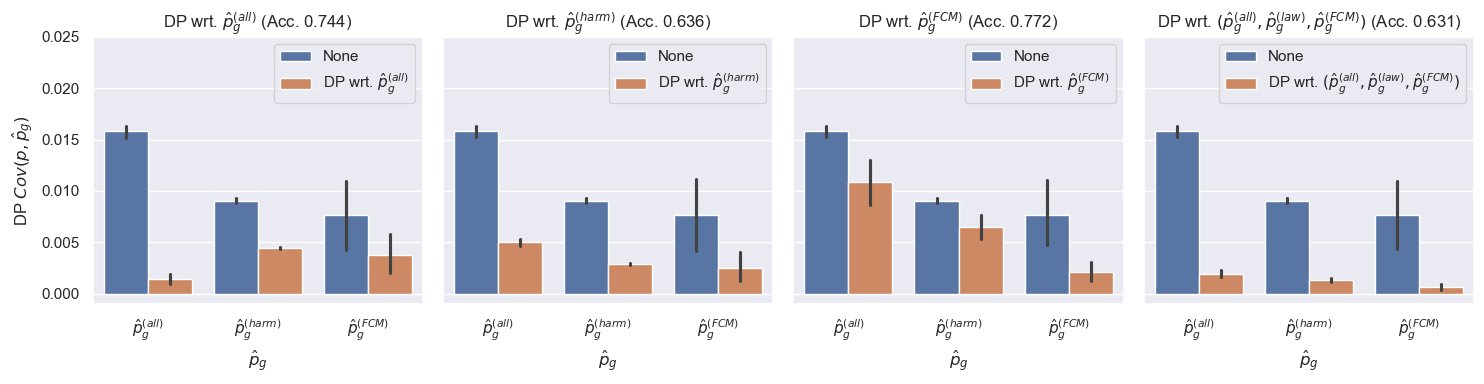

In [186]:
fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

for i, key in enumerate(plot_df['intervention_pg'].value_counts().index[1:]):
    print(key)
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df['intervention_pg'].isin([key, 'None'])]
    sns.barplot(data=subplot_df, x='eval_pg', y='abs_value', hue='intervention_pg', ax=ax)
    ax.legend(title=None, loc='upper right')
    ax.set_ylim(-0.001, 0.025)
    ax.set_xlabel(r'$\hat{p}_g$')
    ax.set_ylabel(r'DP $Cov(p, \hat{p}_g)$') 
    ax.set_title(f'{key} (Acc. {acc_dict[key]:.3f})')

plt.tight_layout()
plt.savefig('img/nels/dp_all_nels.pdf')

## Equal Opportunity

In [207]:
# DP Post Processing
EO_plot = [] 

cv = ShuffleSplit(n_splits=10, test_size=0.1, random_state=42)
acc_list = [] 

i = 0 
for train_idx, _ in cv.split(dataset.x_train, dataset.y_train):
    i += 1
    # 1. Subsampled data
    x_train_sub = dataset.x_train[train_idx]
    y_train_sub = dataset.y_train[train_idx]
    g_train_sub = dataset.g_train[train_idx]

    # 2) harmful stereotypes
    test_pg_clf_base = LogisticRegression() 
    test_pg_clf_base = test_pg_clf_base.fit(x_train_sub[:, feature_indices], g_train_sub)
    test_pg_clf = md.HarmfulFeaturesClassifier(base_clf=test_pg_clf_base, feature_ind=feature_indices)
    
    # 2c) clustering 
    cntr = find_means(pca.transform(x_train_sub), g_train_sub)
    cluster_pg_clf = md.FuzzyClusterPredictor(cntr, reduce_fn=pca)


    pg_dict = {'all_pg': all_pg_clf,
               'harm_pg': test_pg_clf,
               'cluster_pg': cluster_pg_clf}
    
    
    prev_results = ut.results_summary(p=clf.predict_proba(dataset.x_test)[:, 1], 
                            pg_dict=pg_dict, 
                            x=dataset.x_test, 
                            y=dataset.y_test, 
                            g=dataset.g_test)

    clfs = [
        ([all_pg_clf], r'$\hat{p}_g^{(all)}$'), 
        ([test_pg_clf], r'$\hat{p}_g^{(harm)}$'), 
        ([cluster_pg_clf], r'$\hat{p}_g^{(FCM)}$'), 
        ([all_pg_clf, test_pg_clf, cluster_pg_clf], r'$(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$'),
    ]
    
    for clf_list, clf_list_name in clfs: 

        if clf_list_name == r'$\hat{p}_g^{(all)}$': 
            for key in pg_dict.keys(): 
                EO_plot.append({
                    'eval_pg': key, 
                    'intervention_pg': 'None',  
                    'value': np.abs(prev_results[f'cov(p, {key} |y=1)']), 
                    'run': i, 
                    'acc': prev_results['accuracy'], 
                })

        
        eo_clf = md.EOClf(base_clf=clf, pg_clf_list=clf_list)
        eo_clf.fit_exact(x=x_train_sub, y=y_train_sub)
    
        results = ut.results_summary(p=eo_clf.predict_proba(dataset.x_test)[:, 1], 
                                pg_dict=pg_dict, 
                                x=dataset.x_test, 
                                y=dataset.y_test, 
                                g=dataset.g_test)
        for key in pg_dict.keys(): 
            EO_plot.append({
                'eval_pg': key, 
                'intervention_pg': f'EO wrt. {clf_list_name}', 
                'value': np.abs(results[f'cov(p, {key} |y=1)']),
                'acc': results['accuracy'], 
                'run': i, 
            })

/Users/jhs/Code/stereotypes/models.py:216: RuntimeWarning: Mean of empty slice.
  mask = mask_r & mask_y
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jhs/Code/stereotypes/models.py:227: RuntimeWarning: Mean of empty slice.
  neg_ind = np.logical_or(neg_ind, mask)
/Users/jhs/Code/stereotypes/models.py:216: RuntimeWarning: Mean of empty slice.
  mask = mask_r & mask_y
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/jhs/Code/stereotypes/models.py:227: RuntimeWarning: Mean of empty slice.
  neg_ind = np.logical_or(neg_ind, mask)
/Users/jhs/Code/stereotypes/models.py:216: RuntimeWarning: Mean of empty slice.
  mask = mask_r & mask_y
/Users/jhs/miniforge3/envs/mc/lib/python3.12/site-packages/numpy/core/_method

In [210]:
plot_df.to_csv('results/nels_eo.csv')

EO wrt. $\hat{p}_g^{(all)}$
EO wrt. $\hat{p}_g^{(harm)}$
EO wrt. $\hat{p}_g^{(FCM)}$
EO wrt. $(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$


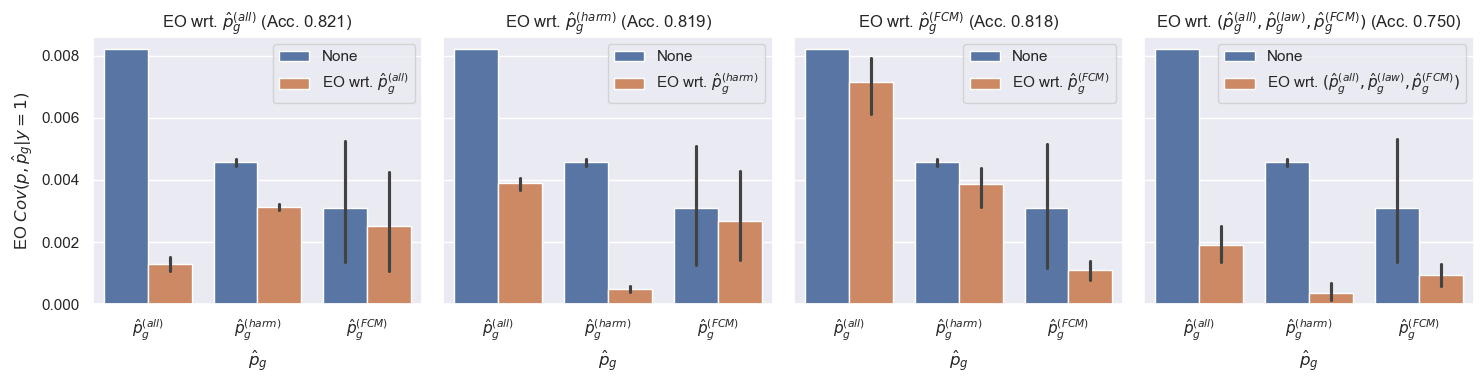

In [209]:
plot_df = pd.DataFrame(EO_plot)
plot_map = {'all_pg': r'$\hat{p}_g^{(all)}$',
            'harm_pg': r'$\hat{p}_g^{(harm)}$',
            'cluster_pg': r'$\hat{p}_g^{(FCM)}$'}
plot_df['eval_pg'] = plot_df['eval_pg'].map(plot_map)
acc_dict=plot_df.groupby("intervention_pg")['acc'].mean().to_dict()

fig, axes = plt.subplots(1, 4, figsize=(15, 4), sharey=True)

for i, key in enumerate(plot_df['intervention_pg'].value_counts().index[1:]):
    print(key)
    ax = axes.flatten()[i]
    subplot_df = plot_df[plot_df['intervention_pg'].isin([key, 'None'])]
    sns.barplot(data=subplot_df, x='eval_pg', y='value', hue='intervention_pg', ax=ax)
    ax.legend(title=None, loc='upper right')
    #ax.set_ylim(-0.001, 0.025)
    ax.set_xlabel(r'$\hat{p}_g$')
    ax.set_ylabel(r'EO $Cov(p, \hat{p}_g |y=1)$') 
    ax.set_title(f'{key} (Acc. {acc_dict[key]:.3f})')

plt.tight_layout()
plt.savefig('img/nels/eo_all_nels.pdf')



status
EO wrt. $(\hat{p}_g^{(all)}, \hat{p}_g^{(law)}, \hat{p}_g^{(FCM)})$    0.880211
original                                                               0.884876
Name: acc, dtype: float64


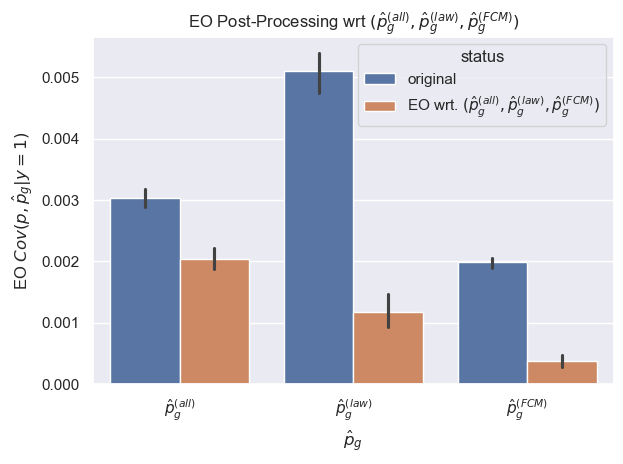

In [432]:
plot_df = pd.DataFrame(DP_plot)
print(plot_df.groupby("status")['acc'].mean())
plot_map = {'all_pg': r'$\hat{p}_g^{(all)}$',
            'occ_pg': r'$\hat{p}_g^{(law)}$',
            'cluster_pg': r'$\hat{p}_g^{(FCM)}$'}
plot_df['pg'] = plot_df['pg'].map(plot_map)

sns.barplot(data=plot_df, x='pg', y='value', hue='status')
plt.xlabel(r'$\hat{p}_g$')
plt.ylabel(r'EO $Cov(p, \hat{p}_g | y=1)$') 
plt.title(f'EO Post-Processing wrt {clf_list_name}')
plt.tight_layout()
#plt.savefig(f'img/eo_{clf_name}.pdf')